# 0.0 IMPORTAR BIBLIOTECAS

In [96]:
import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime
import sweetviz as sv
from tabulate import tabulate
from scipy import stats as ss


In [2]:
# Ajustar gráficos
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 10



## 0.1 Funções

In [105]:
def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).values
  n = cm.sum()
  r, k = cm.shape

  chi2 = ss.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
  
  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2 Carregar base de dados

In [3]:
df_sales_raw = pd.read_csv( '../datasets/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '../datasets/store.csv', low_memory=False )

# merge entre os dois dataframes
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 DESCRICAO DOS DADOS

In [4]:
df1 = df_raw.copy()

In [5]:
# Renomear as colunas para mdoelo snakecase

cols_old = df1.columns
snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )
df1.columns = cols_new

## 1.2. Tamanho dos dados (shape)

In [6]:
df1.shape

(1017209, 18)

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Tipo dos Dados (Dtypes)

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
# Tranaformar a coluna Date para formato de data
df1['date'] = pd.to_datetime( df1['date'] )


## 1.4. Checagem de N/As

In [10]:
df1.isna().sum()


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Como proceder para a retirada dos NAs ?

- Descartar todas as linhas com NA.
- Usando algoritmos de ML para inserir dados.
- Entendendo o negócio para inserir dados.

## 1.5 Preencher os NA

In [11]:
# competition_distance              
### Para todos os campos NA nesta coluna considerar e inserir o valor de 200.000 (valor máximo escolhido para este df)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x )

# competition_open_since_month  
### Para todos os campos NA nesta coluna considerar e inserir o valor do mês da venda (Coluna "date").
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

# competition_open_since_year       
### Para todos os campos NA nesta coluna considerar e inserir o valor do ano da venda (Coluna "date").
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

# promo2_since_week 
### Para todos os campos NA nesta coluna considerar e inserir o valor da semana da venda (Coluna "date").
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

# promo2_since_year
### Para todos os campos NA nesta coluna considerar e inserir o valor do ano da venda (Coluna "date").
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

# promo_interval
month_map = {1: 'Jan',2: 'Fev',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug', 9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True) # substituir todos os NA para 0 (zero)
df1['month_map'] = df1['date'].dt.month.map(month_map) # criar uma nova coluna e inserir o mês da coluna "Date" conforme a variavel "month_map"
df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [12]:
df1.sample(5).T

993589               921330  \
store                                         910                   11   
day_of_week                                     2                    3   
date                          2013-01-22 00:00:00  2013-03-27 00:00:00   
sales                                        6461                12419   
customers                                     668                 1523   
open                                            1                    1   
promo                                           1                    1   
state_holiday                                   0                    0   
school_holiday                                  0                    1   
store_type                                      d                    a   
assortment                                      c                    c   
competition_distance                      12480.0                960.0   
competition_open_since_month                  1.0                 11.0   
competition_open_since_year                2013.0               2011.0   
promo2                                          1                    1   
promo2_since_week                             1.0                  1.0   
promo2_since_year                          2013.0               2012.0   
promo_interval                    Jan,Apr,Jul,Oct      Jan,Apr,Jul,Oct   
month_map                                     Jan                  Mar   
is_promo                                        1                    0   

                                           102819               169811  \
store                                         240                  332   
day_of_week                                     4                    7   
date                          2015-04-30 00:00:00  2015-03-01 00:00:00   
sales                                        6361                    0   
customers                                     576                    0   
open                                            1                    0   
promo                                           1                    0   
state_holiday                                   0                    0   
school_holiday                                  0                    0   
store_type                                      a                    a   
assortment                                      a                    a   
competition_distance                       1110.0               1840.0   
competition_open_since_month                  5.0                  3.0   
competition_open_since_year                2009.0               2006.0   
promo2                                          0                    0   
promo2_since_week                            18.0                  9.0   
promo2_since_year                          2015.0               2015.0   
promo_interval                                  0                    0   
month_map                                     Apr                  Mar   
is_promo                                        0                    0   

                                           782270  
store                                         326  
day_of_week                                     2  
date                          2013-07-30 00:00:00  
sales                                        4876  
customers                                     383  
open                                            1  
promo                                           1  
state_holiday                                   0  
school_holiday                                  1  
store_type                                      d  
assortment                                      a  
competition_distance                      10070.0  
competition_open_since_month                  5.0  
competition_open_since_year                2015.0  
promo2                                          1  
promo2_since_week                            31.0  
promo2_since_year                          2013.0

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Tipos de Mudança

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# transformar valores para inteiros
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descrição Estatística dos dados

Métricas de tendência central : 

- media 
- mediana

Métricas de dispersão : 

- desvio padrão
- valor minimo
- valor máximo
- faixa(range) 
- skew(inclinação)
- curtose 

In [16]:
numericos = df1.select_dtypes(include=['int64','float64' ])
categoricos = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1. Atributos Numéricos

In [17]:
# Métricas de tendência central 
media = pd.DataFrame ( numericos.apply(np.mean)).T
mediana = pd.DataFrame ( numericos.apply(np.median)).T

In [18]:
# Métricas de dispersão
desvio_padrao = pd.DataFrame ( numericos.apply(np.std)).T
minimo = pd.DataFrame ( numericos.apply(min)).T
maximo = pd.DataFrame ( numericos.apply(max)).T
faixa = pd.DataFrame ( numericos.apply(lambda x: x.max() - x.min())).T
inclinação = pd.DataFrame ( numericos.apply(lambda x: x.skew() )).T
curtose = pd.DataFrame ( numericos.apply(lambda x: x.kurtosis())).T

In [19]:
#Concatenar
metricas = pd.concat([minimo, maximo, faixa, media, mediana, desvio_padrao, inclinação, curtose ]).T.reset_index()
metricas.columns = ['attributes','min','max','range','mean', 'median', 'std', 'skew','kurtosis' ]
metricas

attributes     min       max     range         mean  \
0                          store     1.0    1115.0    1114.0   558.429727   
1                    day_of_week     1.0       7.0       6.0     3.998341   
2                          sales     0.0   41551.0   41551.0  5773.818972   
3                      customers     0.0    7388.0    7388.0   633.145946   
4                           open     0.0       1.0       1.0     0.830107   
5                          promo     0.0       1.0       1.0     0.381515   
6                 school_holiday     0.0       1.0       1.0     0.178647   
7           competition_distance    20.0  200000.0  199980.0  5935.442677   
8   competition_open_since_month     1.0      12.0      11.0     6.786849   
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840   
10                        promo2     0.0       1.0       1.0     0.500564   
11             promo2_since_week     1.0      52.0      51.0    23.619033   
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297   
13                      is_promo     0.0       1.0       1.0     0.155231   

    median           std       skew    kurtosis  
0    558.0    321.908493  -0.000955   -1.200524  
1      4.0      1.997390   0.001593   -1.246873  
2   5744.0   3849.924283   0.641460    1.778375  
3    609.0    464.411506   1.598650    7.091773  
4      1.0      0.375539  -1.758045    1.090723  
5      0.0      0.485758   0.487838   -1.762018  
6      0.0      0.383056   1.677842    0.815154  
7   2330.0  12547.646829  10.242344  147.789712  
8      7.0      3.311085  -0.042076   -1.232607  
9   2012.0      5.515591  -7.235657  124.071304  
10     1.0      0.500000  -0.002255   -1.999999  
11    22.0     14.310057   0.178723   -1.184046  
12  2013.0      1.662657  -0.784436   -0.210075  
13     0.0      0.362124   1.904152    1.625796

### 1.7.2. Atributos Categóricos

In [20]:
# Quantos niveis cada variável categorica possui ?
categoricos.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

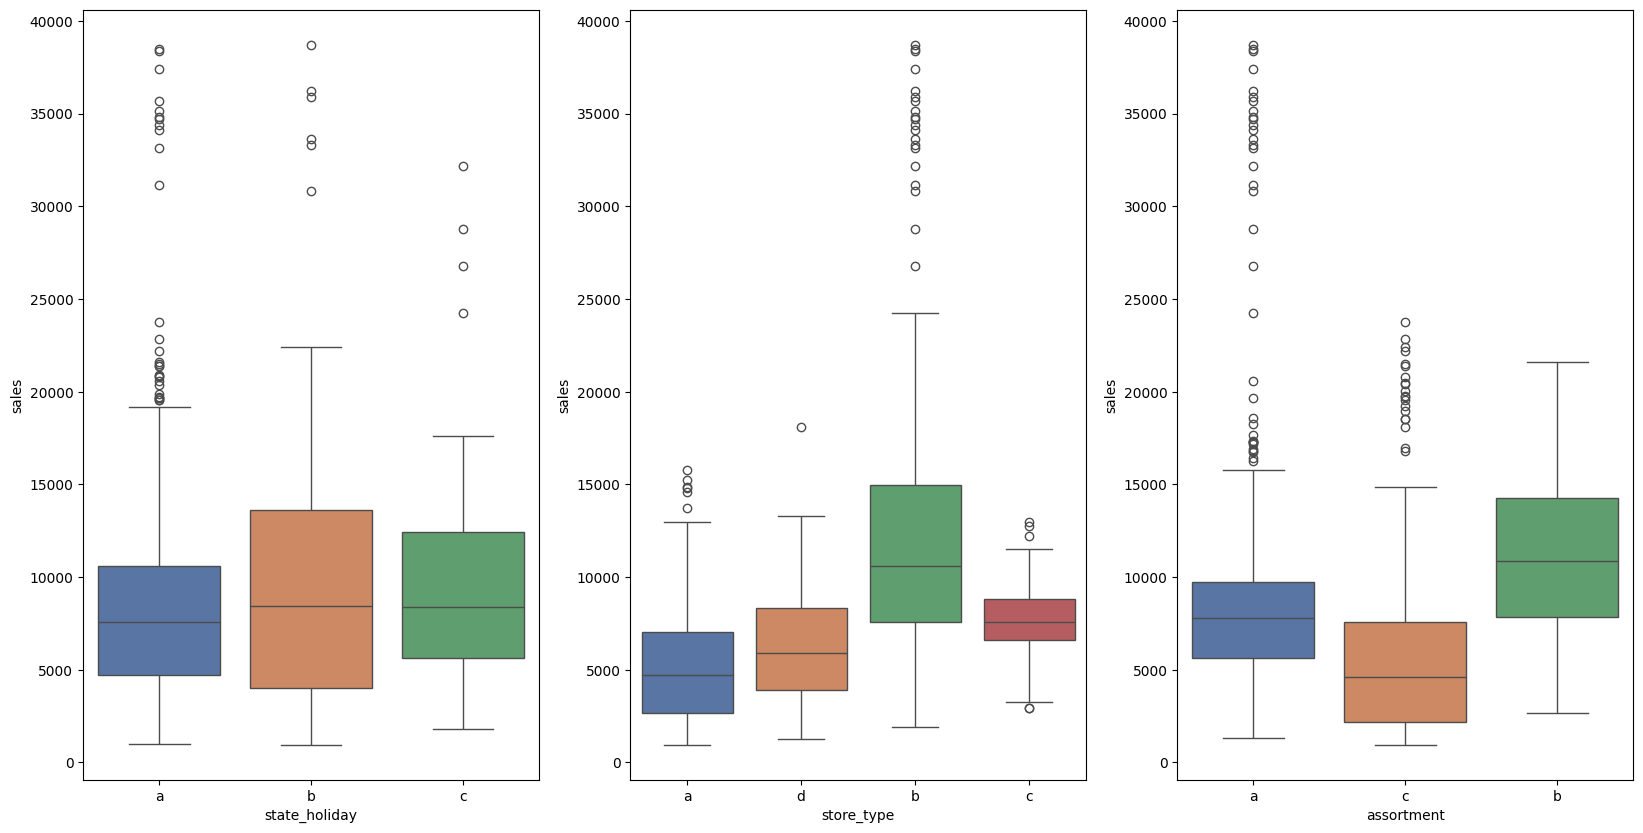

In [21]:
filtro = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=filtro, hue='state_holiday', palette='deep', legend=False)

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=filtro, hue='store_type', palette='deep', legend=False)

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=filtro, hue='assortment', palette='deep', legend=False)

# 2.0 FEATURE ENGINEERING

## 2.1 Mapa mental de hipóteses

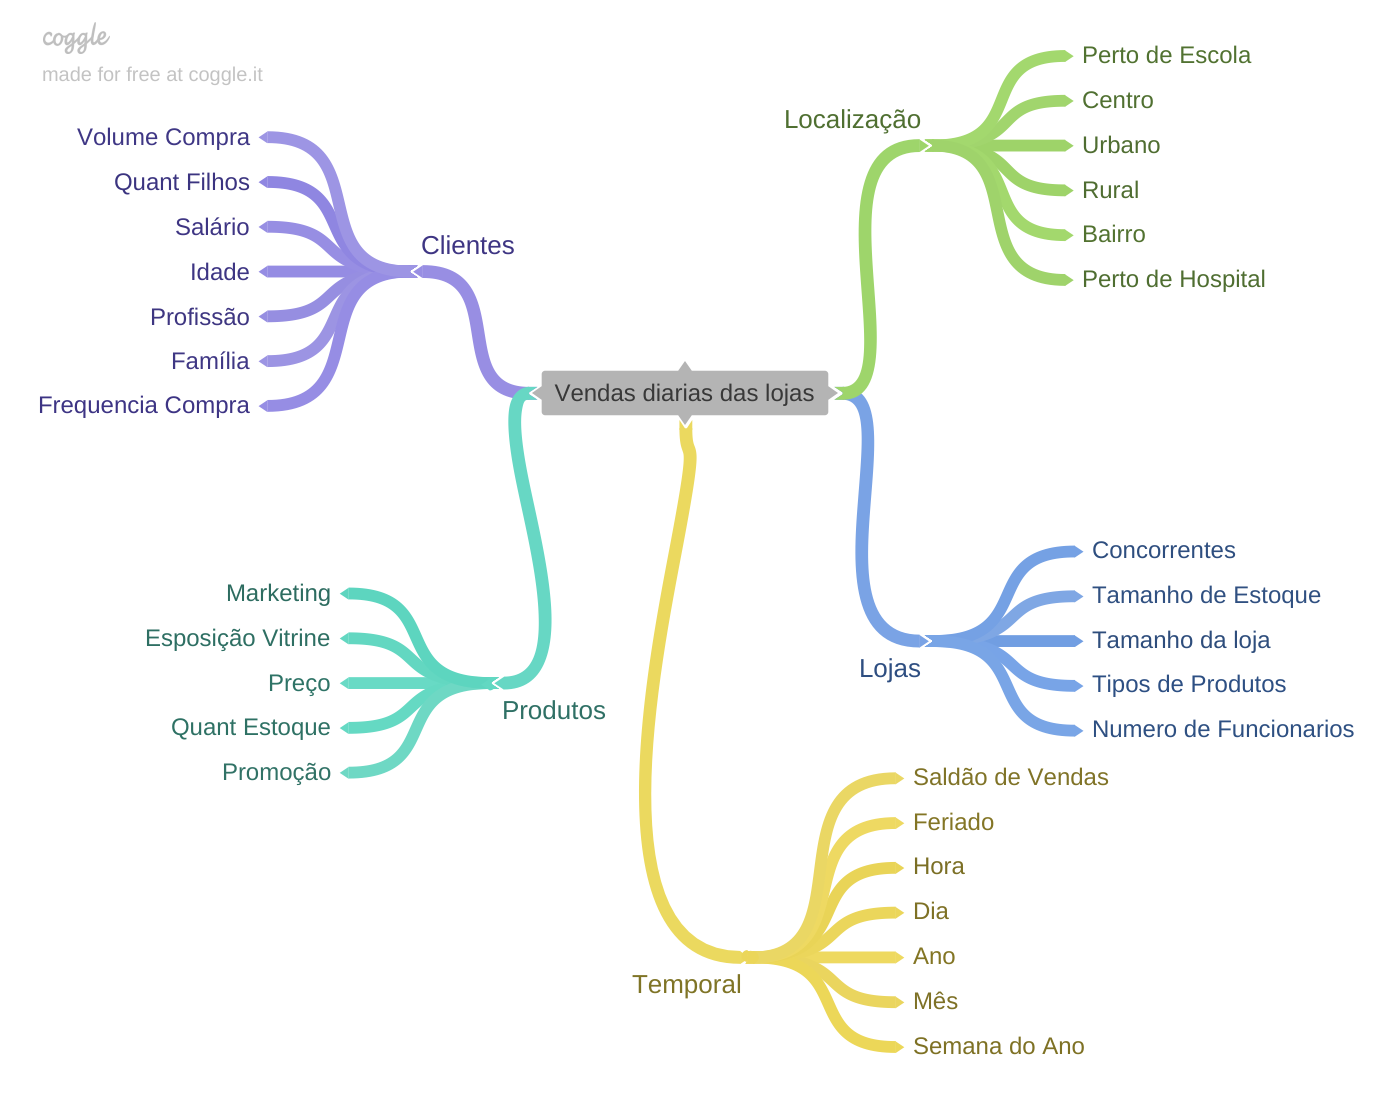

In [22]:
Image('../img/mindmap.png')

## 2.2 Criação das Hipoteses

### 2.2.1 Hipoteses da loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses do produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.



### 2.2.3 Hipoteses do tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final das Hipoteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
7. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [23]:
df2 = df1.copy()

In [24]:
#Ano
df2['year'] = df2['date'].dt.year

#Mês
df2['month'] = df2['date'].dt.month

#Dia
df2['day'] = df2['date'].dt.day

#Dia da Semana
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Semana no Ano
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Data em dias de competição
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day= 1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# Data em dias de promoção
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# categorias
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# feriados
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [25]:
df2.sample(5).T

760282               785833  \
store                                         638                  544   
day_of_week                                     1                    6   
date                          2013-08-19 00:00:00  2013-07-27 00:00:00   
sales                                        4882                 6629   
customers                                     442                 1027   
open                                            1                    1   
promo                                           0                    0   
state_holiday                         regular_day          regular_day   
school_holiday                                  1                    0   
store_type                                      d                    a   
assortment                                  basic                basic   
competition_distance                      10170.0                250.0   
competition_open_since_month                   11                   12   
competition_open_since_year                  2001                 2001   
promo2                                          0                    1   
promo2_since_week                              34                   13   
promo2_since_year                            2013                 2010   
promo_interval                                  0      Jan,Apr,Jul,Oct   
month_map                                     Aug                  Jul   
is_promo                                        0                    1   
year                                         2013                 2013   
month                                           8                    7   
day                                            19                   27   
week_of_year                                   34                   30   
year_week                                 2013-33              2013-29   
competition_since             2001-11-01 00:00:00  2001-12-01 00:00:00   
competition_time_month                        143                  141   
promo_since                   2013-08-19 00:00:00  2010-03-22 00:00:00   
promo_time_week                                 0                  174   

                                           608542               157331  \
store                                         538                  117   
day_of_week                                     4                    4   
date                          2014-01-02 00:00:00  2015-03-12 00:00:00   
sales                                        3626                 3797   
customers                                     523                  473   
open                                            1                    1   
promo                                           0                    0   
state_holiday                         regular_day          regular_day   
school_holiday                                  1                    0   
store_type                                      a                    a   
assortment                                  basic                basic   
competition_distance                        990.0               3450.0   
competition_open_since_month                    2                    9   
competition_open_since_year                  2010                 2011   
promo2                                          0                    0   
promo2_since_week                               1                   11   
promo2_since_year                            2014                 2015   
promo_interval                                  0                    0   
month_map                                     Jan                  Mar   
is_promo                                        0                    0   
year                                         2014                 2015   
month                                           1                    3   
day                                             2                   12   
week_of_year                                  

# 3.0 Filtragem de Variáveis

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  \
0      1            5 2015-07-31   5263        555     1      1   regular_day   
1      2            5 2015-07-31   6064        625     1      1   regular_day   
2      3            5 2015-07-31   8314        821     1      1   regular_day   
3      4            5 2015-07-31  13995       1498     1      1   regular_day   
4      5            5 2015-07-31   4822        559     1      1   regular_day   

   school_holiday store_type  ... is_promo  year  month  day  week_of_year  \
0               1          c  ...        0  2015      7   31            31   
1               1          a  ...        1  2015      7   31            31   
2               1          a  ...        1  2015      7   31            31   
3               1          c  ...        0  2015      7   31            31   
4               1          a  ...        0  2015      7   31            31   

   year_week  competition_since competition_time_month promo_since  \
0    2015-30         2008-09-01                     84  2015-07-27   
1    2015-30         2007-11-01                     94  2010-03-22   
2    2015-30         2006-12-01                    105  2011-03-28   
3    2015-30         2009-09-01                     71  2015-07-27   
4    2015-30         2015-04-01                      4  2015-07-27   

   promo_time_week  
0                0  
1              279  
2              226  
3                0  
4                0  

[5 rows x 29 columns]

## 3.1 Filtragem das Linhas

In [28]:
# Filltro para considerar a coluna Opem diferentes de zero (lojas abertas) e Sales maior que zero (Vendas)
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtragem das Colunas

In [29]:
colunas_para_dropar = ['customers', 'open', 'promo_interval','month_map']
df3 = df3.drop(colunas_para_dropar, axis=1)

In [30]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EDA - Análise Exploratória de Dados

In [31]:
df4 = df3.copy()

## 4.1 Análise Univariada

A váriavel resposta para este projeto é a coluna "Sales"

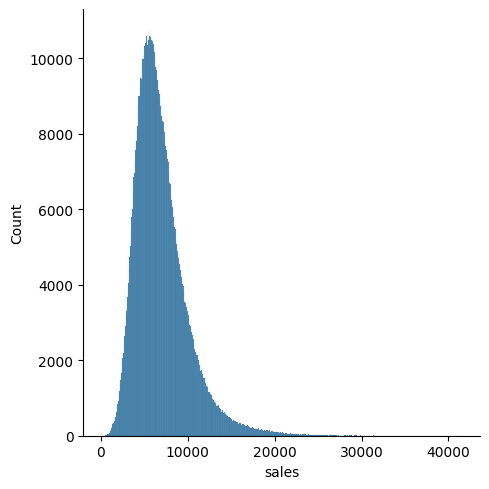

In [32]:
sns.displot(df4['sales'], kde=False)

### 4.1.2 Variável numérica

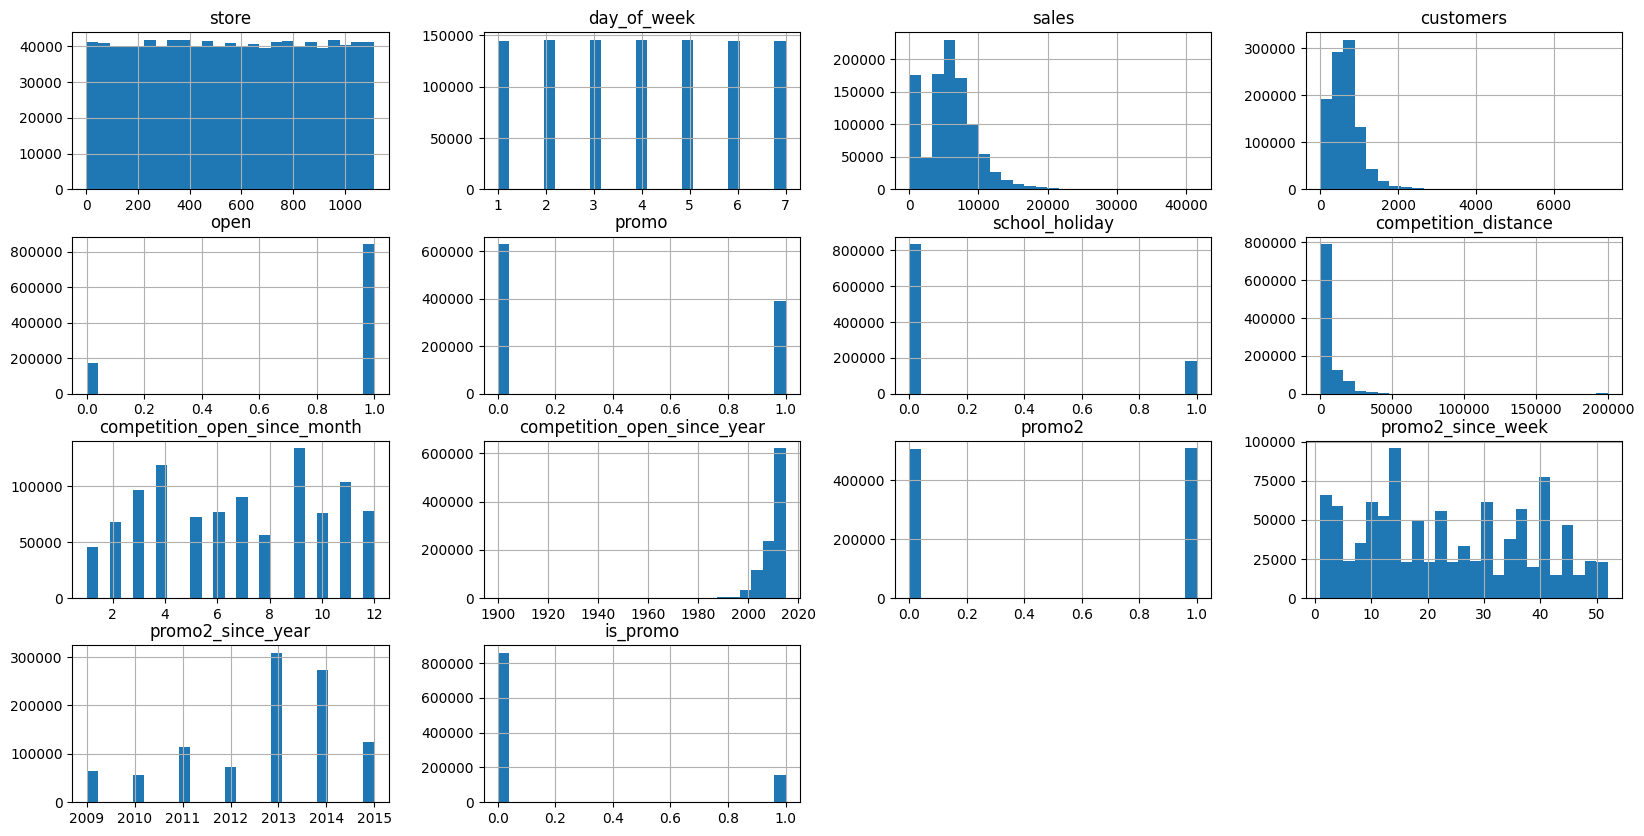

In [33]:
numericos.hist(bins=25);

- Store : Numeração de cada loja, grafico pouco explicativo
- Day of week : Valores de vendas parecidos em todos os dias
- Sales : Valores de venda concentrado em até 20k
- Customers : Valres da quantidade de clientes/dia concentrado até em 2k
- Open : Maioria das lojas abertas, valor =1
- Promo : Maioria das vendas em dias de não promoção, valor=0
- SchoolHoliday : Maioria das vendas em dias de aulas normais(sem férias), valor=0
- CompetitionDistance : Valres da quantidade de distencias concentrado até em 2k
- competition_open_since_month : maiores vendas em Setembro, Abril e Novembro.Piores em Janeiro e Agosto.
- competition_open_since_year : maiores vendas no último ano
- promo2: valores muito parecidos, pouco relevante
- promo2_since_week : comportamento do grafico se parece um pouco com o competition_open_since_month
- promo2_since_year : aqui as maiores vendas sao concentradas em 2013
- is_promo : maioria com valor = 0



Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



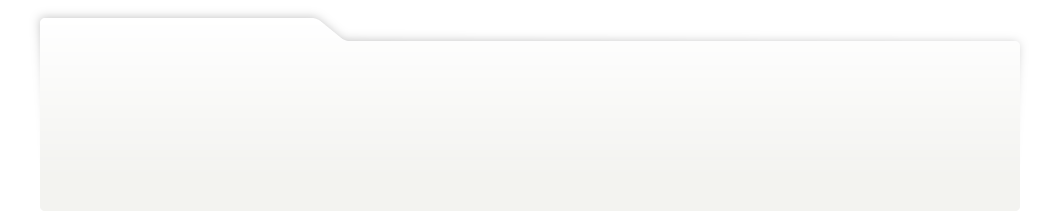
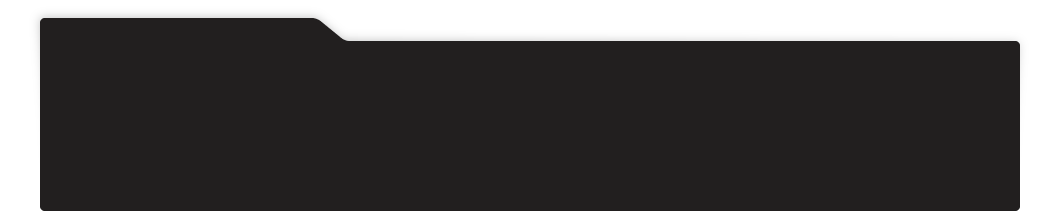
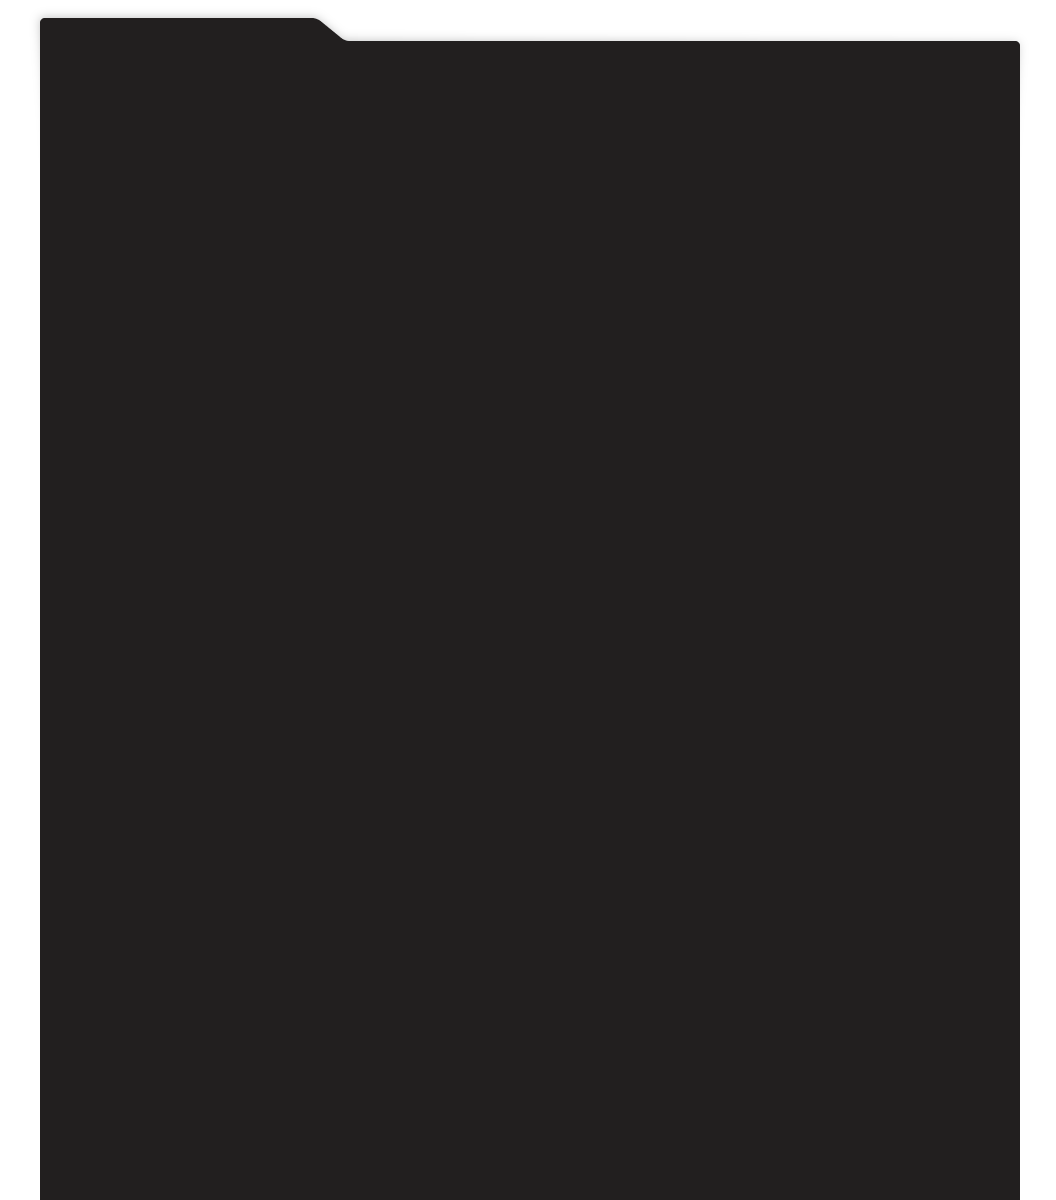
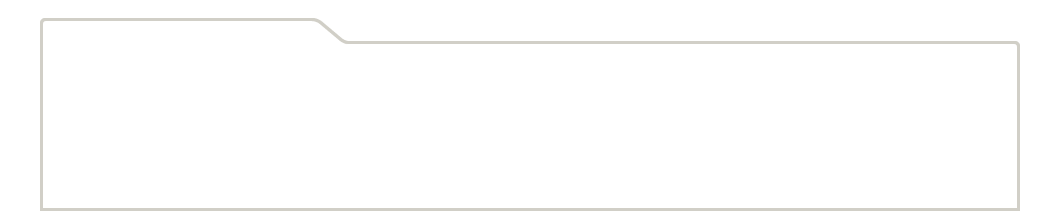
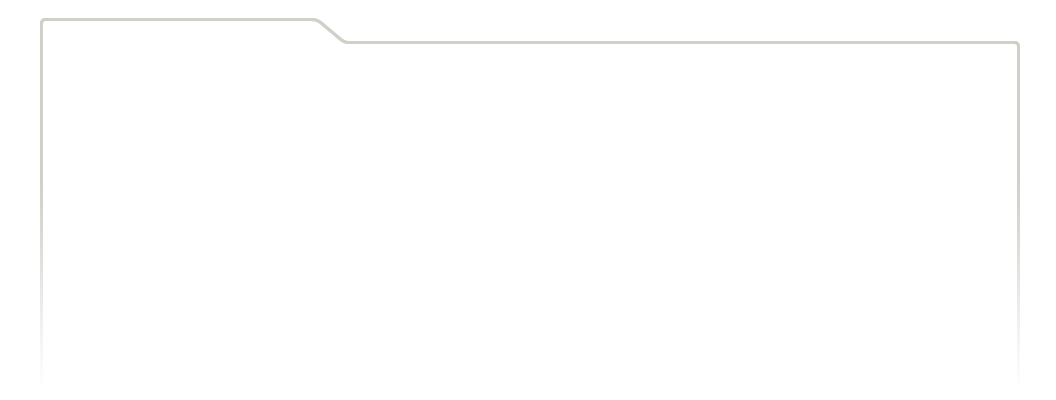
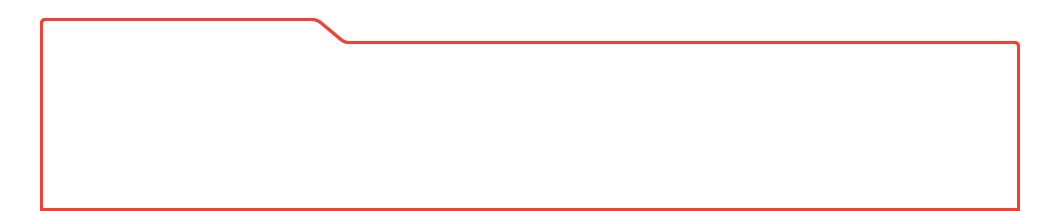
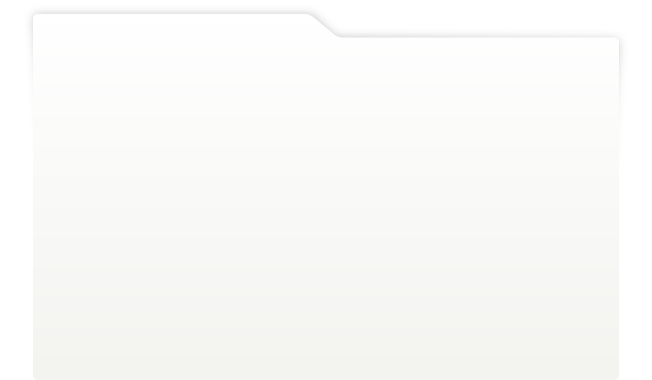
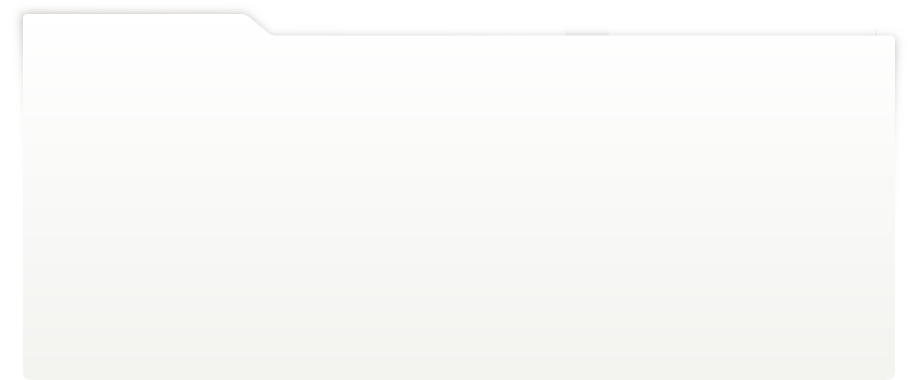
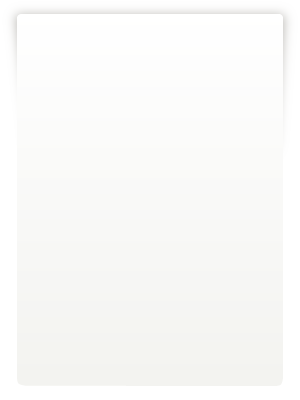
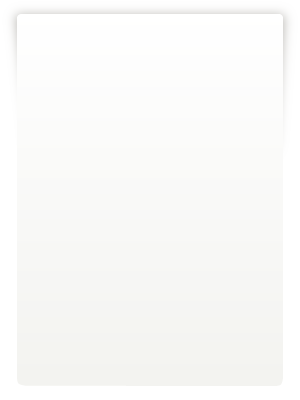
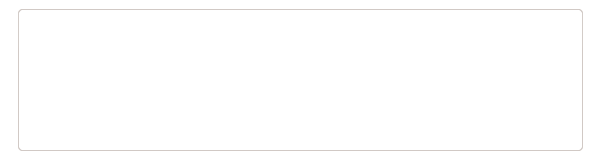
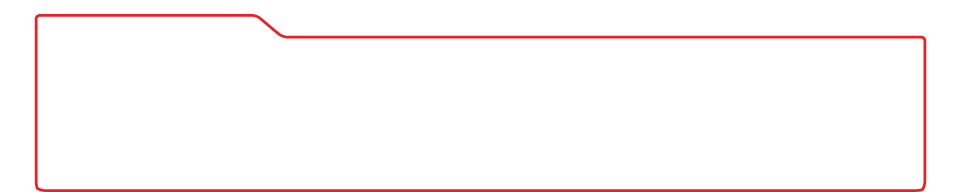
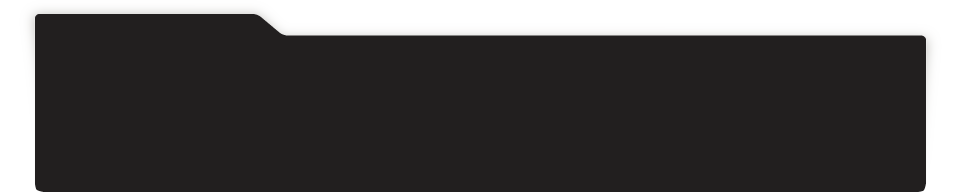
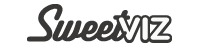
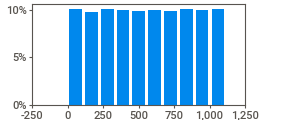
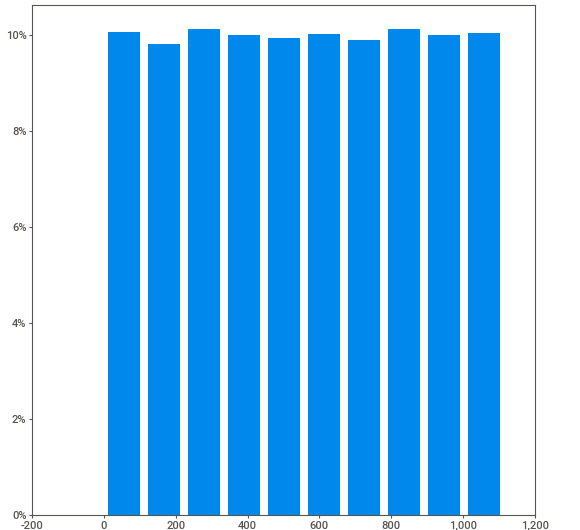
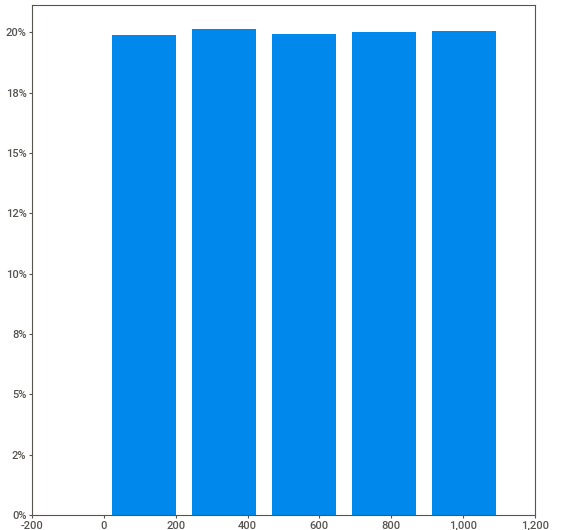
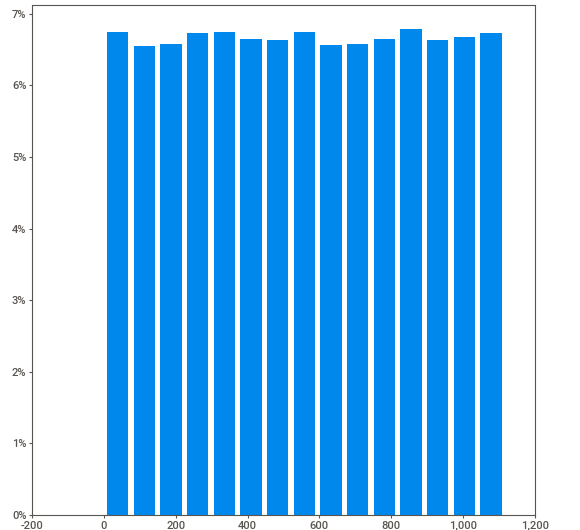
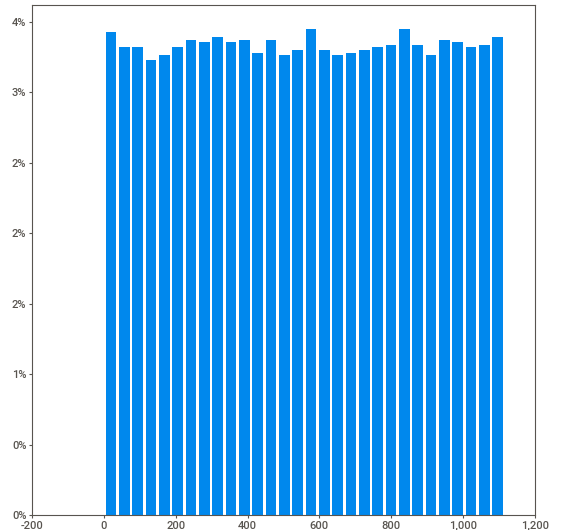
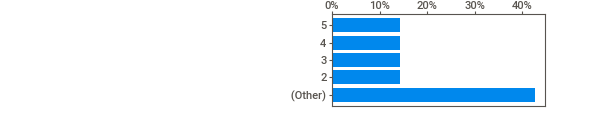
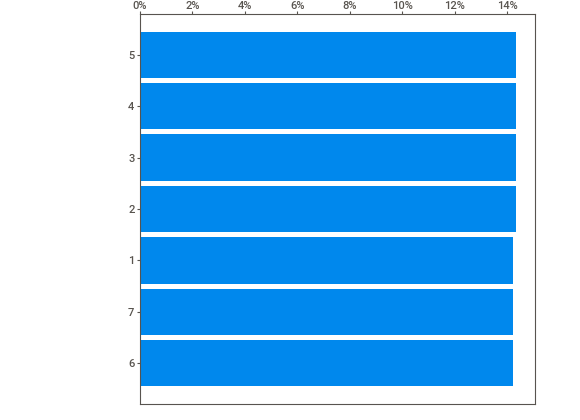
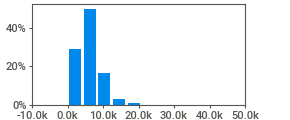
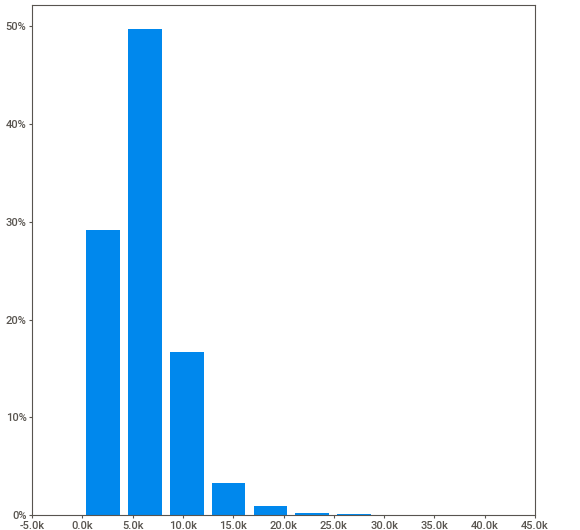
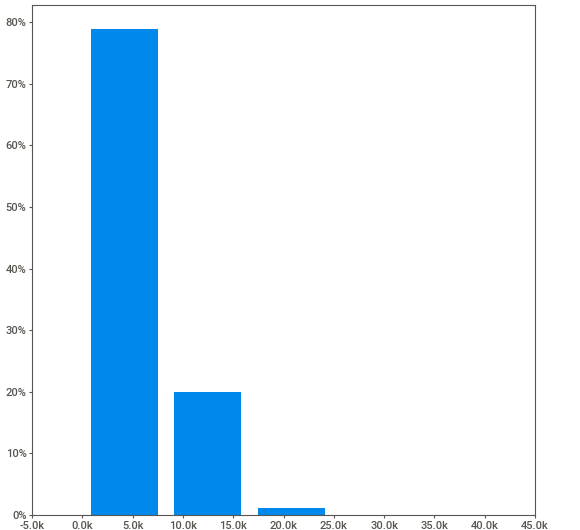
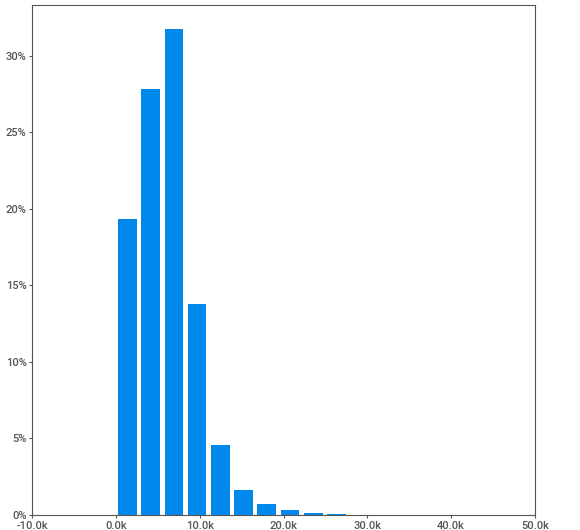
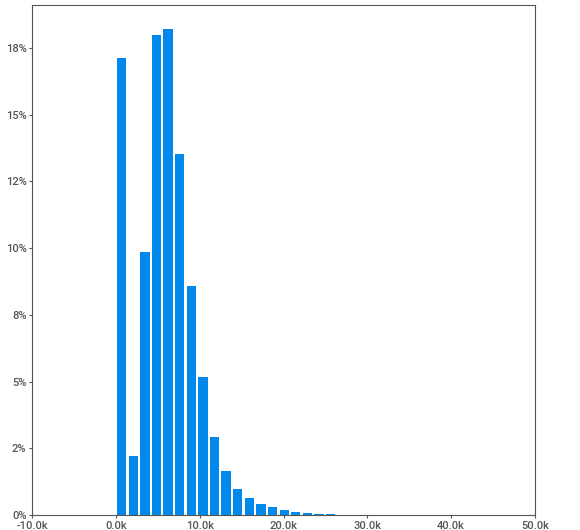
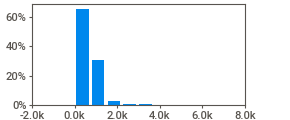
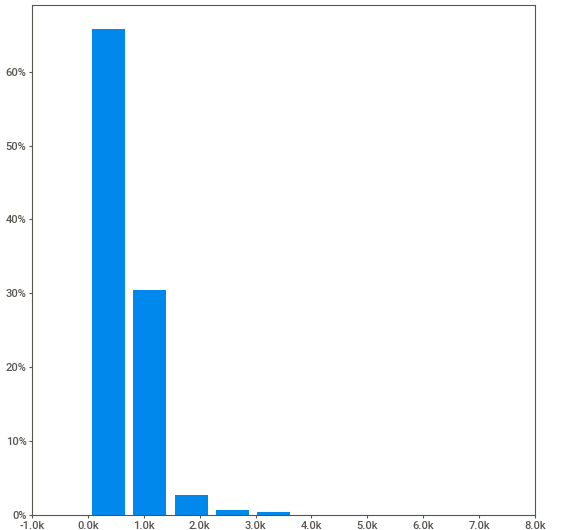
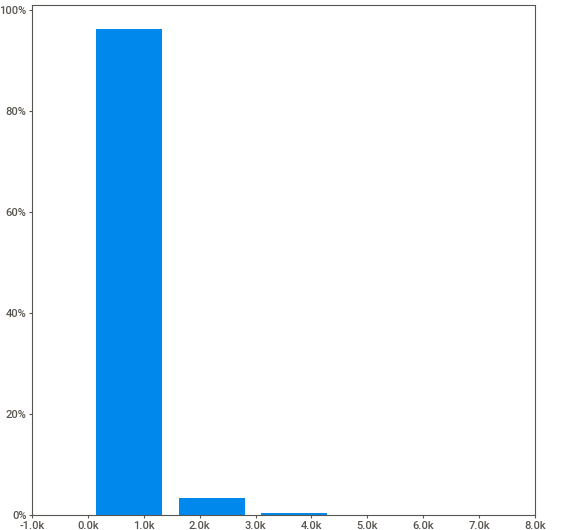
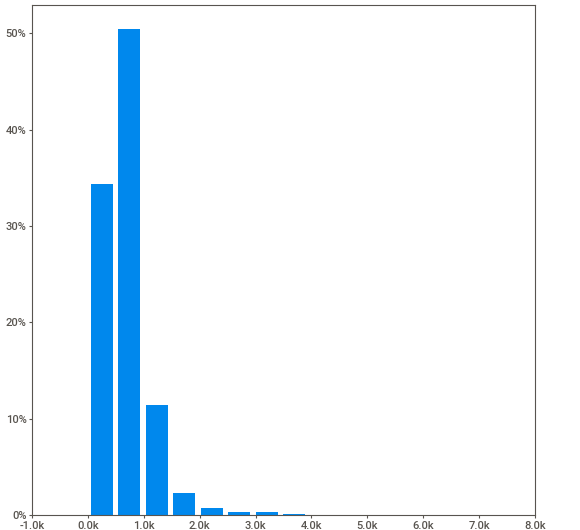
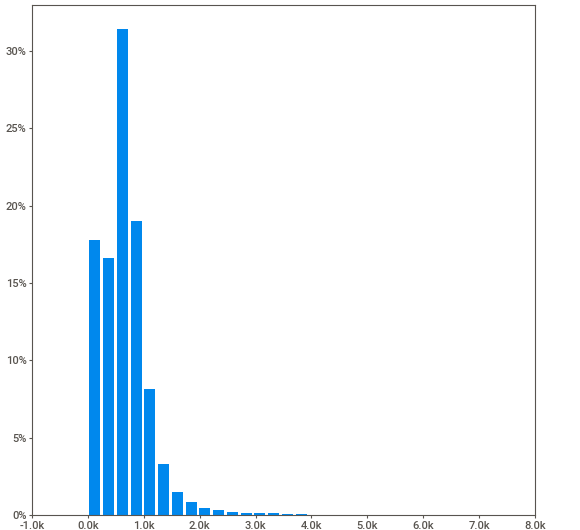
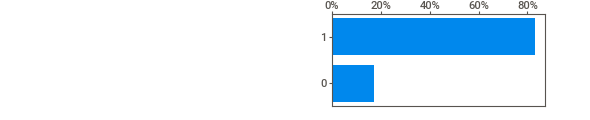
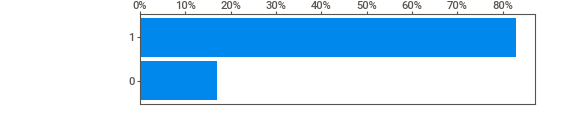
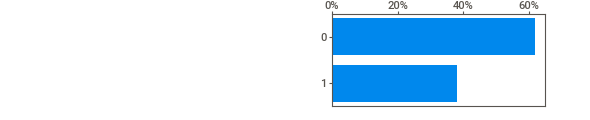
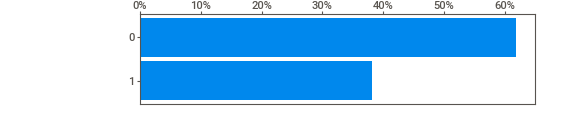
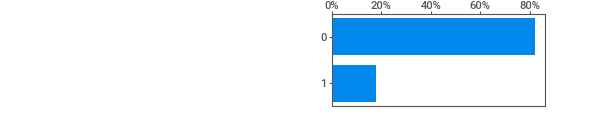
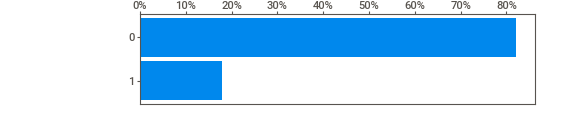
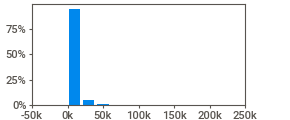
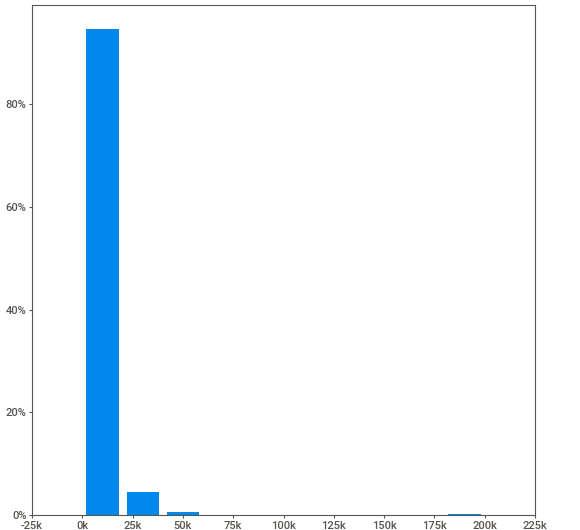
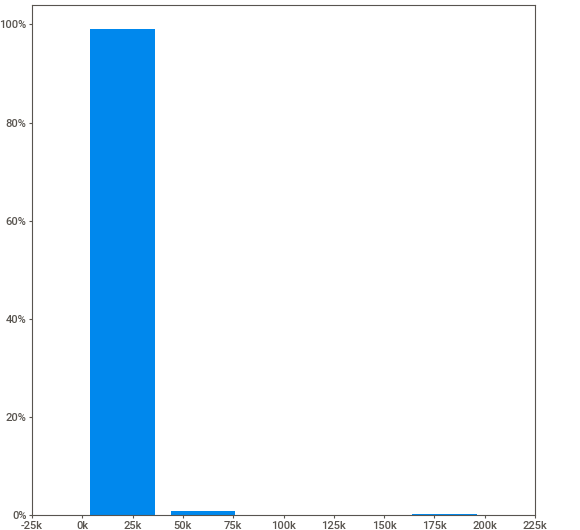
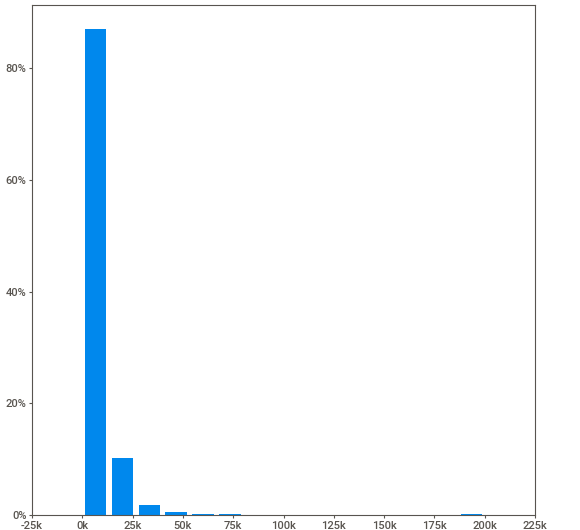
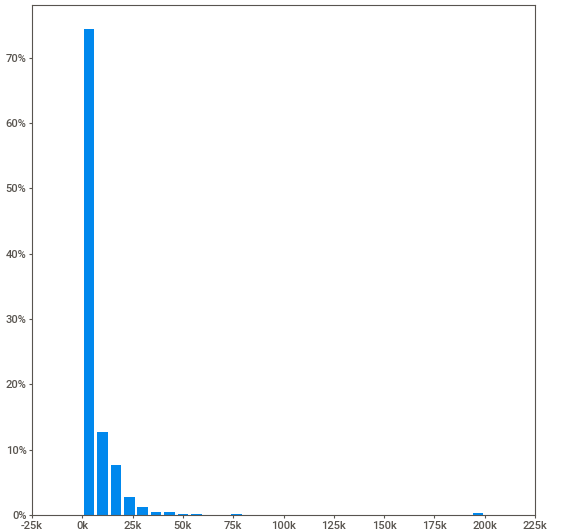
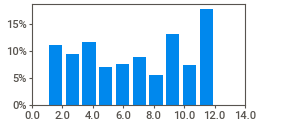
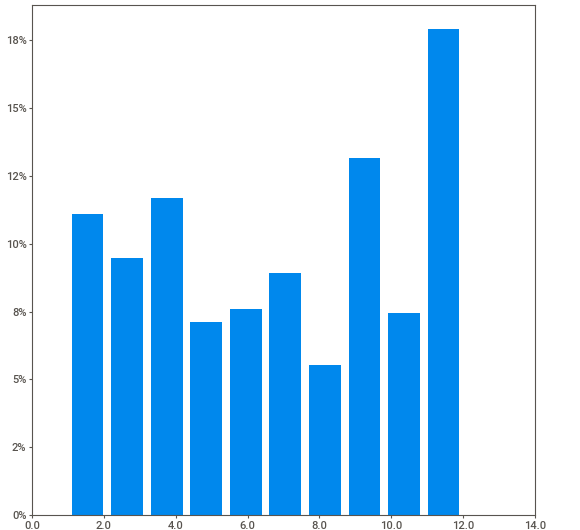
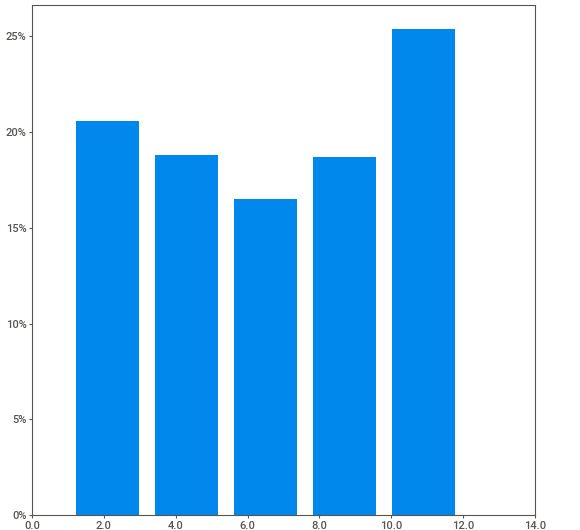
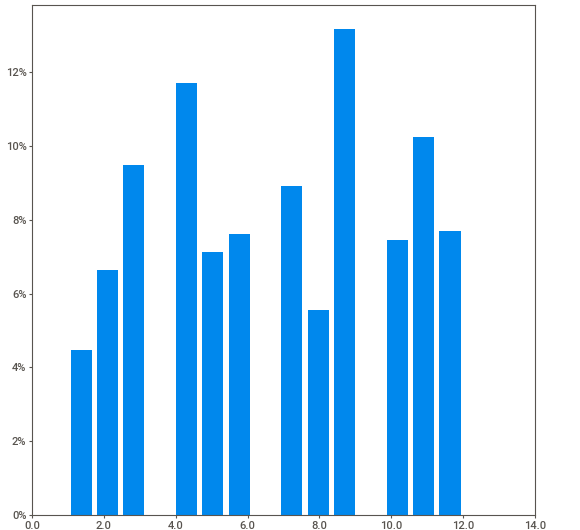
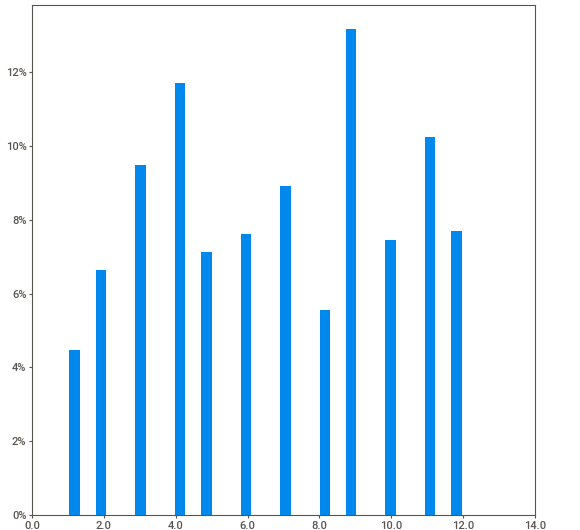
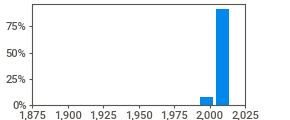
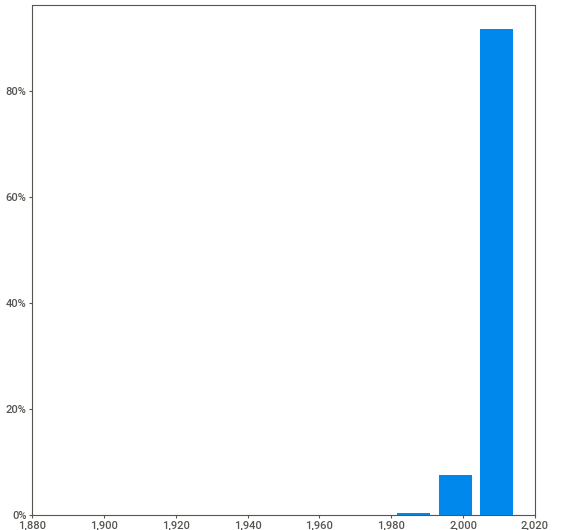
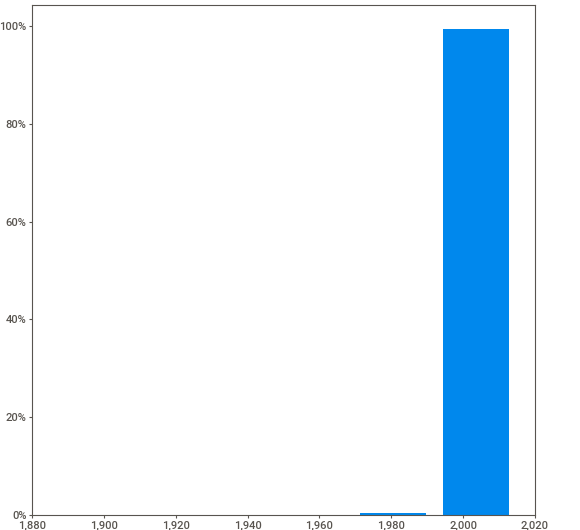
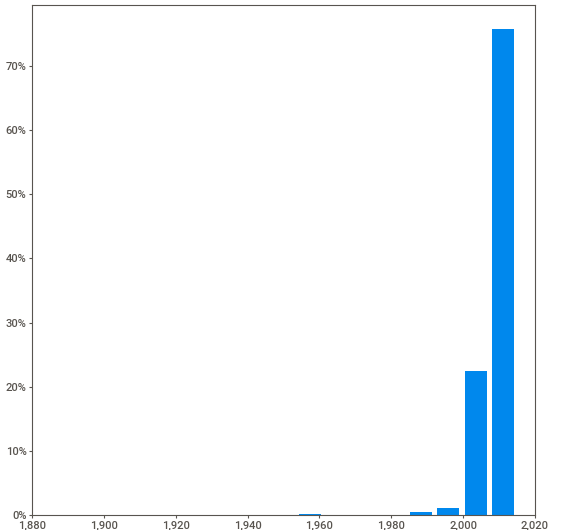
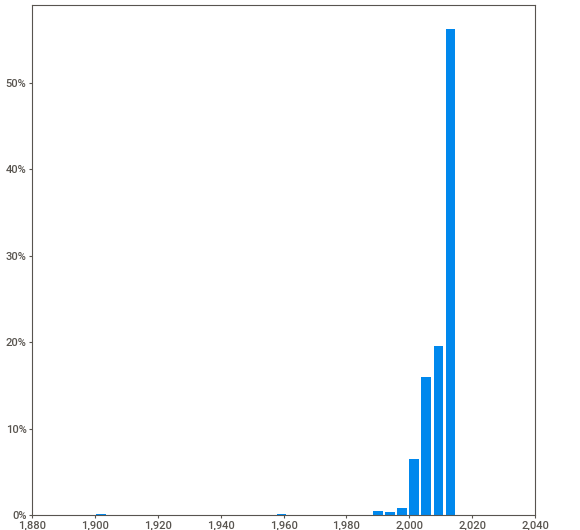
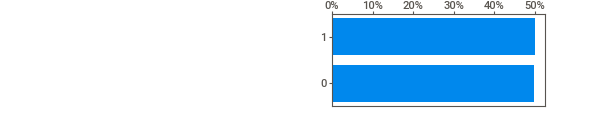
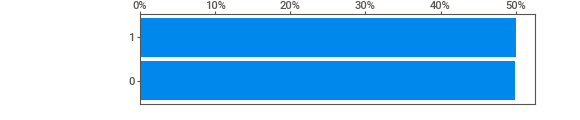
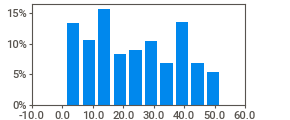
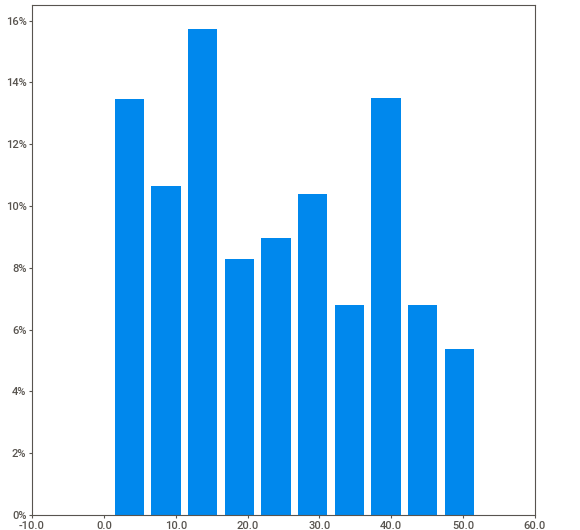
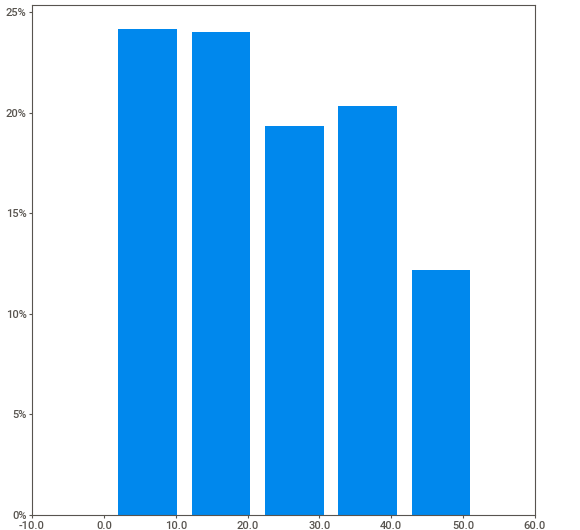
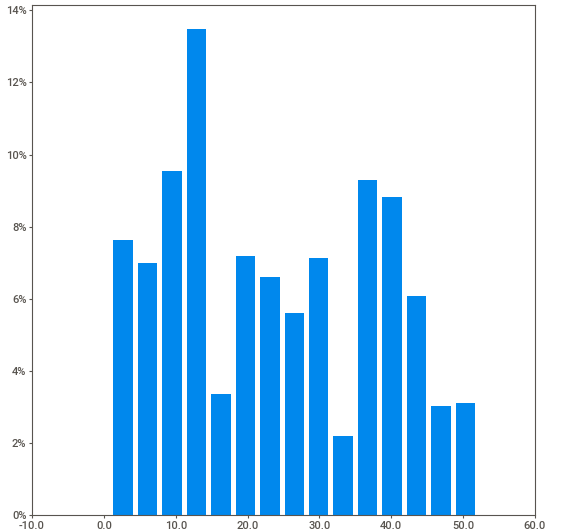
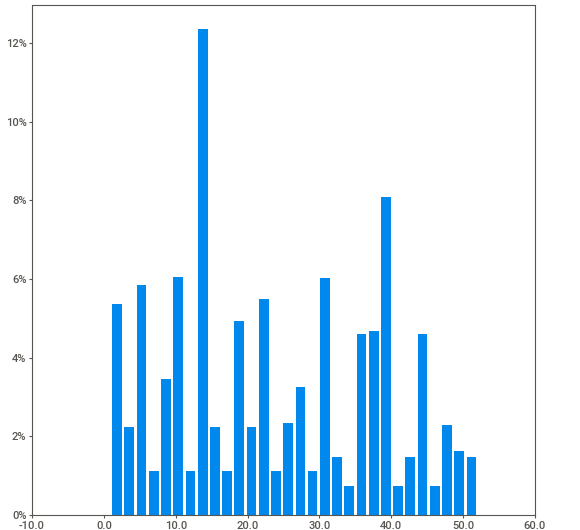
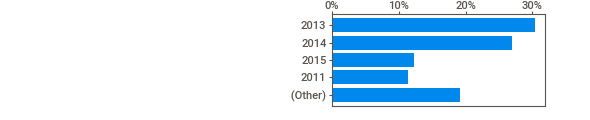
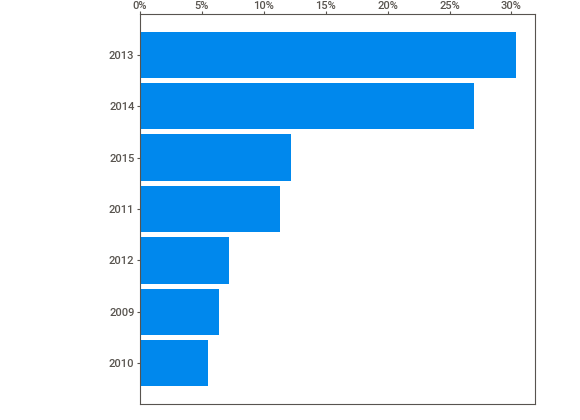
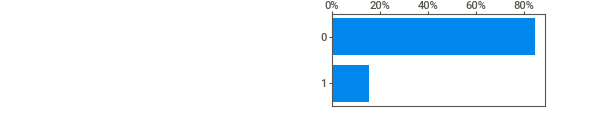
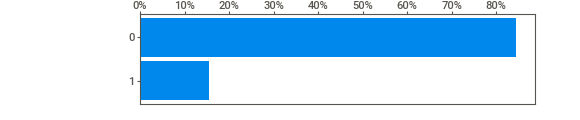
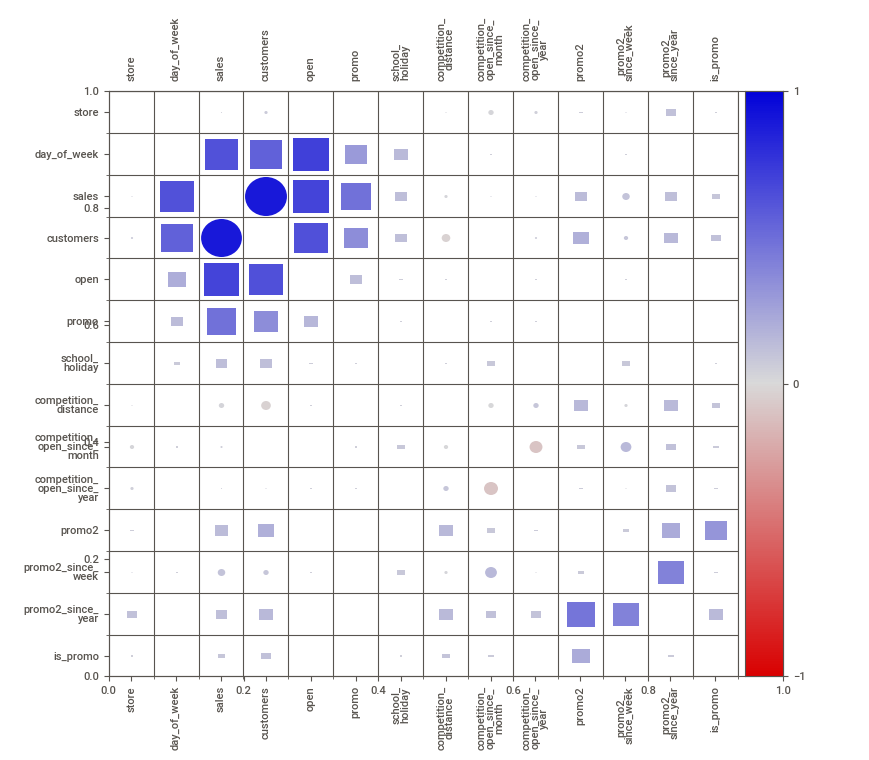
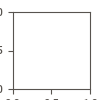

In [34]:
report = sv.analyze(numericos)
report.show_notebook()

### 4.1.2 Variável categórica

In [35]:
categoricos.head()

state_holiday store_type assortment   promo_interval month_map
0             0          c          a                0       Jul
1             0          a          a  Jan,Apr,Jul,Oct       Jul
2             0          a          a  Jan,Apr,Jul,Oct       Jul
3             0          c          c                0       Jul
4             0          a          a                0       Jul

<Axes: xlabel='state_holiday', ylabel='count'>

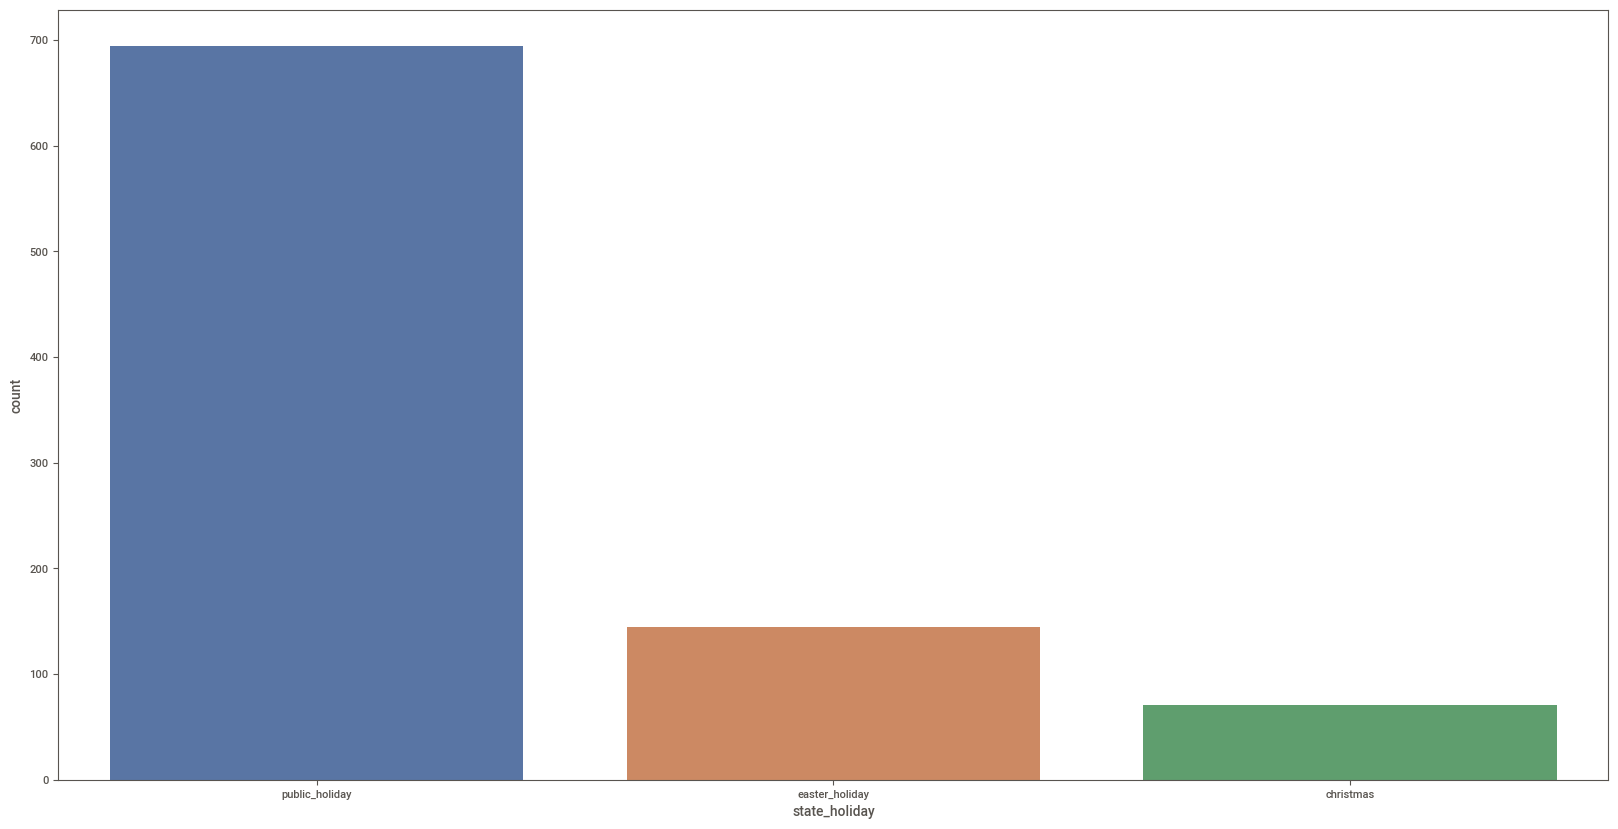

In [36]:
# state_holiday
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'], data=a, hue='state_holiday', palette='deep', legend=False)

<Axes: xlabel='sales', ylabel='Density'>

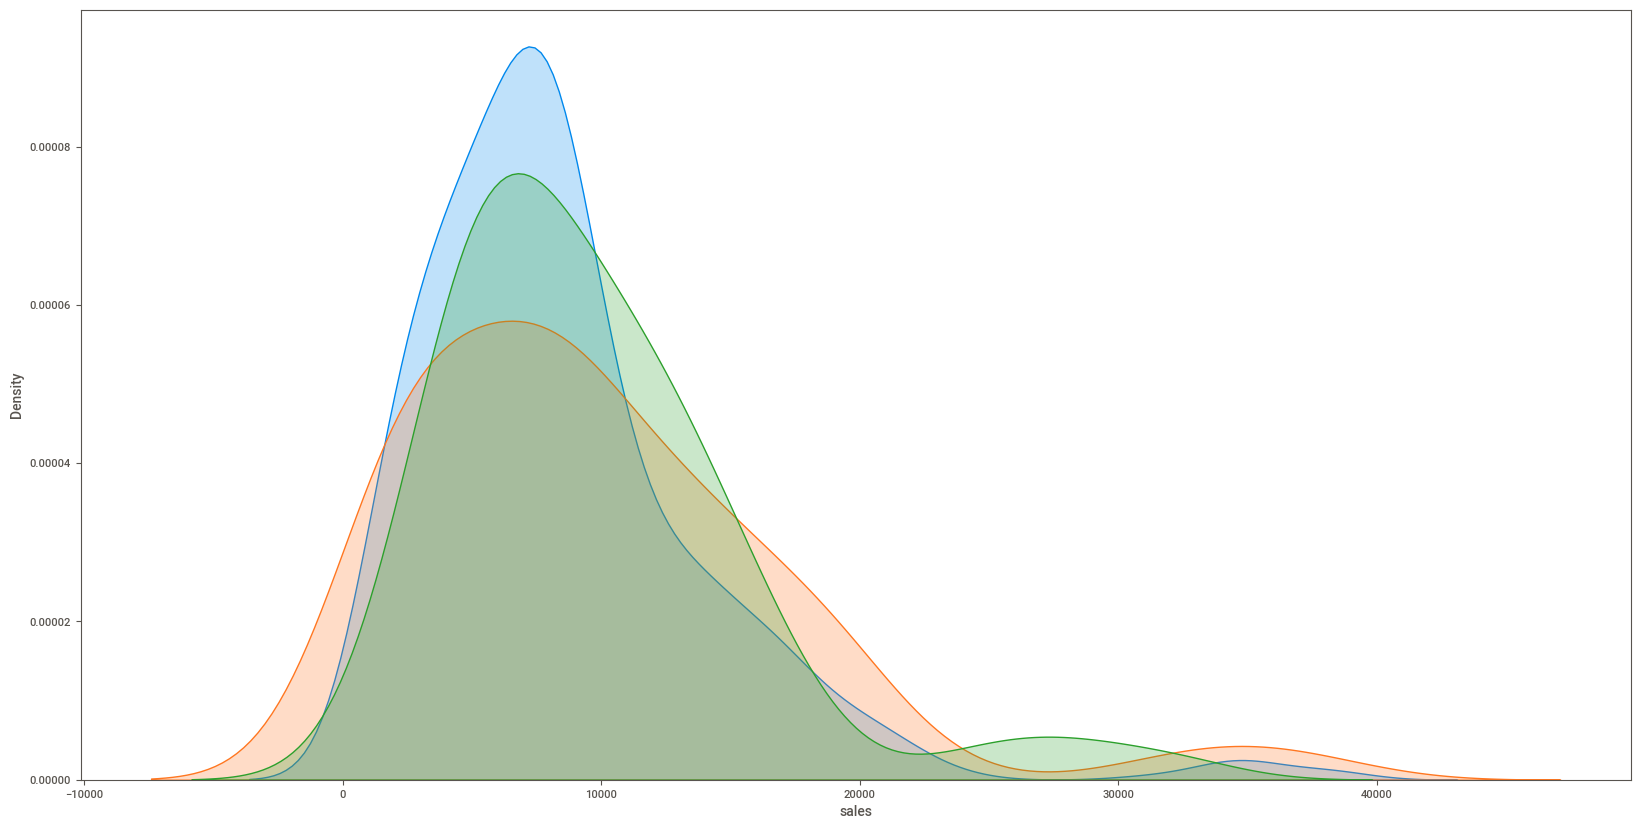

In [37]:
# state_holiday
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', fill=True )

<Axes: xlabel='store_type', ylabel='count'>

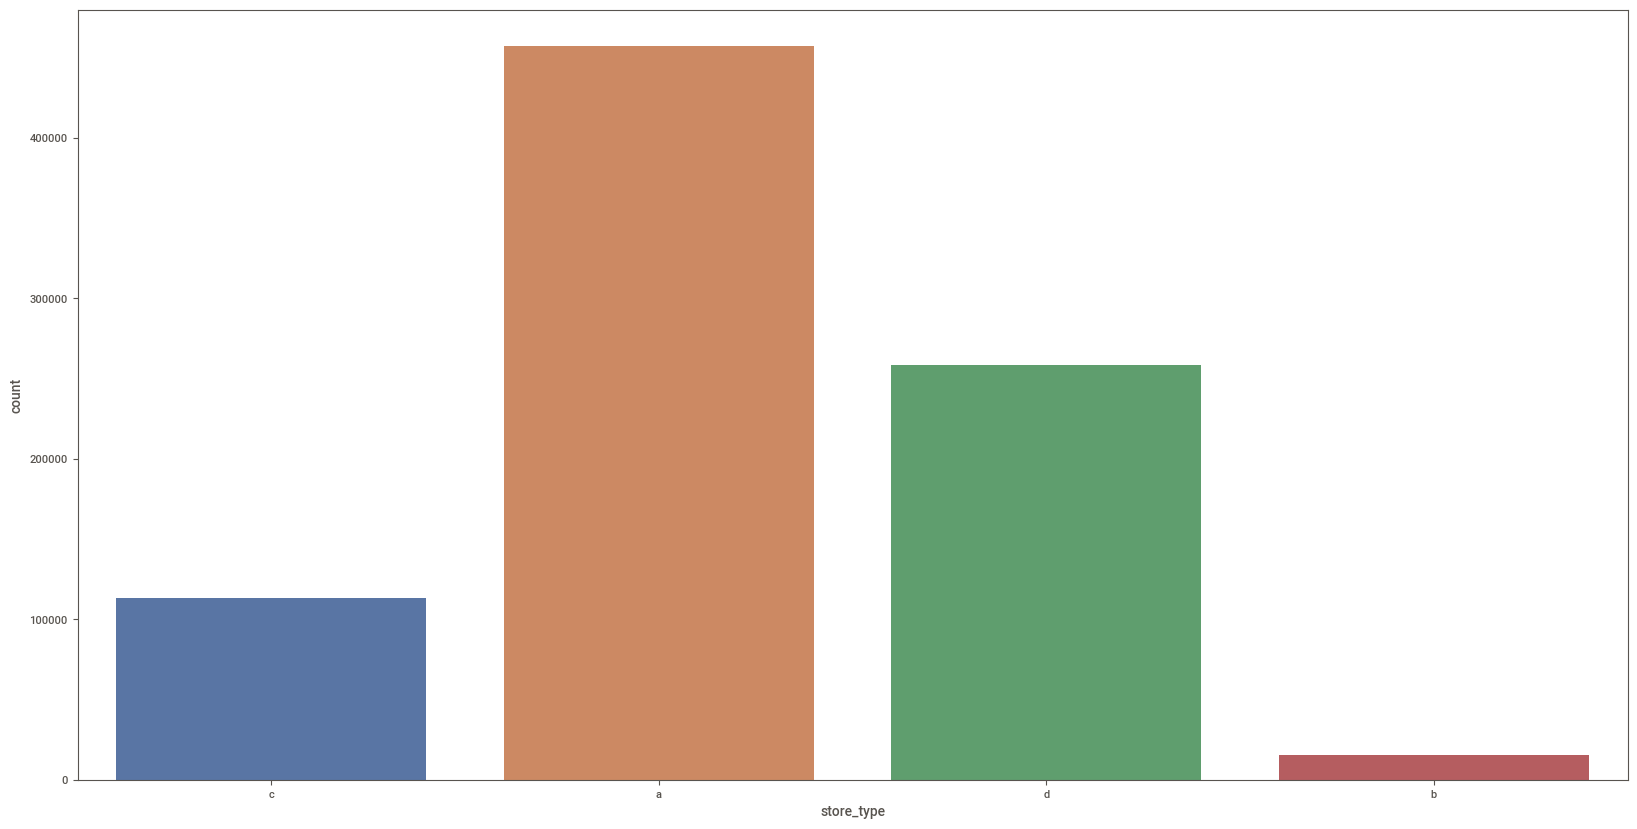

In [38]:
# store_type
sns.countplot(x=df4['store_type'],hue=df4['store_type'], palette='deep')

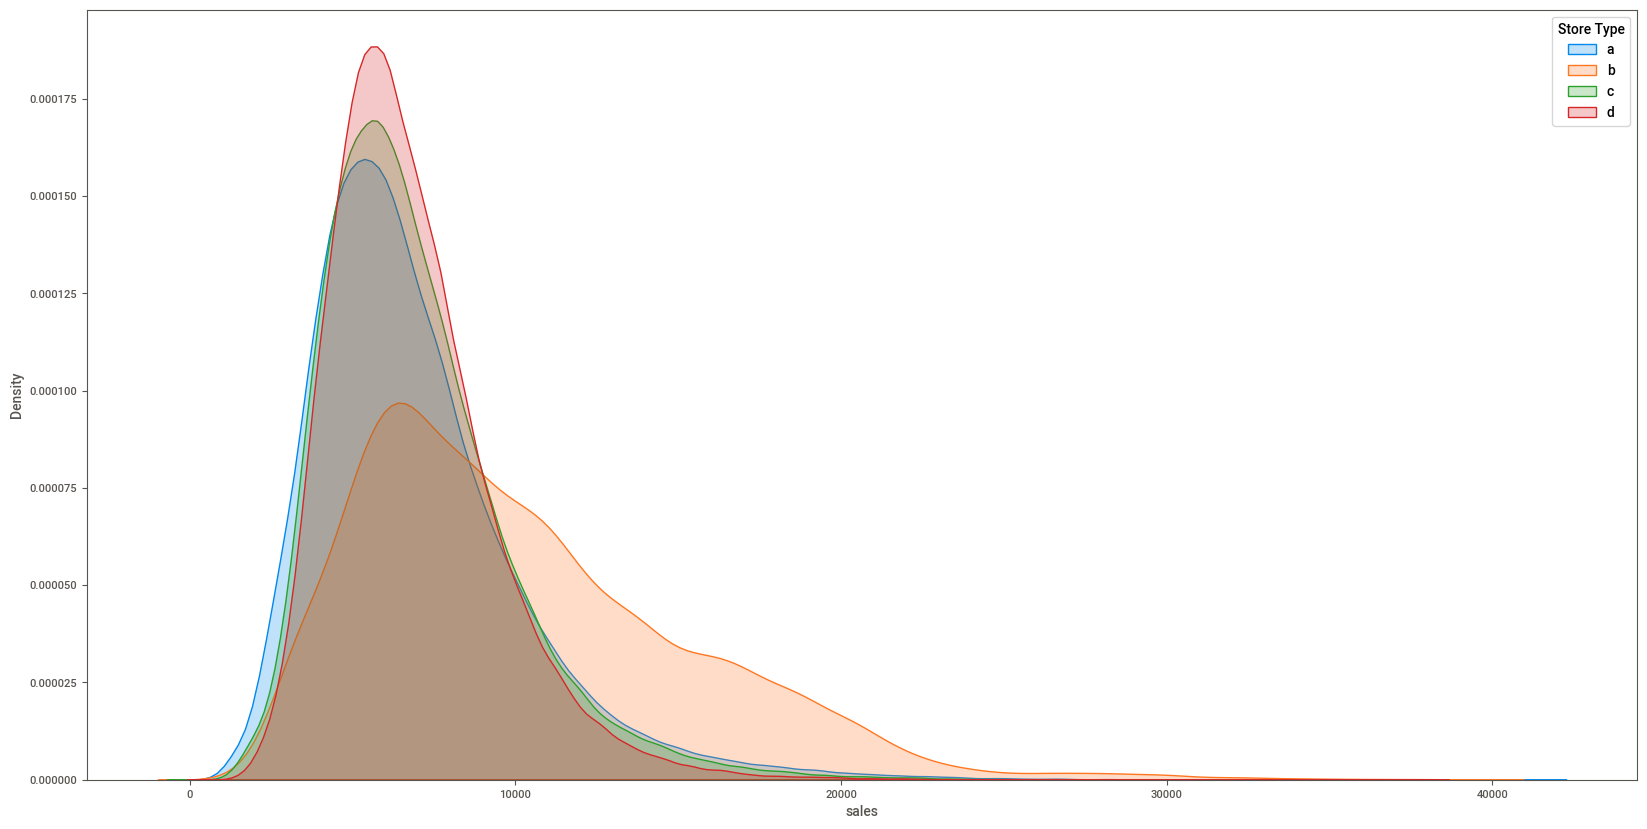

In [39]:
# store_type
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'],label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'],label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'],label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'],label='d', fill=True )
plt.legend(title='Store Type', loc='upper right')

<Axes: xlabel='assortment', ylabel='count'>

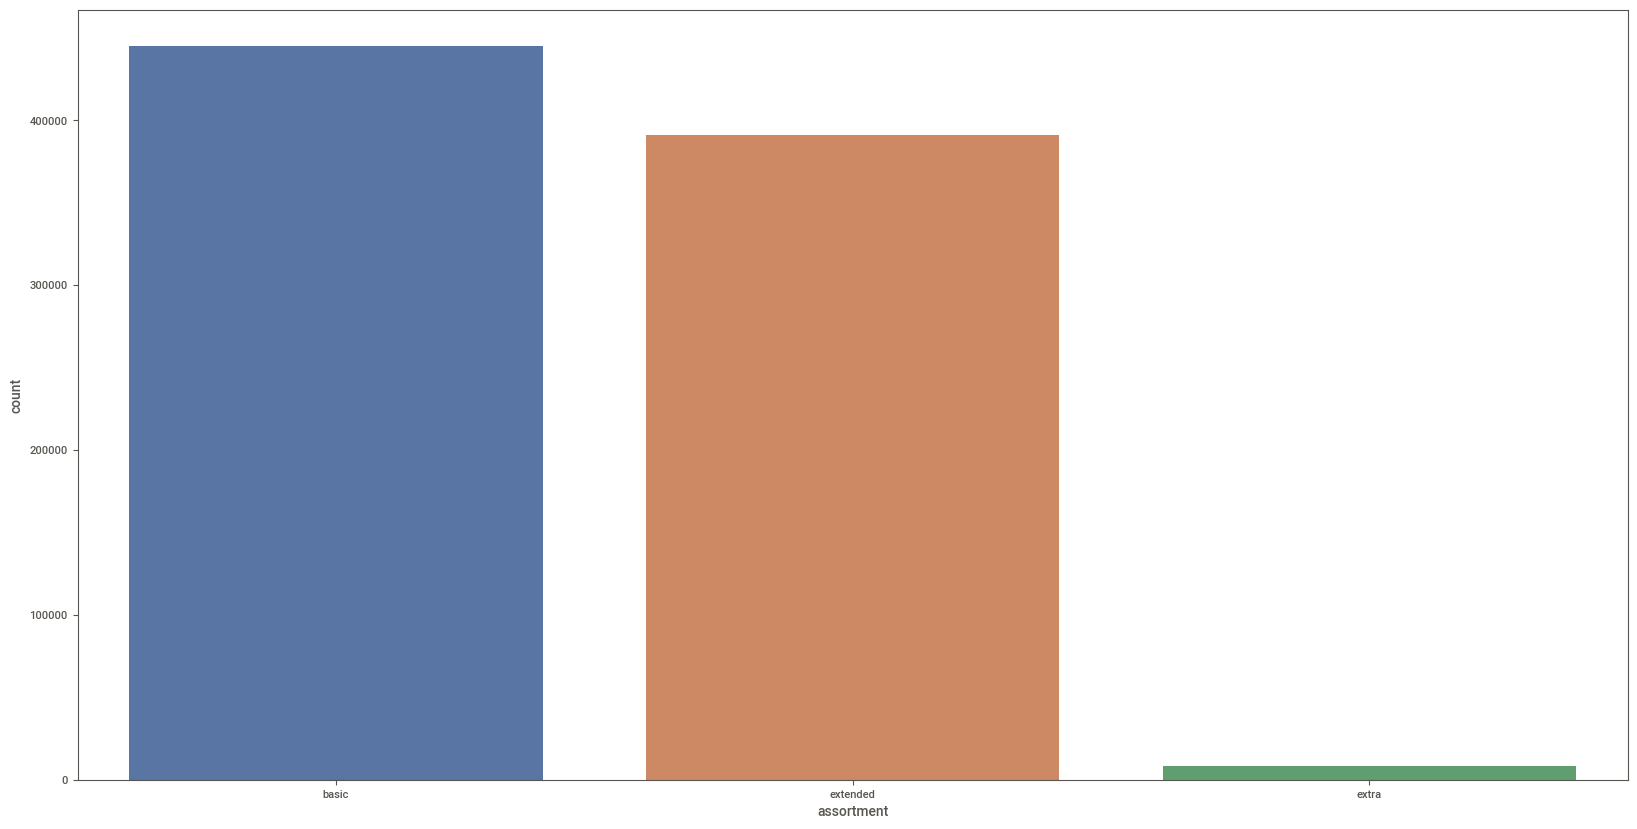

In [40]:
# assortment
sns.countplot(x=df4['assortment'], hue=df4['assortment'], palette='deep', legend=False)

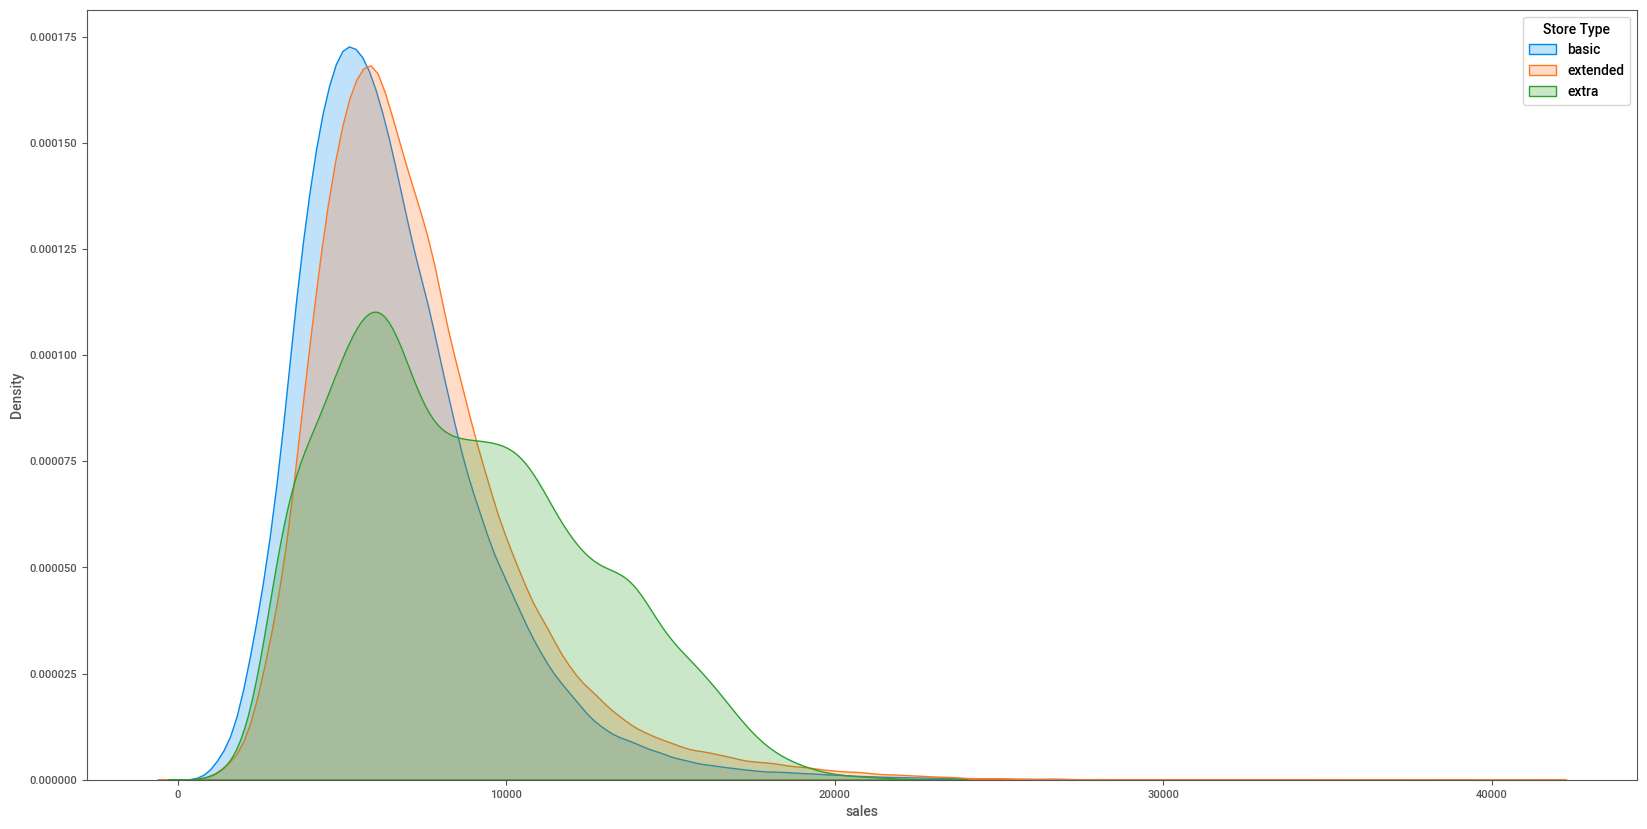

In [41]:
# assortment
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'],label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'],label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'],label='extra', fill=True )
plt.legend(title='Store Type', loc='upper right')

## 4.2 Análise Bivariada

#### 1. Lojas com maior sortimentos deveriam vender mais.

FALSO = O "Extra" (maior sortimento) vendem menos.

- De acordo com o primeiro gráfico, a loja EXTRA é a que menos vende.
- De acordo com o segundo gráfico, as lojas BASIC e EXTENDED possuem variação de mensal mensal muito parecidos de uma com a outra.
- De acordo com o segundo gráfico, a variação de vendas das lojas EXTRA nãoé linear como mostra os segundo gráfico.

<Axes: xlabel='year_week'>

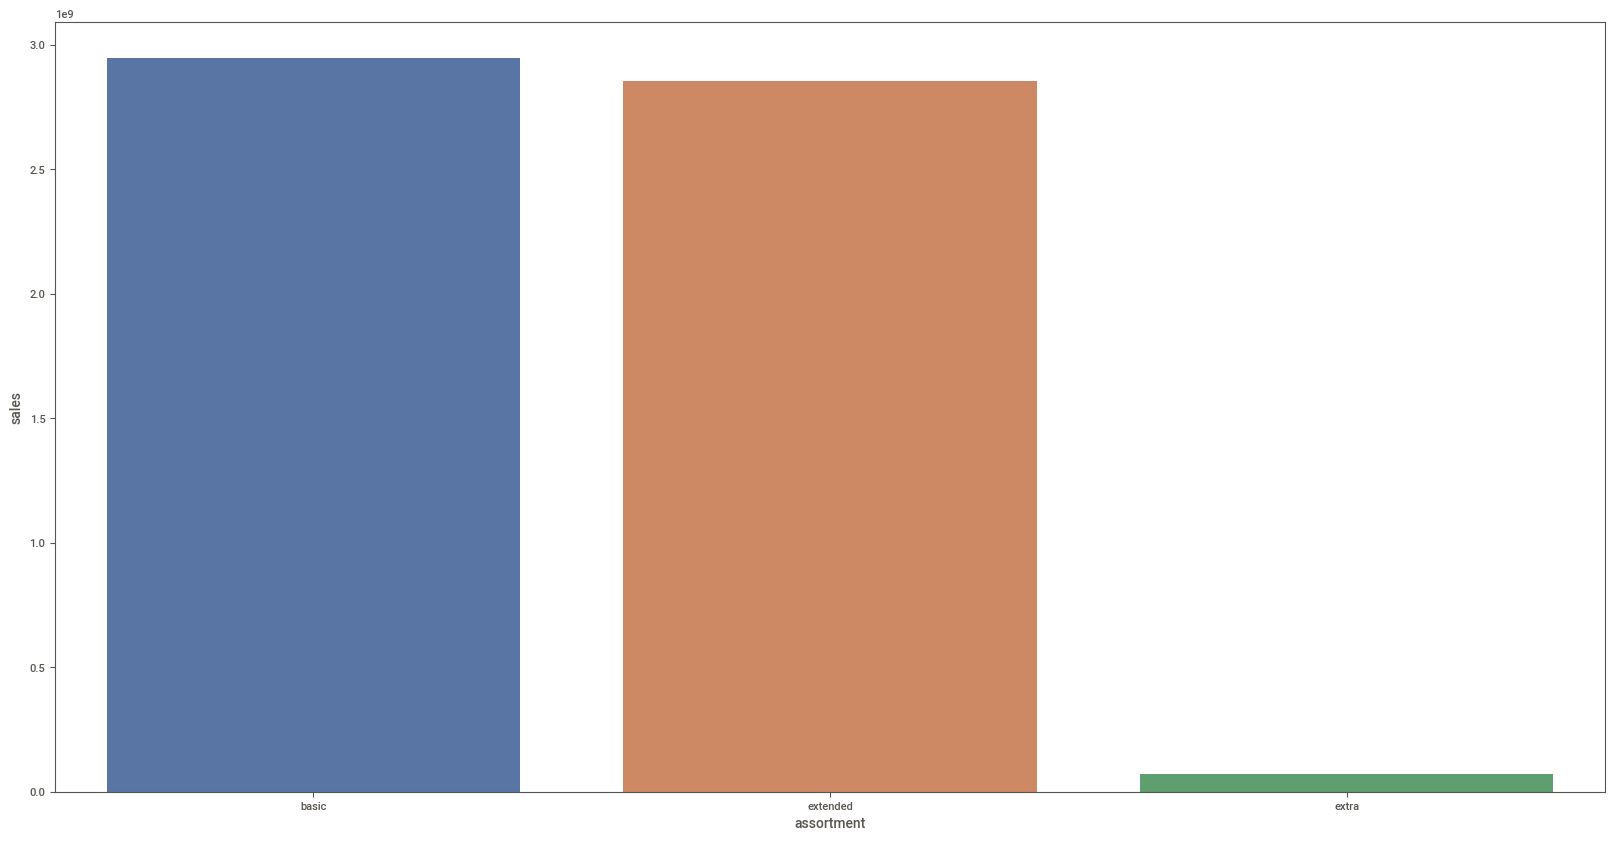

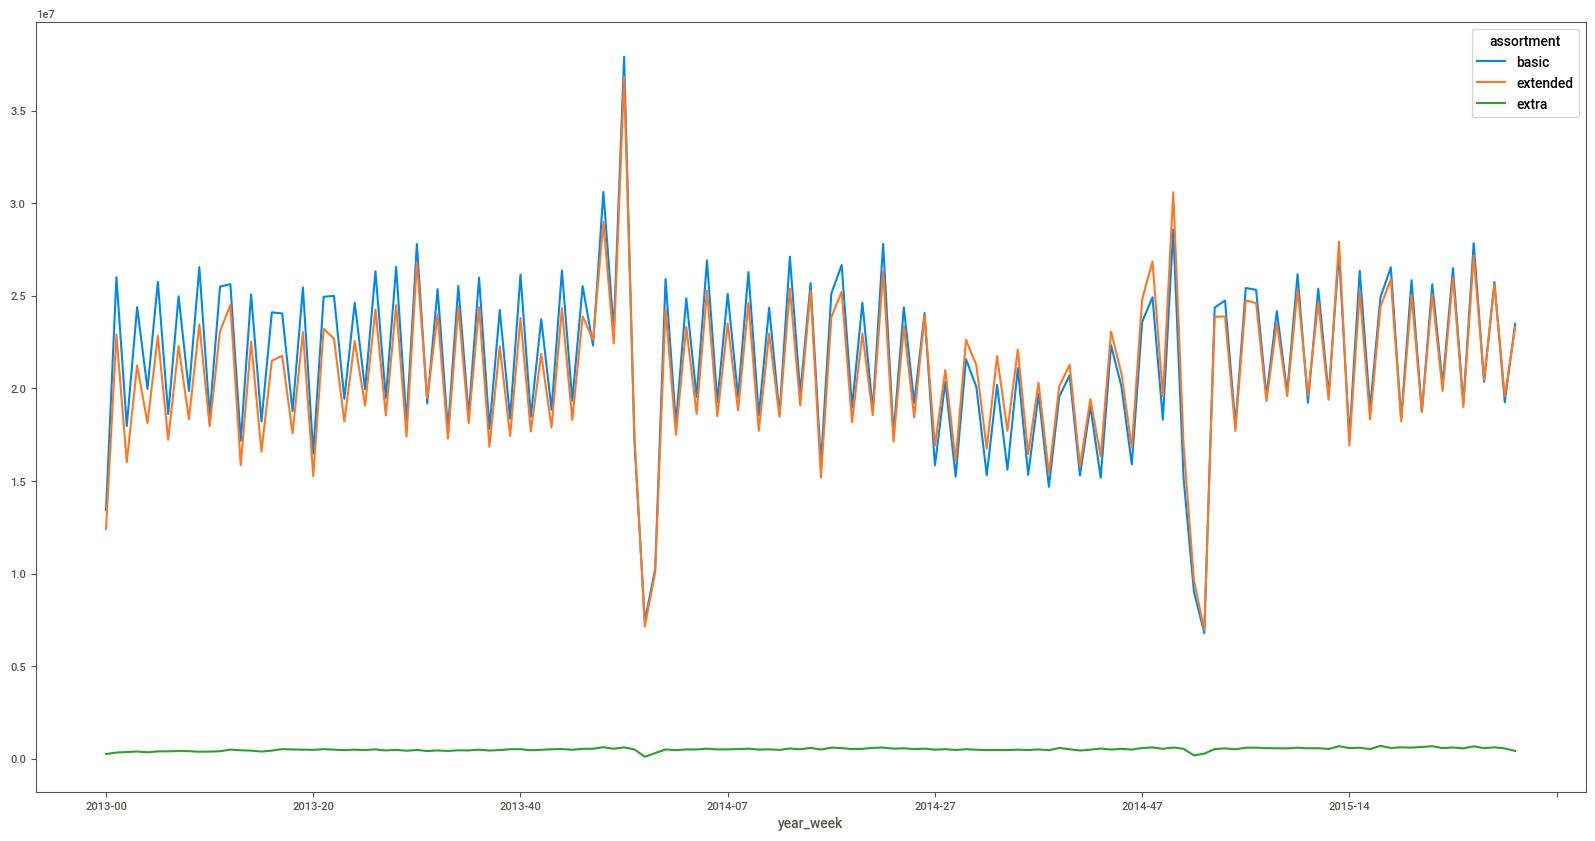

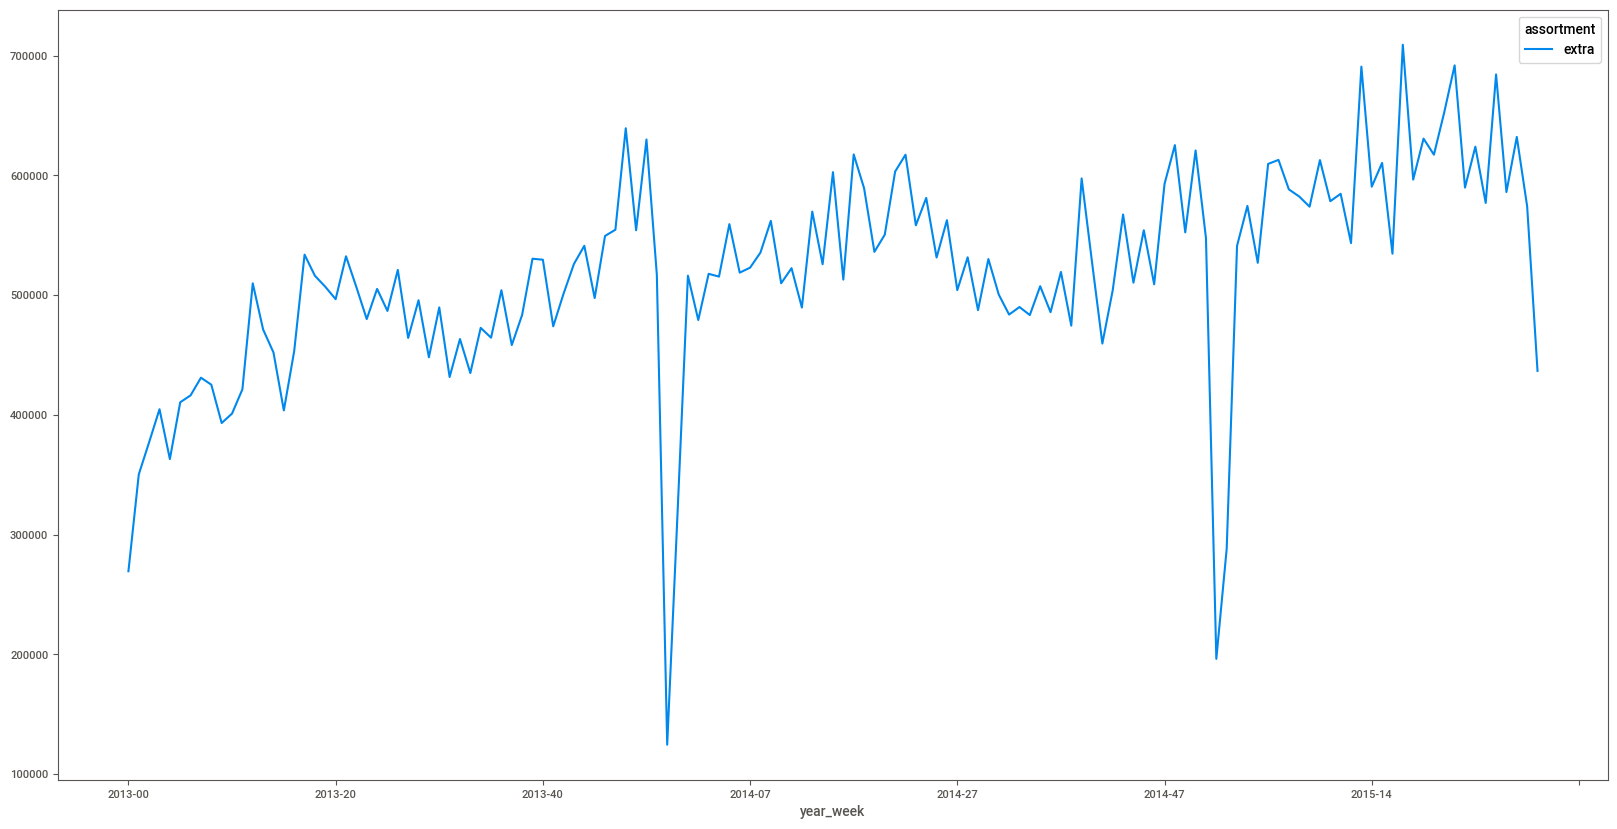

In [42]:
# total de vendas por sortimento
h1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(h1, x='assortment', y='sales',hue='assortment', palette='deep', legend=False)


# grafico em linha de vendas mensal
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

# grafico em linha de vendas mensal apenas a linha "extra"
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

#### 2. Lojas com competidores mais próximos deveriam vender menos.

FALSO = Lojas mais próximas vendem mais

- Maior quantidade de vendas são as lojas com distâncias de até 1 Km

<Axes: xlabel='competition_distance', ylabel='sales'>

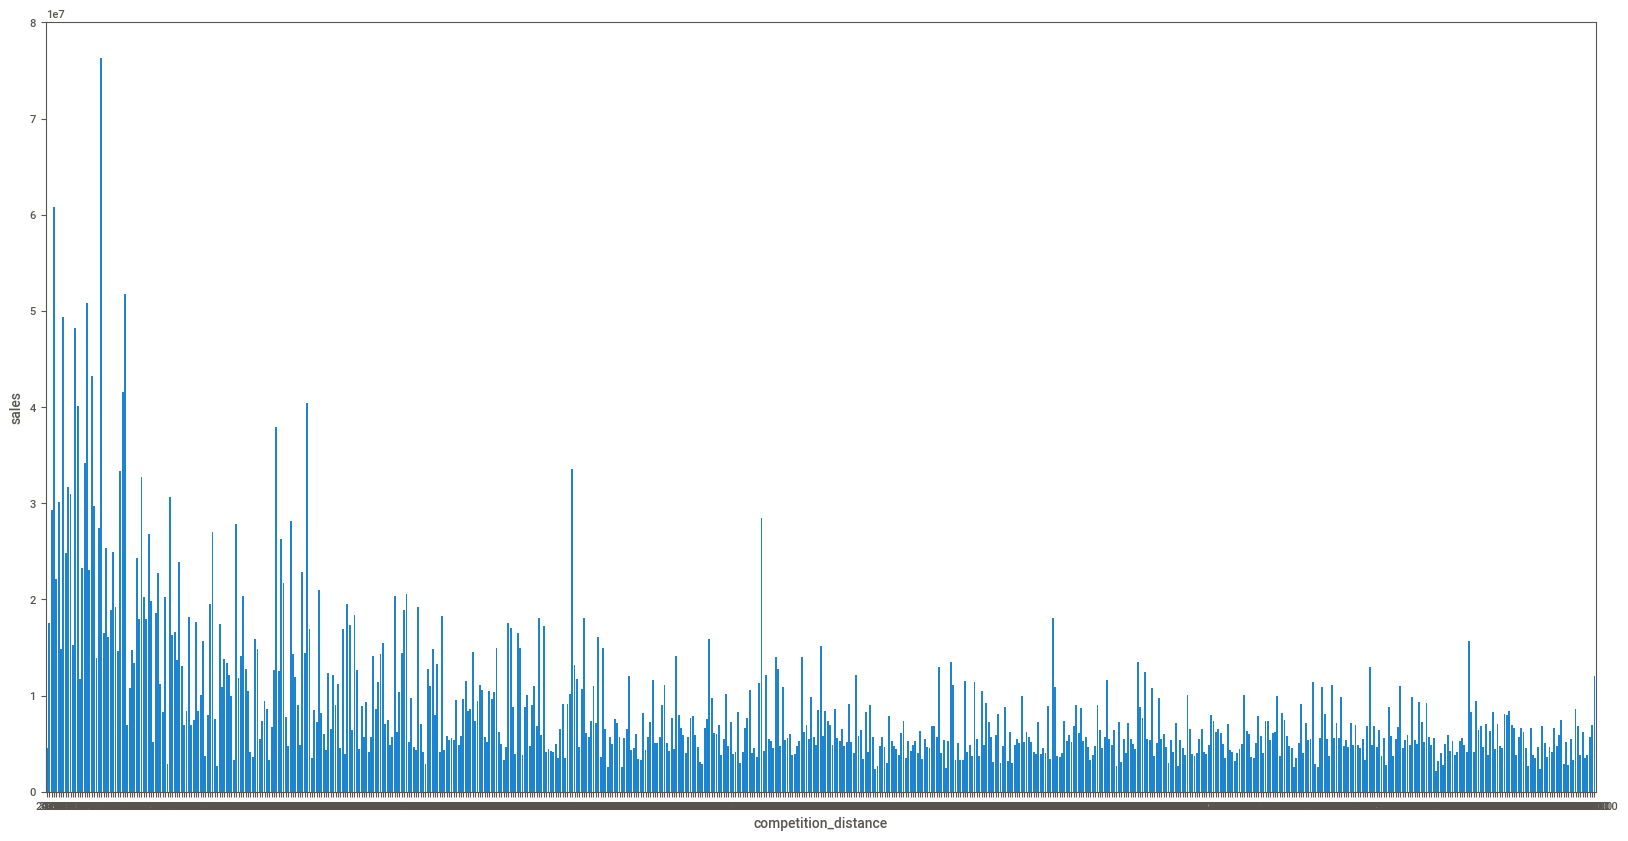

In [43]:
h2 =  df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.barplot(h2, x='competition_distance', y='sales')

C:\Users\alexa\AppData\Local\Temp\ipykernel_12832\696445158.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  h21 = h2[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()


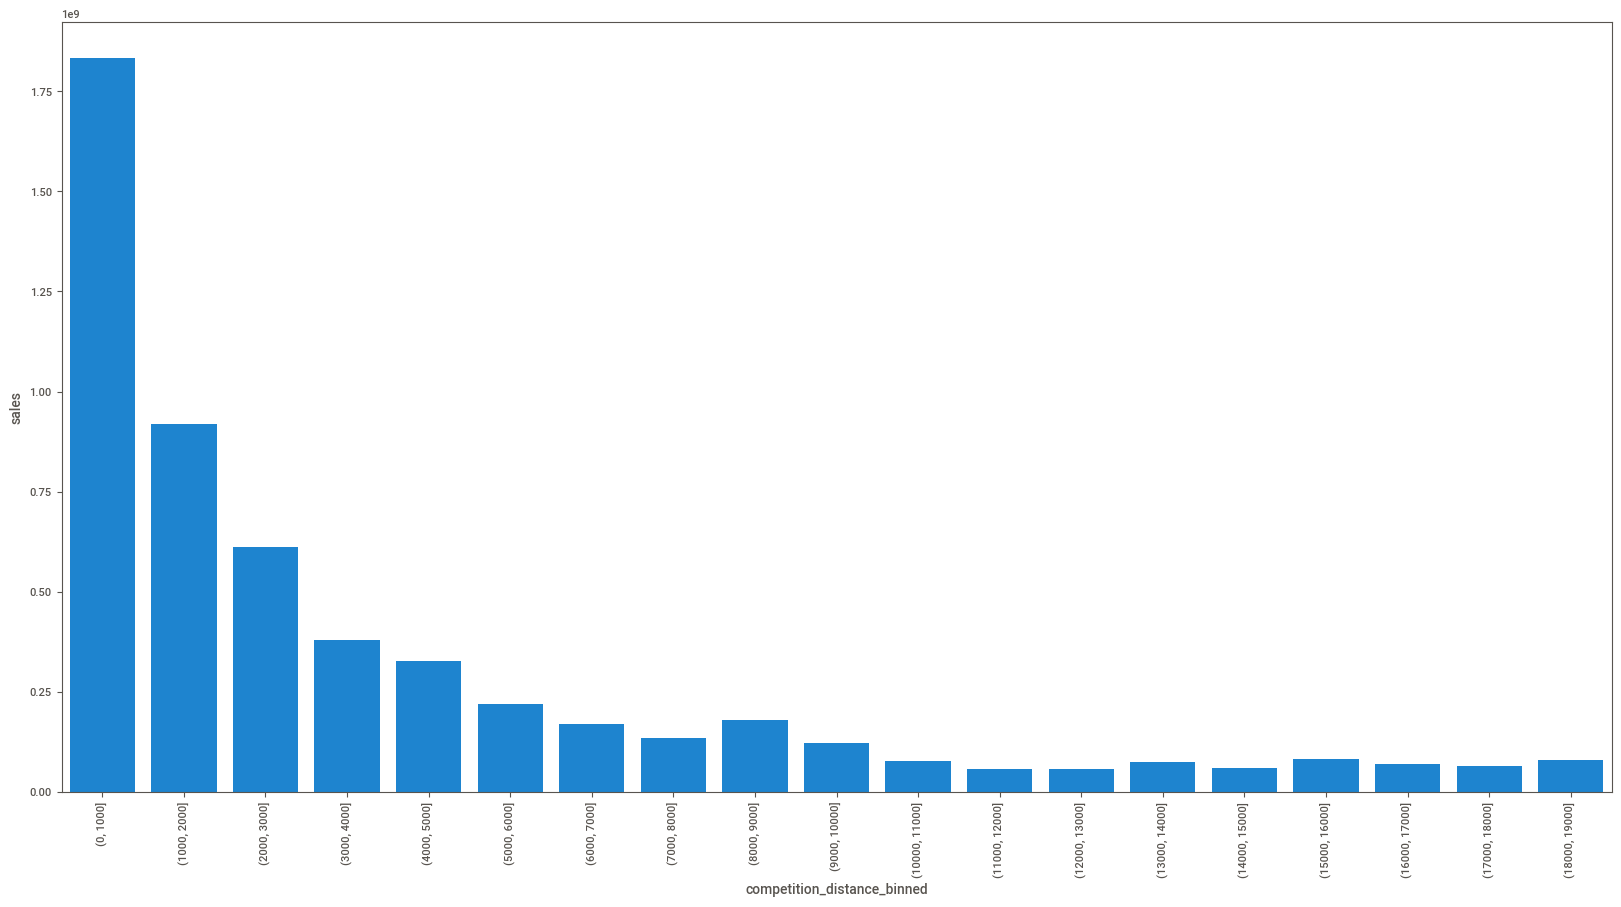

In [44]:
#criando bins
bins = list( np.arange( 0, 20000, 1000) )
h2['competition_distance_binned'] = pd.cut( h2['competition_distance'],bins=bins )

h21 = h2[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=h21 )
plt.xticks( rotation=90 );

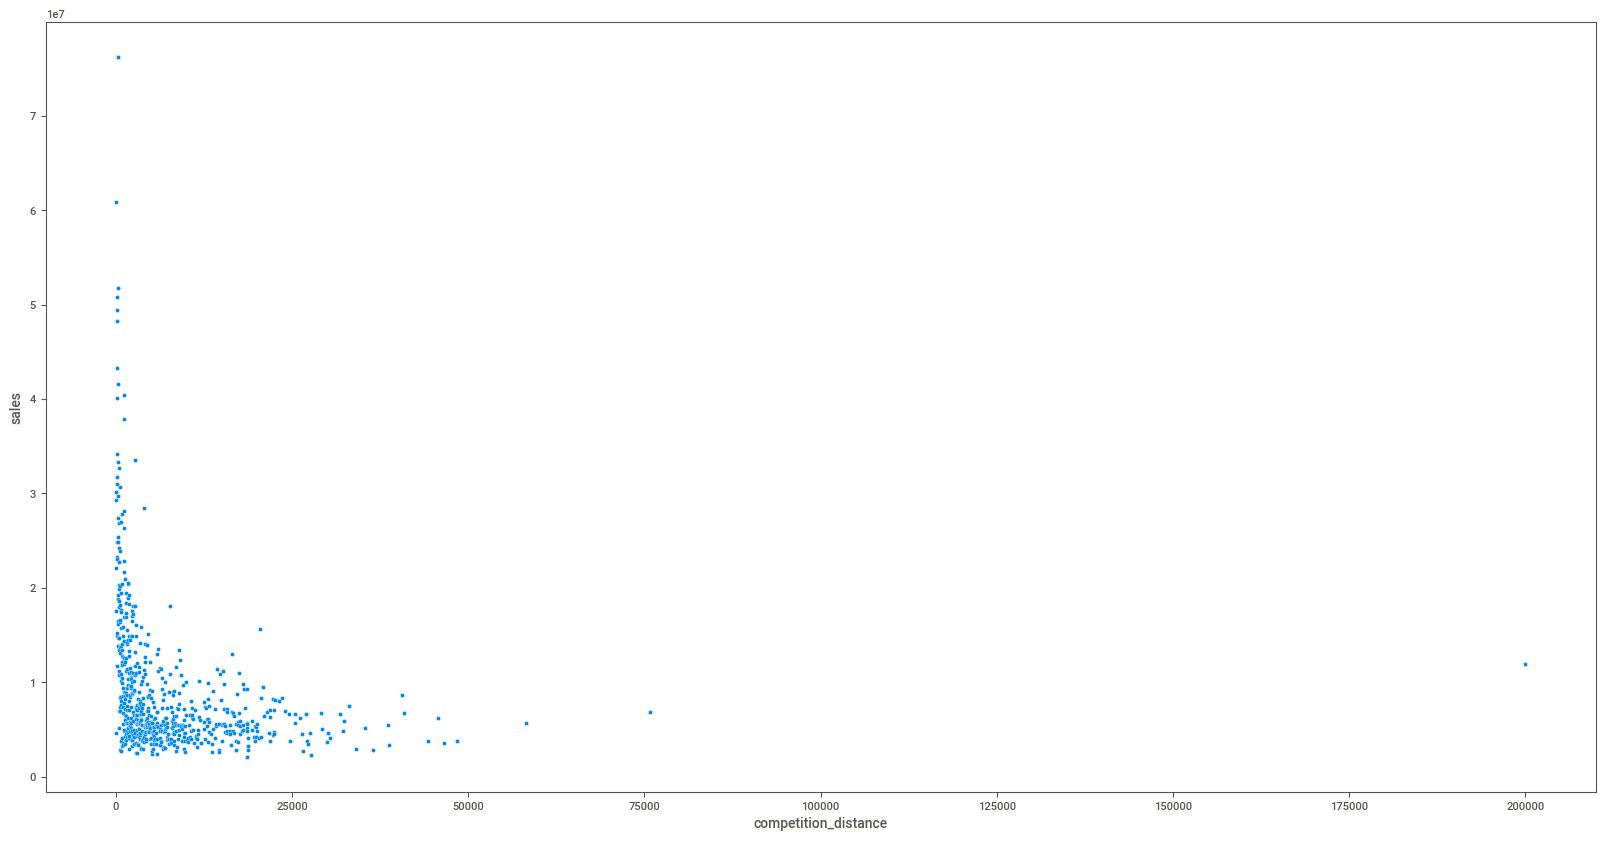

In [45]:
#grafico de bolinhas
h2 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
sns.scatterplot( x ='competition_distance', y='sales', data=h2 );

<Axes: >

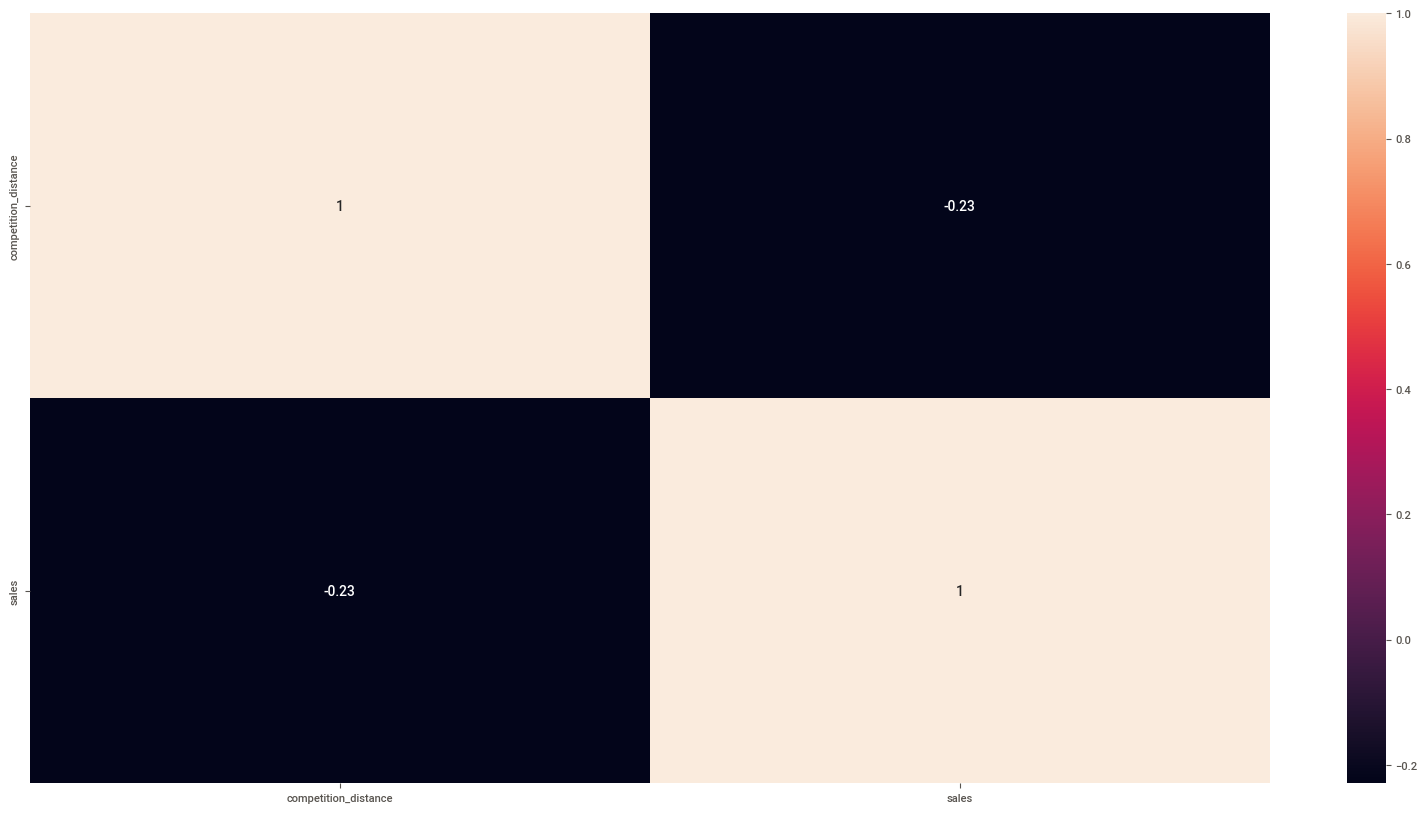

In [46]:
#Força da correlação
sns.heatmap( h2.corr( method='pearson'), annot=True )

#### 3. Lojas com competidores à mais tempo deveriam vendem mais.

FALSO = Lojas com competidores à mais tempo vendem menos

Em competition_time_month, o resultado é a Data da venda - Data da abertura do competidor.
- Valores negativos -> Competidor abriu depois da venda
- Valores positivos -> Competidor abriu antes da venda

O Gráfico informa que quanto mais recente é a competição, maior é a venda

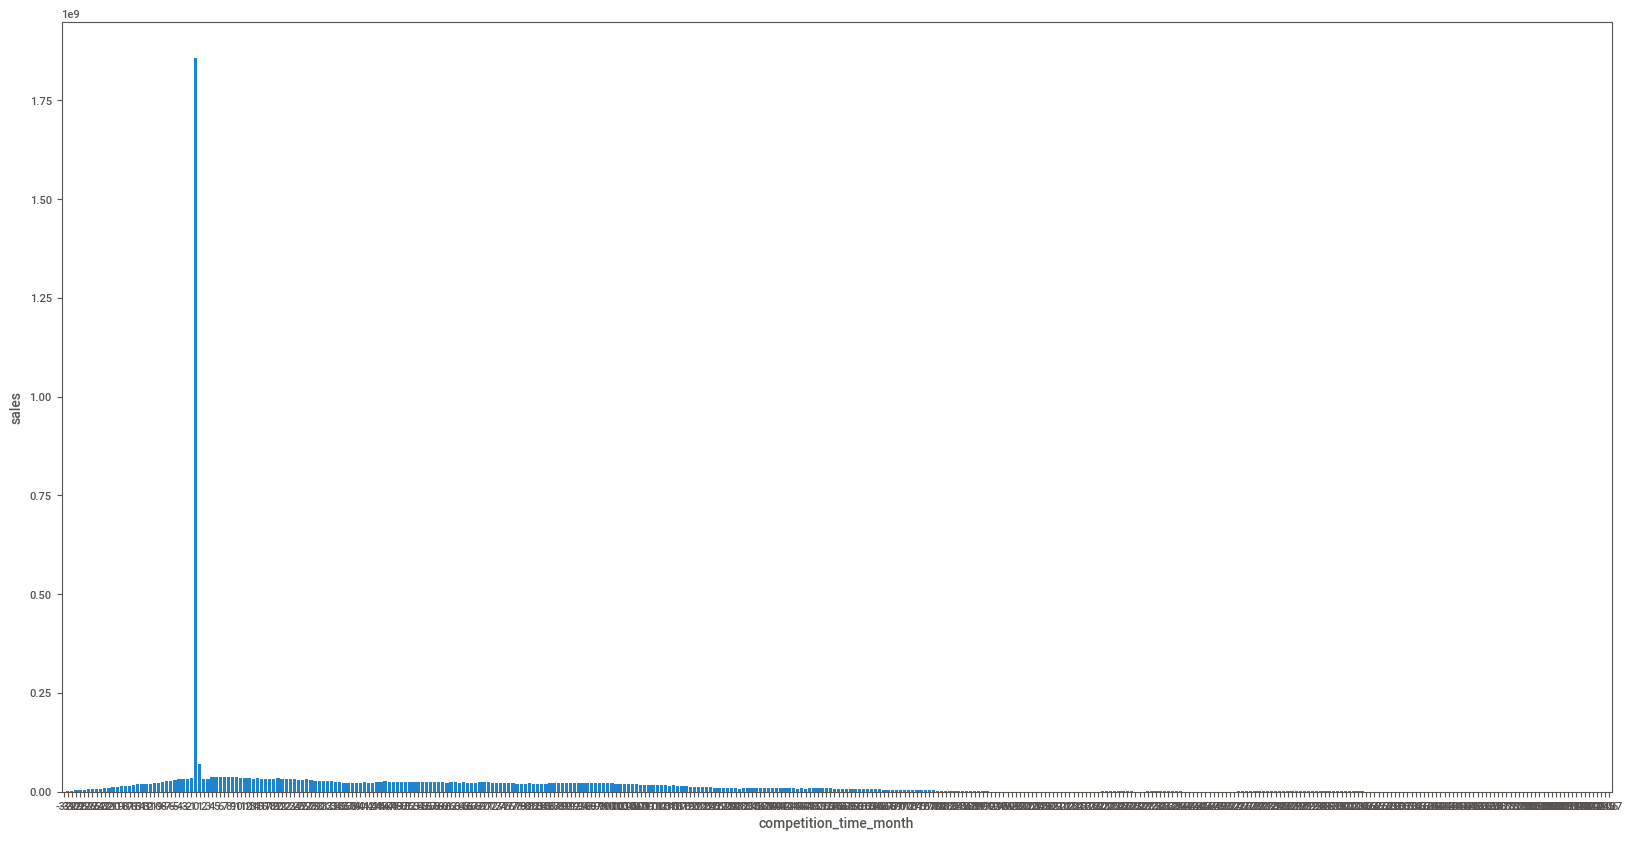

In [47]:
h3 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
sns.barplot( h3, x='competition_time_month', y='sales');

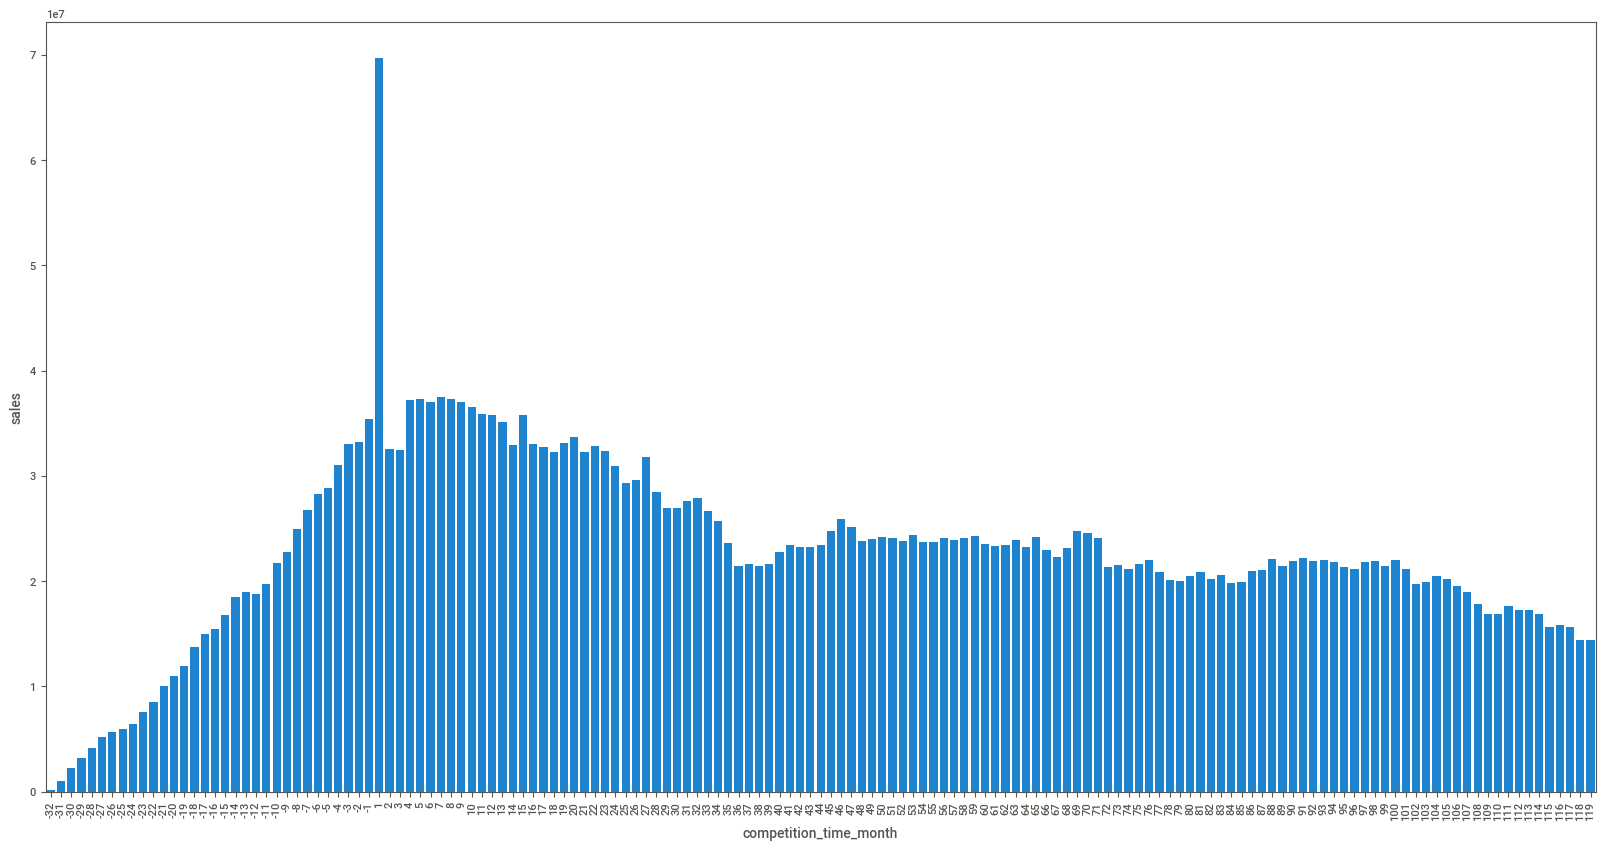

In [48]:
h3 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
h31 = h3[( h3['competition_time_month'] < 120 ) & (h3['competition_time_month'] != 0 )]
sns.barplot( h31, x='competition_time_month', y='sales', );
plt.xticks( rotation=90 );

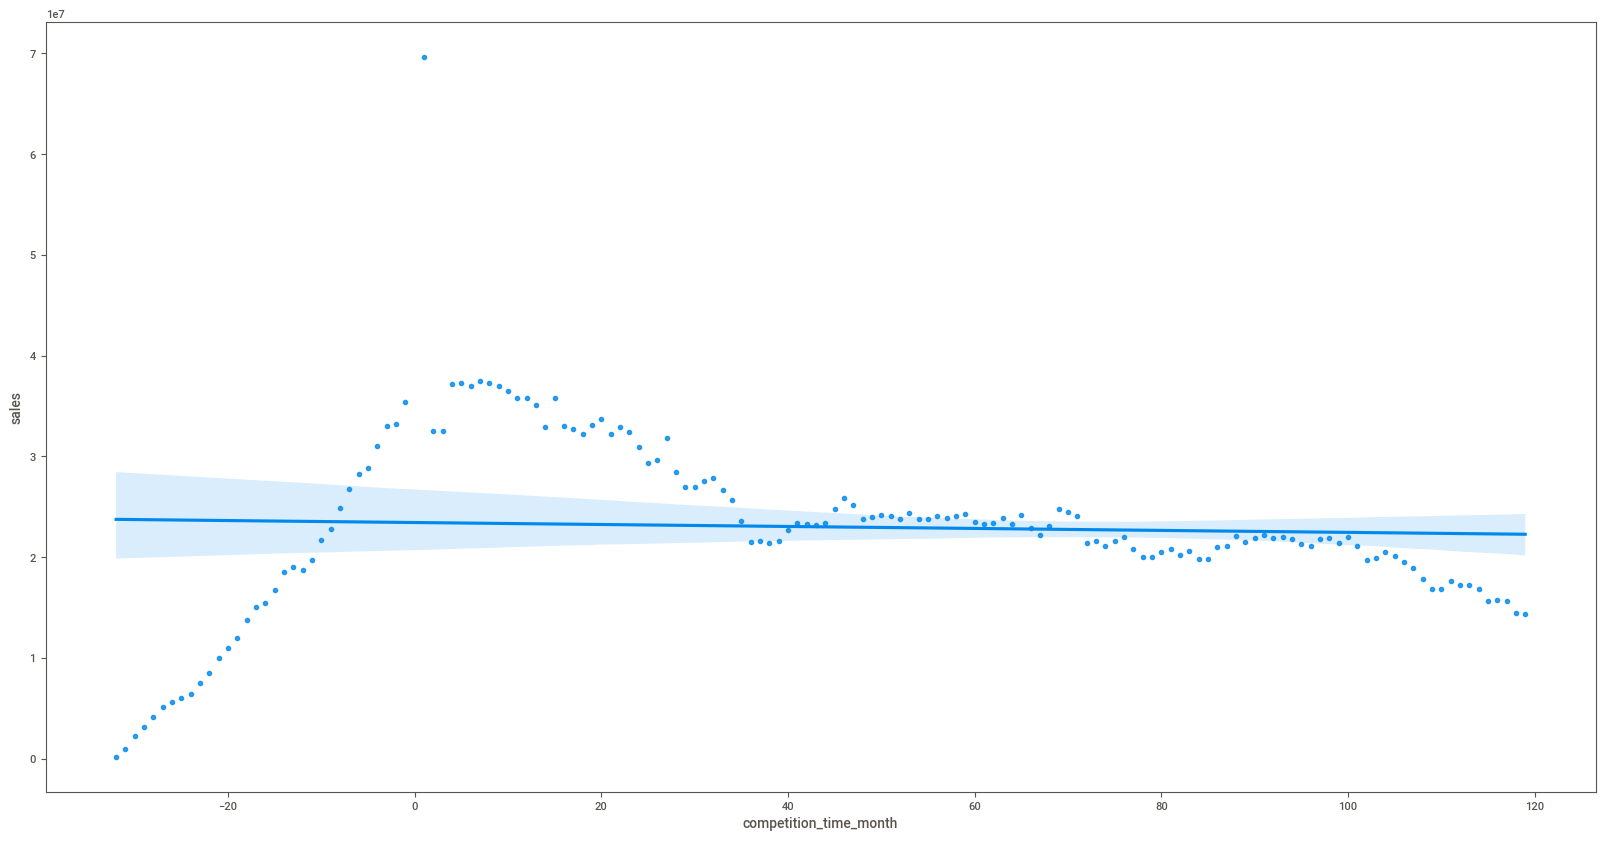

In [49]:
#grafico de regplot
sns.regplot( h31, x ='competition_time_month', y='sales');

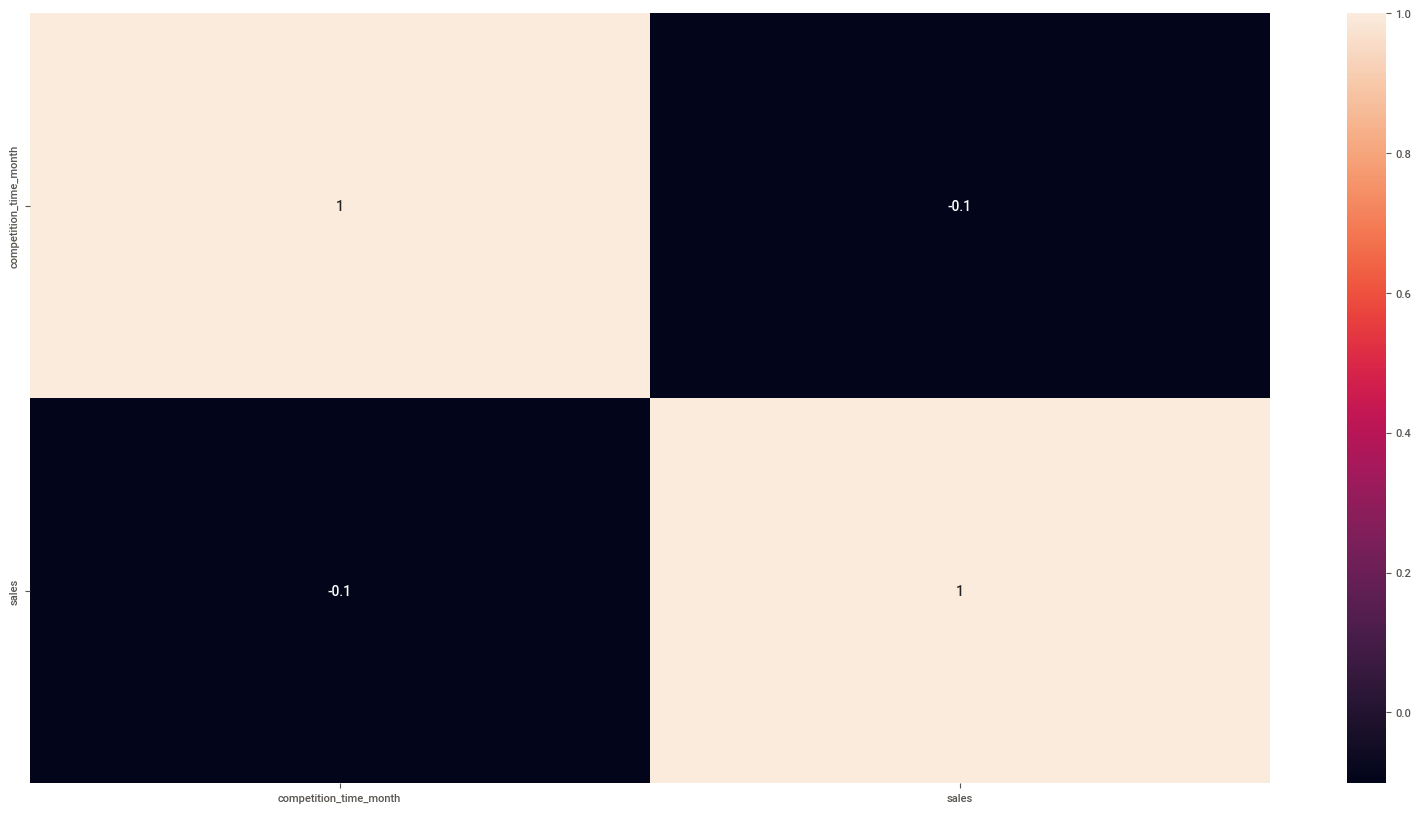

In [50]:
#Força da correlação
sns.heatmap( h3.corr( method='pearson' ), annot=True );

4. Lojas com promoções ativas por mais tempo deveriam vender mais.

FALSO = Lojas com promoções ativas por mais tempo vendem menos

- Valores negativo -> Venda realizada dentro do periodo tradicional de promoção
- Valores positivo -> Venda realizada dentro do periodo de promoção extendida

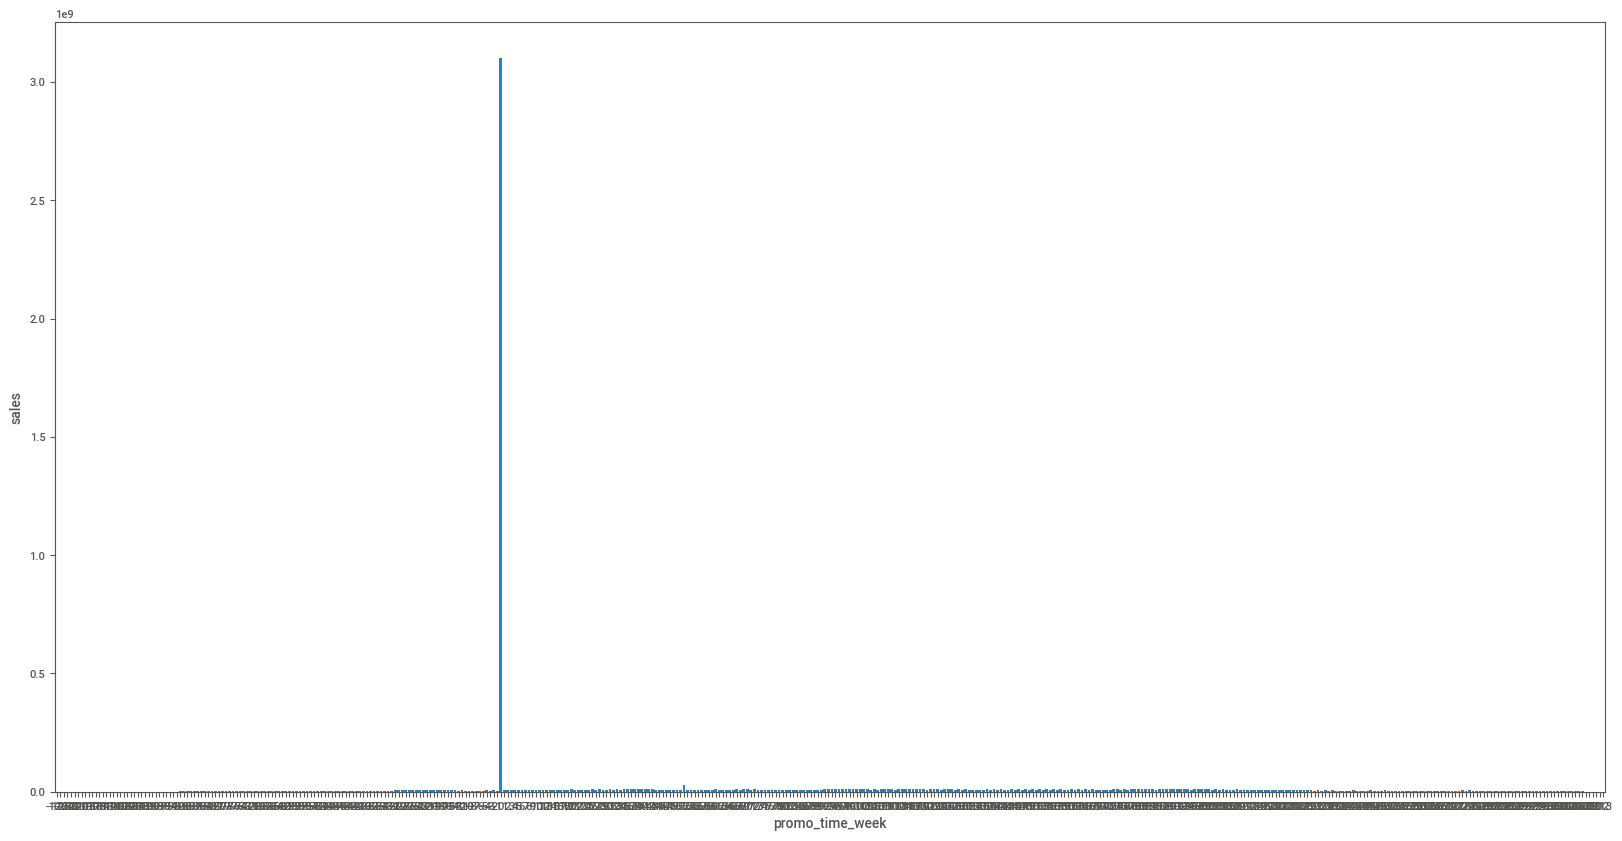

In [51]:
h4 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()
sns.barplot( h4, x='promo_time_week', y='sales');

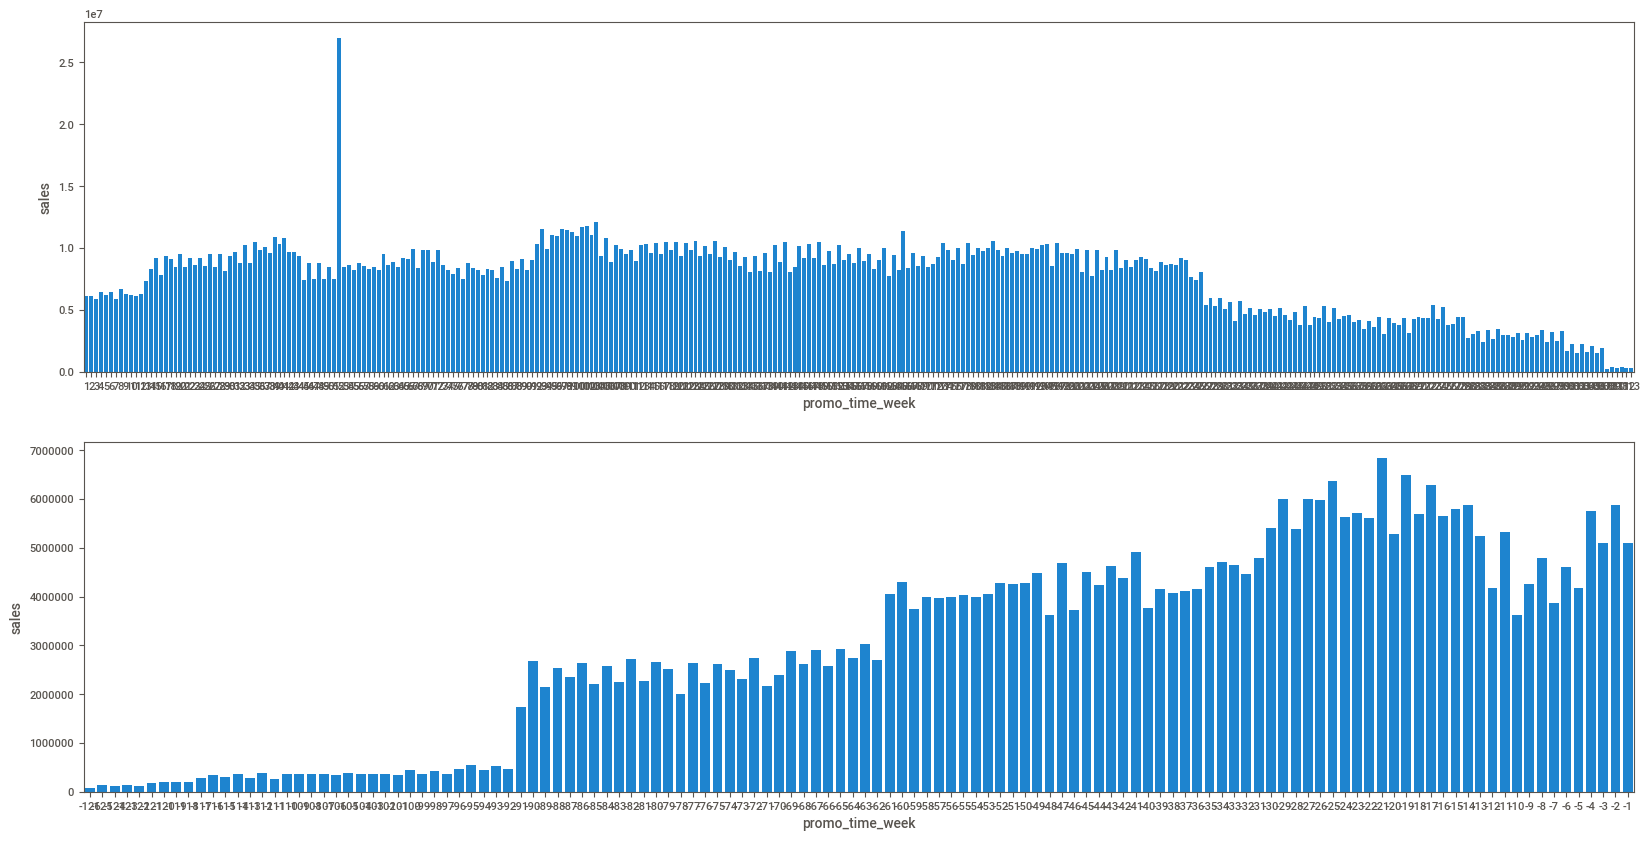

In [52]:
plt.subplot(2,1,1)
extendido = h4[h4['promo_time_week']>0] # promoção extendida
sns.barplot( extendido, x='promo_time_week', y='sales');
# as vendas caem conforme o tempo de promoção

plt.subplot(2,1,2)
regular = h4[h4['promo_time_week']<0] # promoção regular
sns.barplot( regular, x='promo_time_week', y='sales');

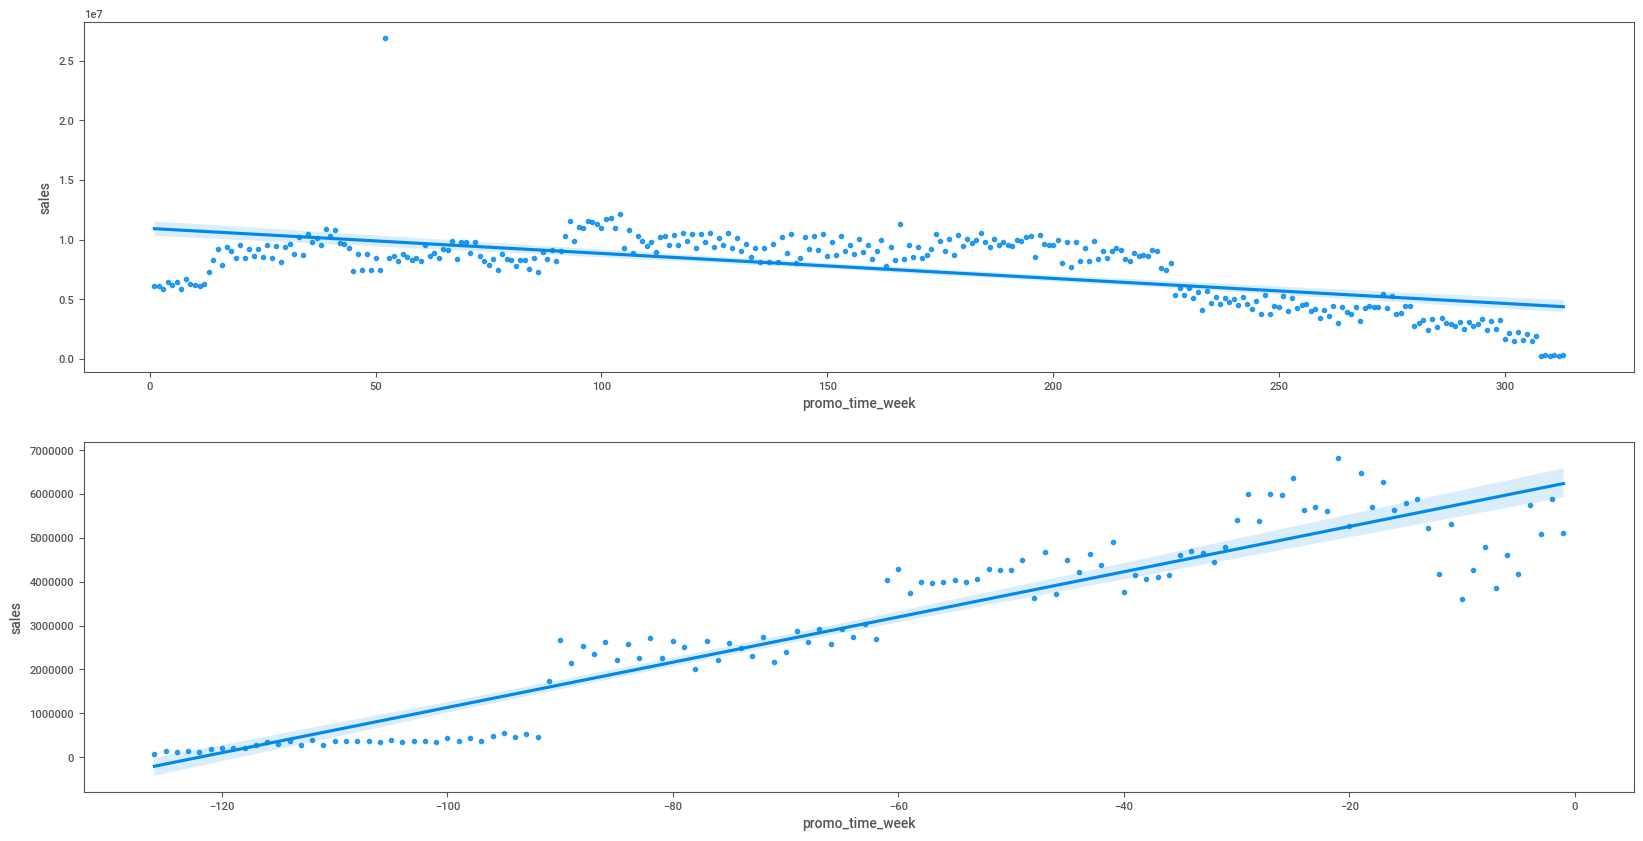

In [53]:
#grafico de bolinhas
plt.subplot(2,1,1)
sns.regplot( extendido, x='promo_time_week', y='sales');
plt.subplot(2,1,2)
sns.regplot( regular, x='promo_time_week', y='sales');

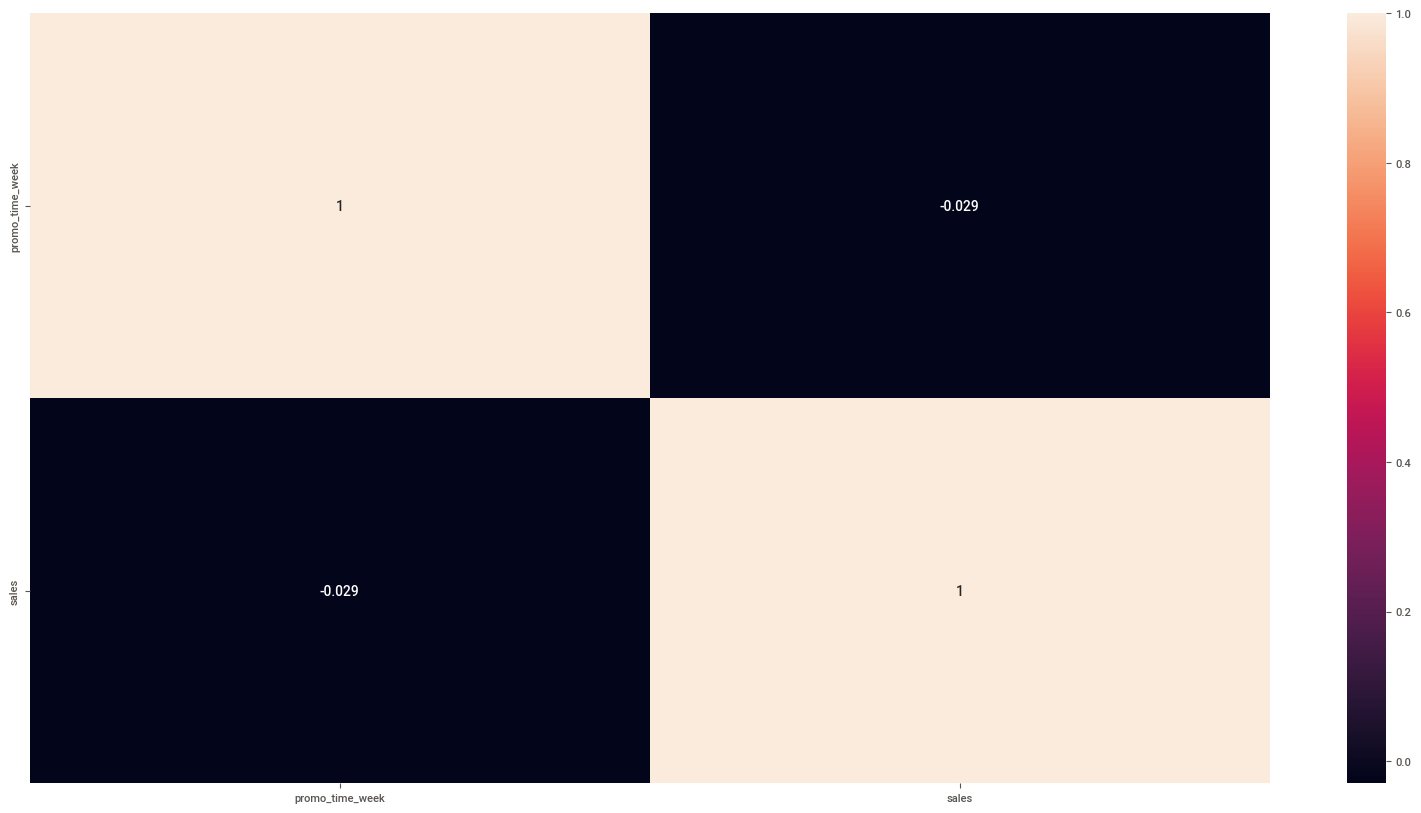

In [54]:
#Força da correlação
sns.heatmap( h4.corr( method='pearson' ), annot=True );
# para o heatmap precisa ser passado a feature inteira e não quebrada.

<s>5. Lojas com mais dias de promoção deveriam vender mais.</s>

6. Lojas com mais promoções consecutivas deveriam vender mais.

FALSA = Lojas com mais promoções consecutivas vendem menos

- Verificado que quem participou da promoção extendida (promo2) vendeu menos.

In [55]:
h5 = df4[['promo','promo2', 'sales']].groupby(['promo','promo2']).sum().sort_values('sales', ascending=False).reset_index()
h5


promo  promo2       sales
0      1       0  1628930532
1      0       0  1482612096
2      1       1  1472275754
3      0       1  1289362241

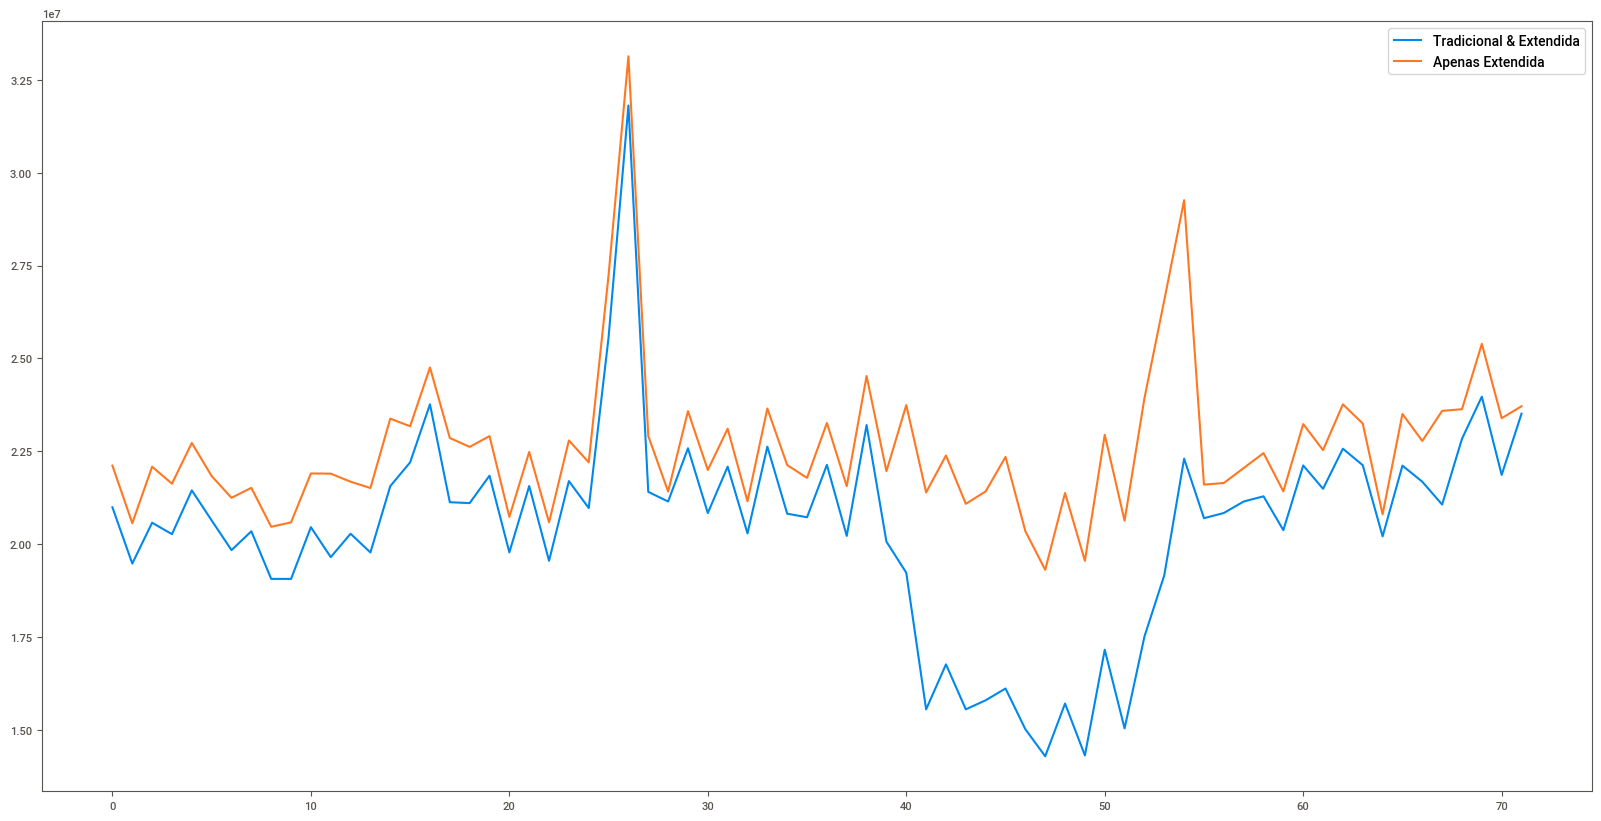

In [56]:
# Verifiar comportamento durante o tempo

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()

aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Apenas Extendida']);

7. Lojas abertas durante o feriado de Natal deveriam vender mais.

FALSA = Lojas abertas durante o feriado de Natal não vendem mais do que os outros feriados

- Dentro os feriadados,o feriado de Natal é o que menos vende, em nenhum ano.

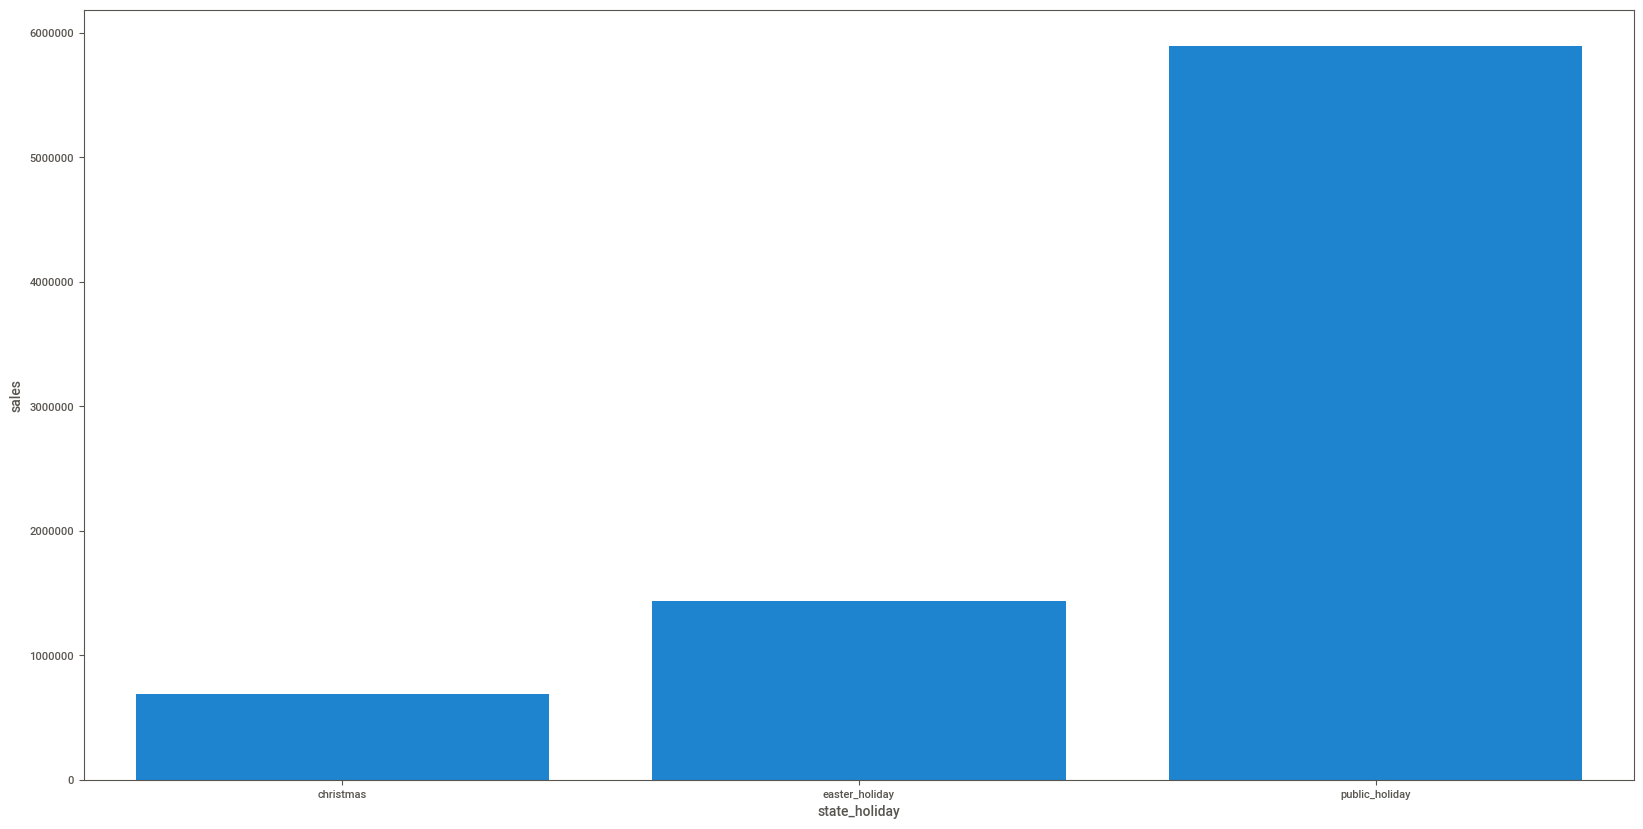

In [60]:
a1 = df4[df4['state_holiday'] != 'regular_day']
h7 = a1[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( h8, x='state_holiday', y='sales');

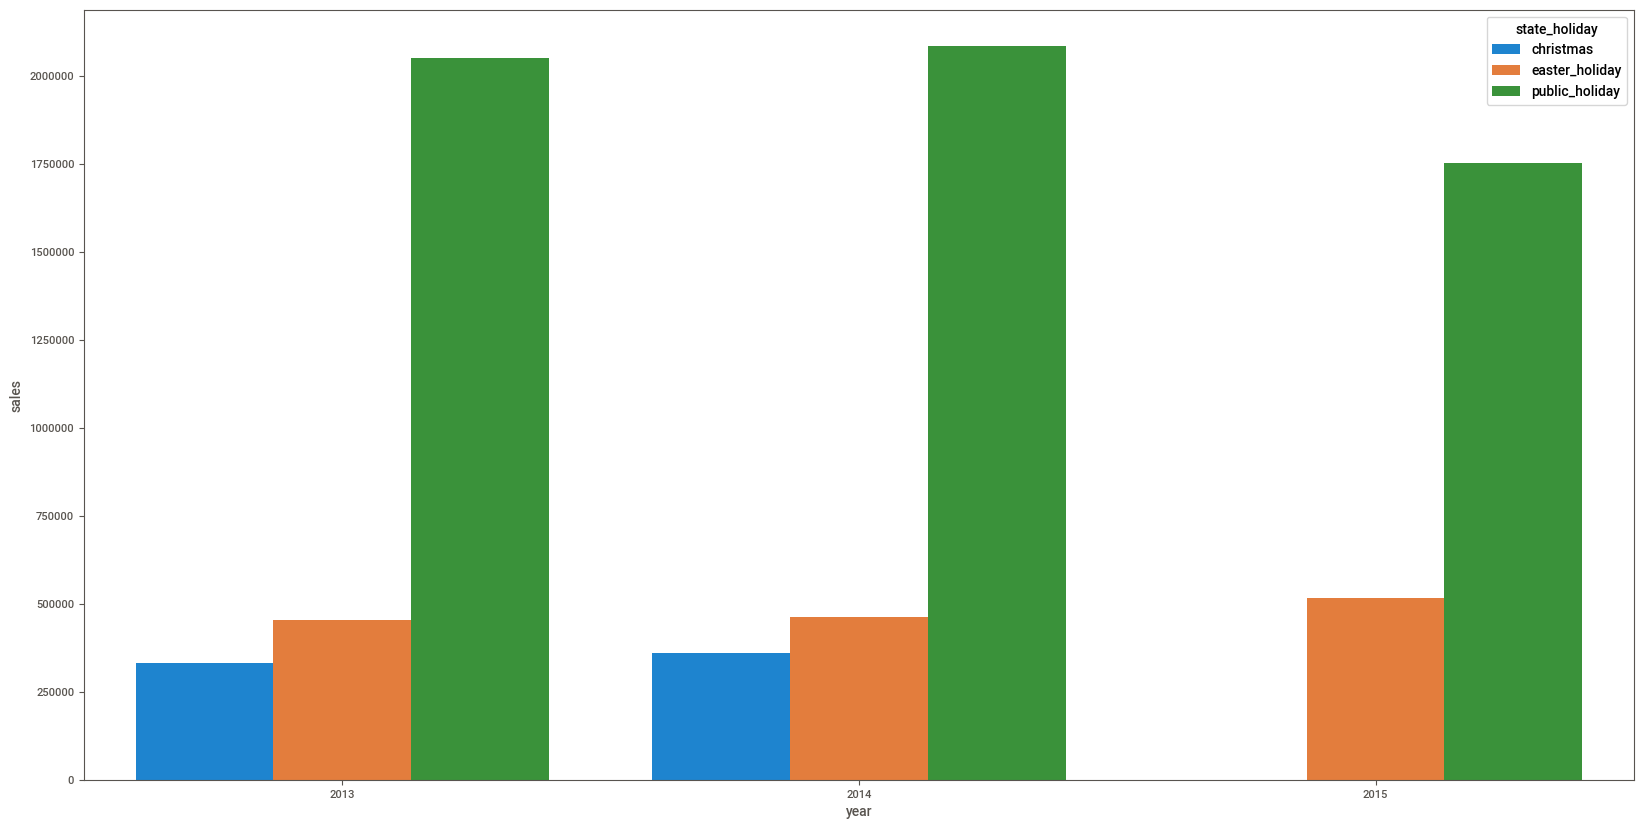

In [58]:
a2 = a1[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday']).sum().reset_index()
sns.barplot( a2, x='year', y='sales', hue='state_holiday');

8. Lojas deveriam vender mais ao longo dos anos.

FALSO = Lojas vendem menos ao logo dos anos.

- As vendas vem caindo durante 2013 até 2015

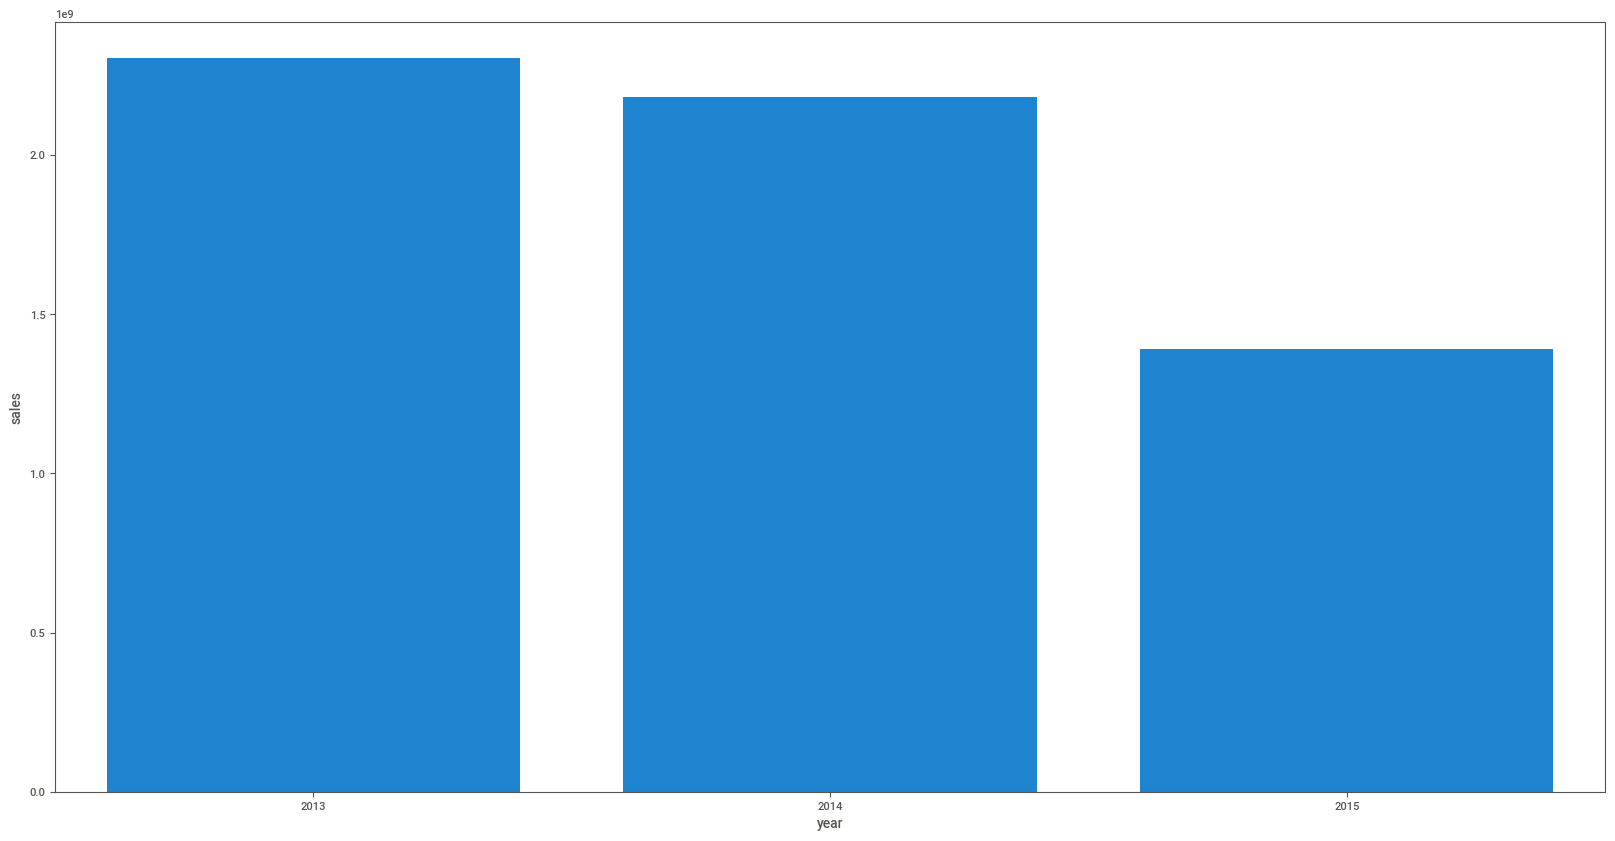

In [62]:
h8 = df4[['year', 'sales']].groupby( ['year',]).sum().reset_index()
sns.barplot( h8, x='year', y='sales');

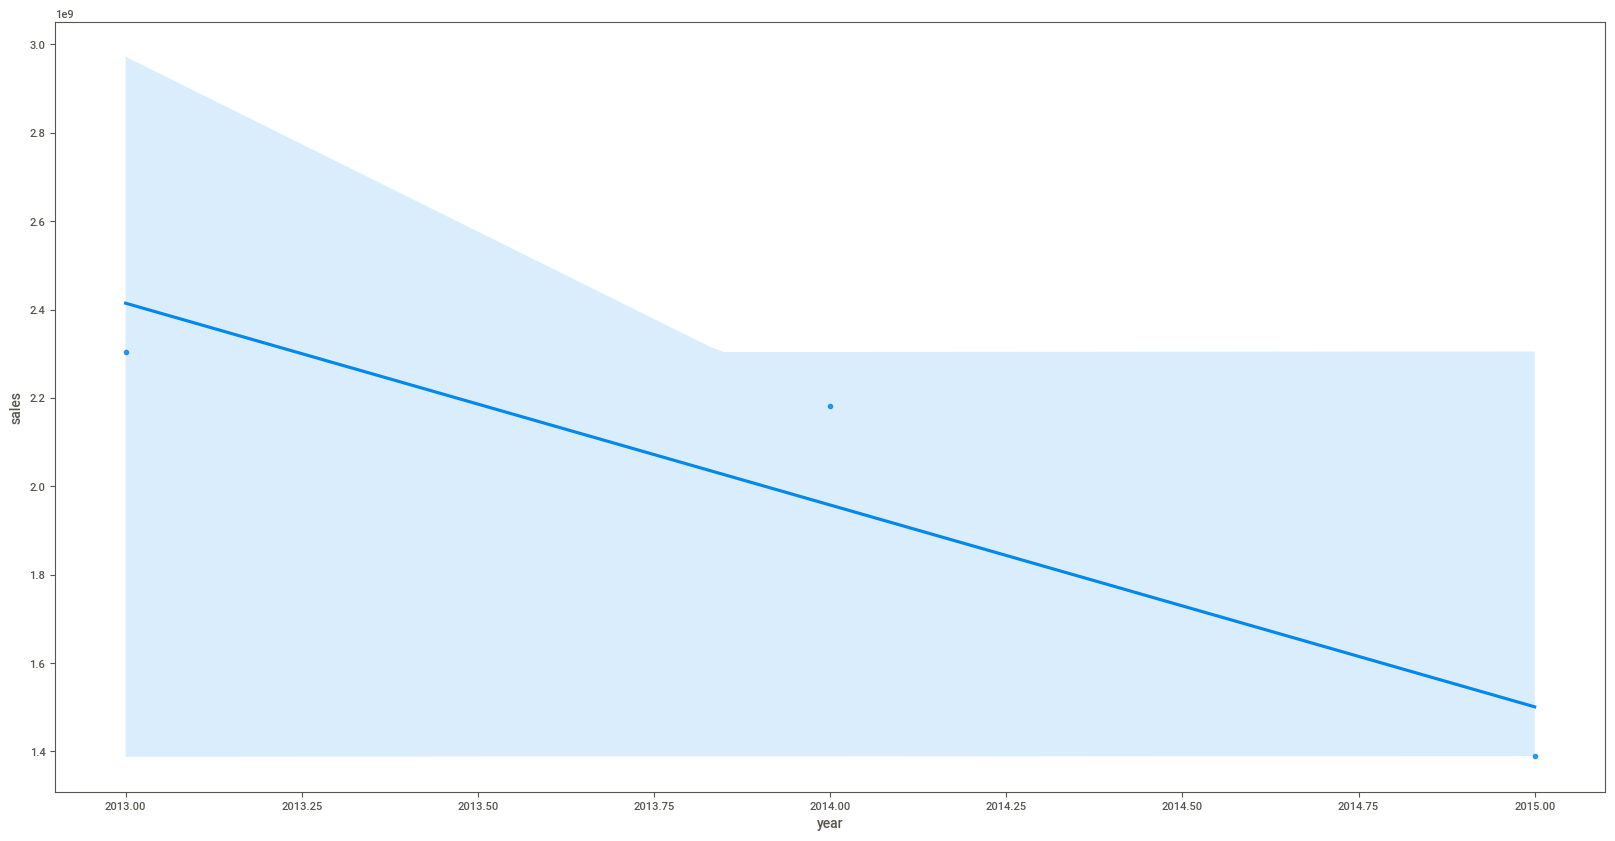

In [64]:
sns.regplot( h8, x='year', y='sales');

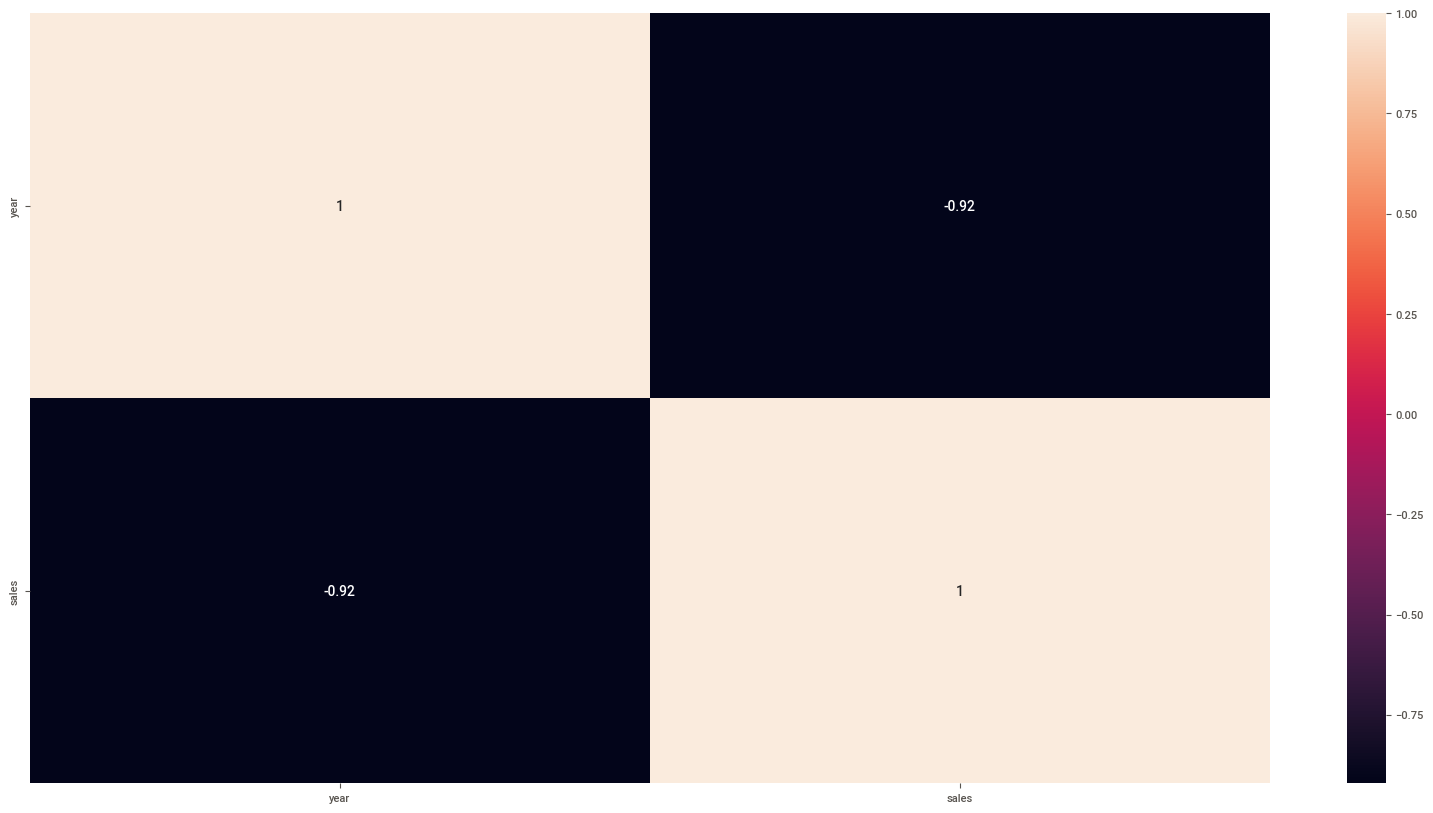

In [65]:
sns.heatmap( h8.corr( method='pearson' ), annot=True );

9. Lojas deveriam vender mais no segundo semestre do ano.

FALSO = As lojas vemde menos no segundo semestre.

- A partir de Agosto as vendam caem drasticamente.

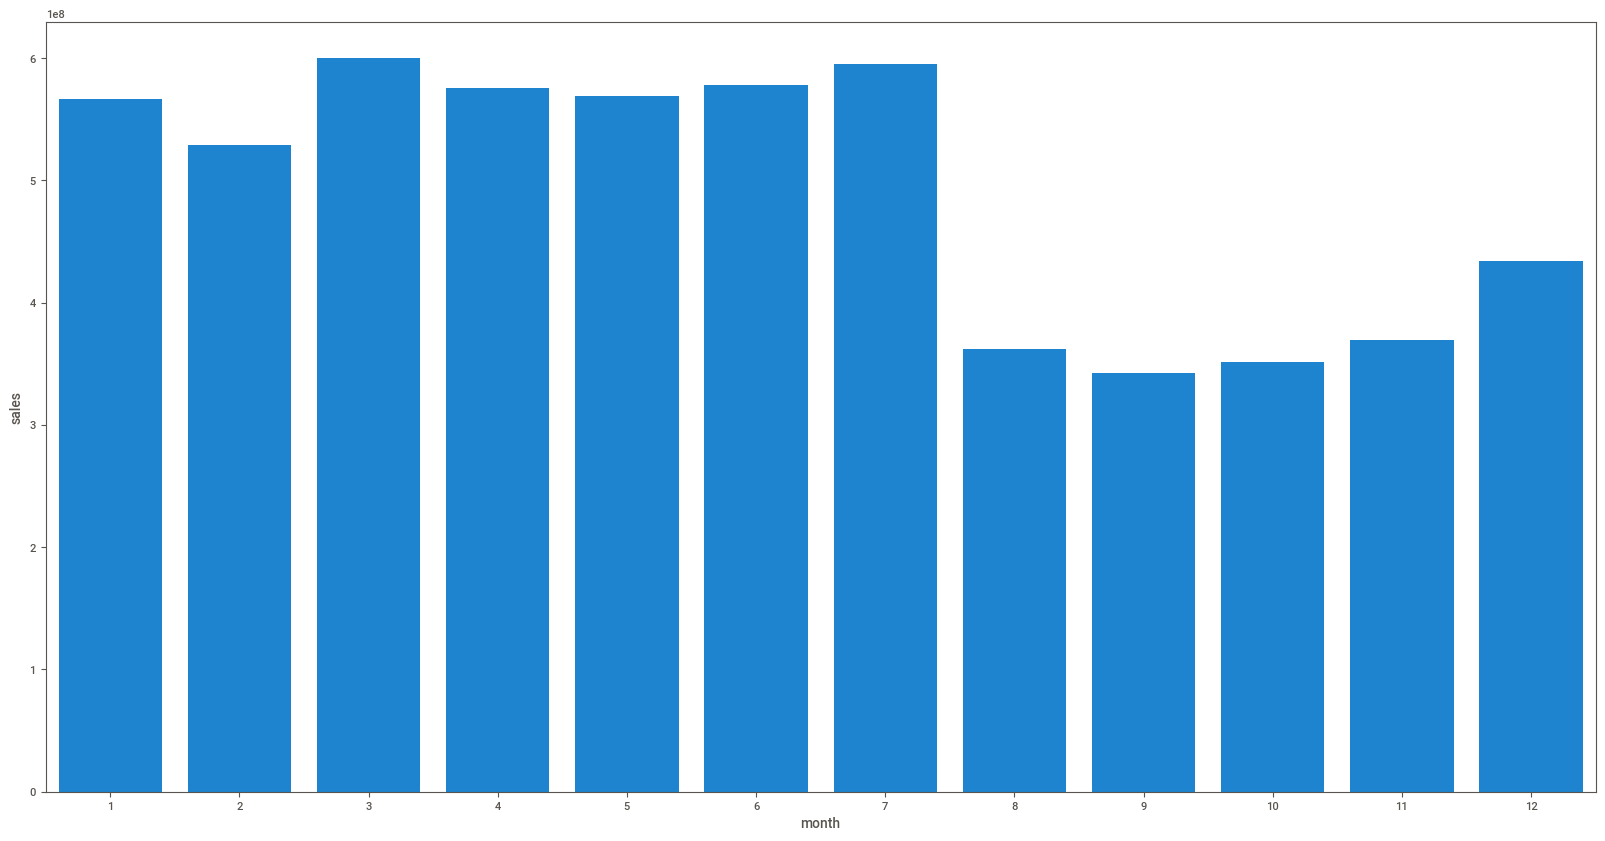

In [68]:
h9 = df4[['month', 'sales']].groupby( ['month']).sum().reset_index()
sns.barplot( h9, x='month', y='sales');

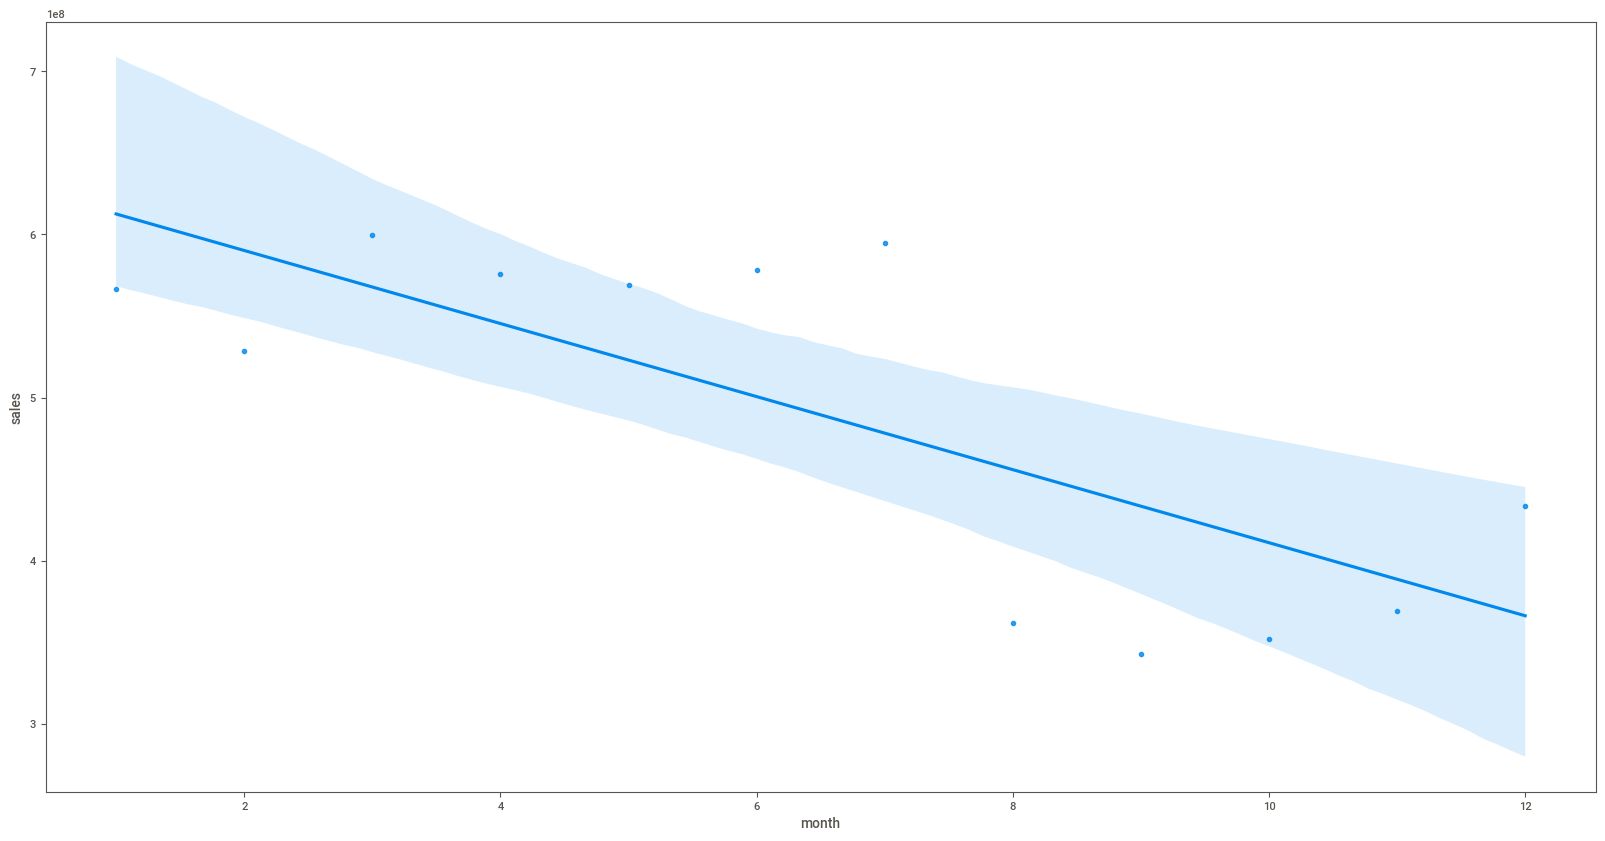

In [69]:
sns.regplot( h9, x='month', y='sales');

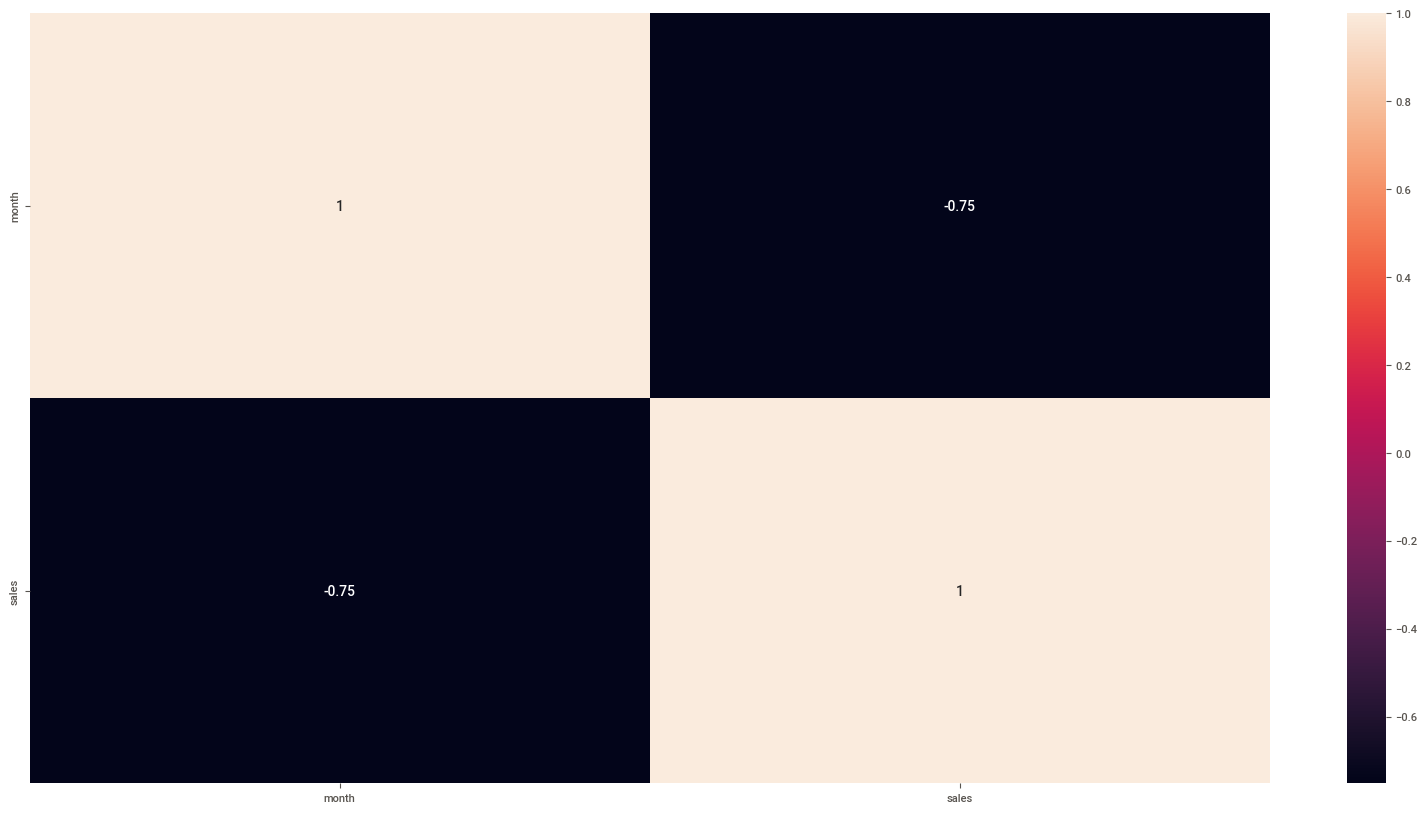

In [70]:
sns.heatmap( h9.corr( method='pearson' ), annot=True );

10 Lojas deveriam vender mais depois do dia 10 de cada mês.

*VERDADEIRA* - Bem óbvio porque depois do dia dia temos mais 20 dias para fechar o mês.

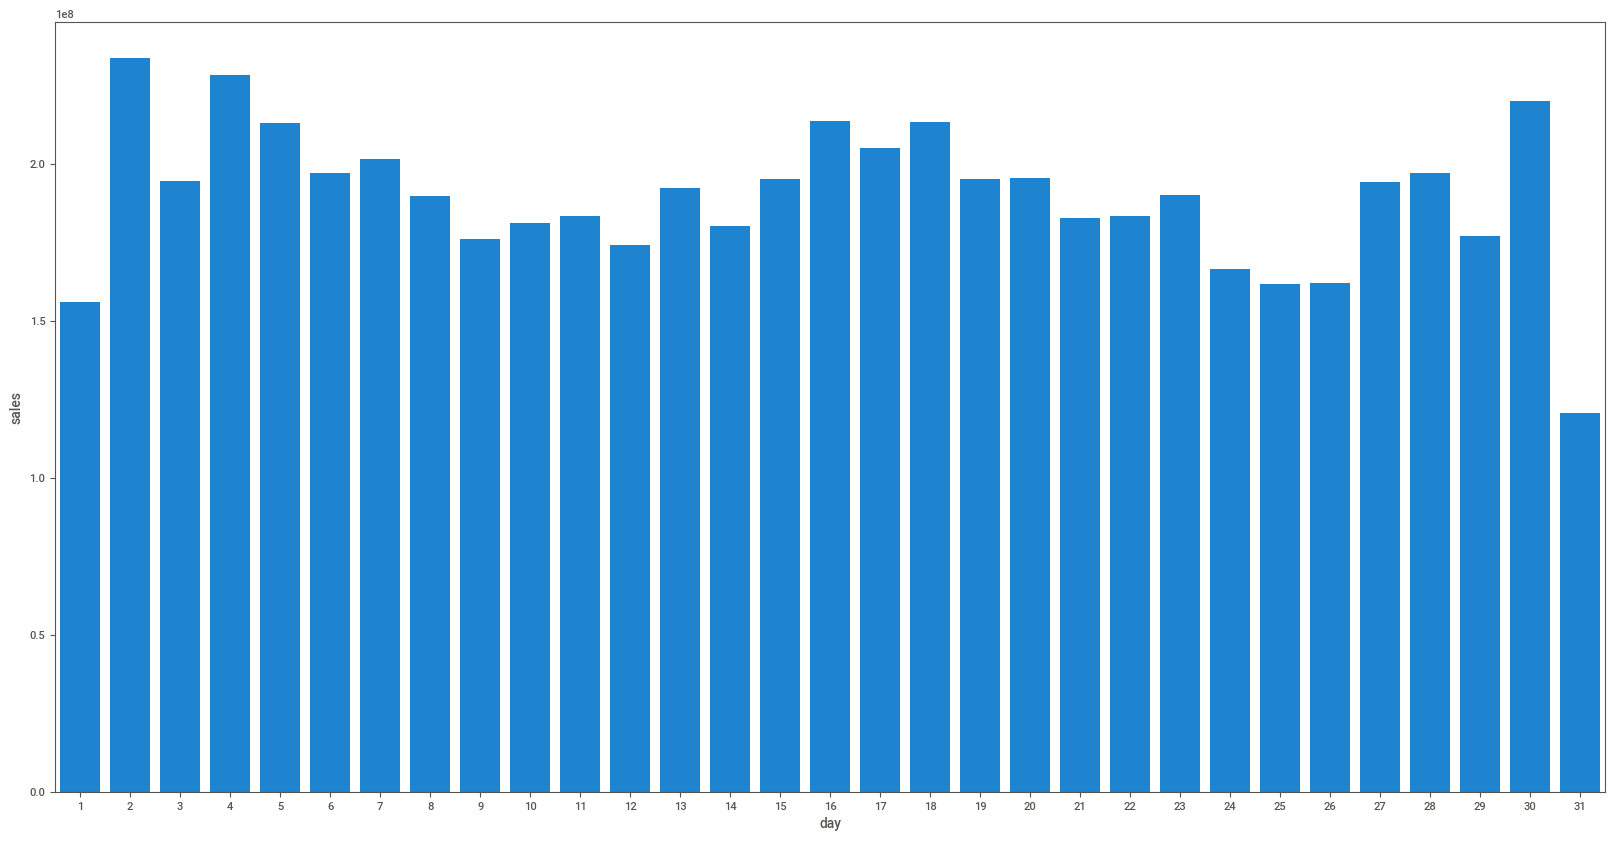

In [71]:
h10 = df4[['day', 'sales']].groupby( ['day']).sum().reset_index()
sns.barplot( h10, x='day', y='sales');

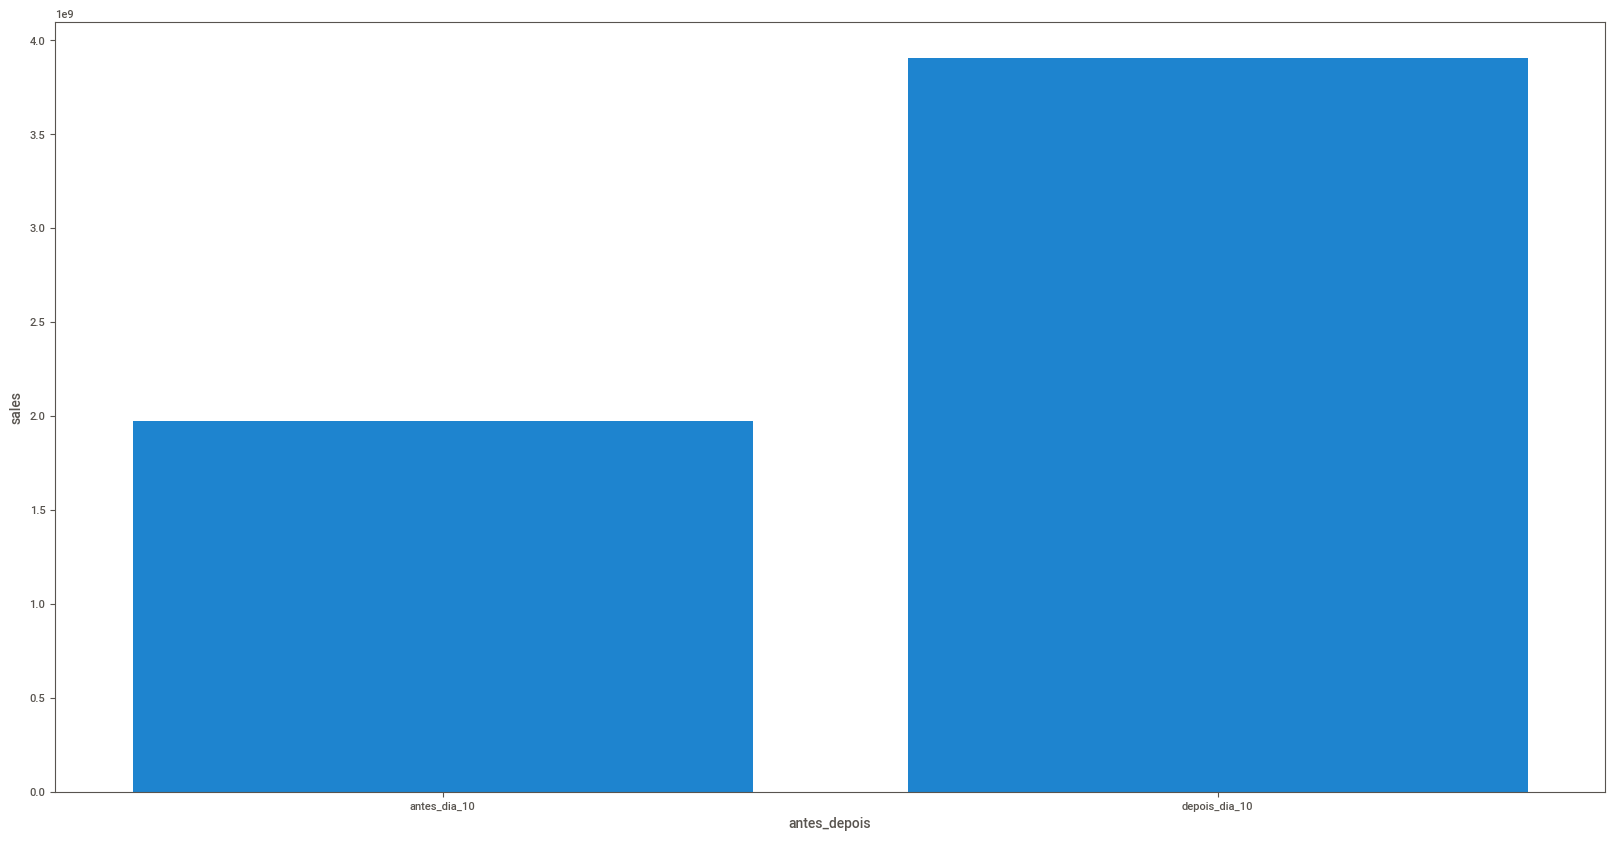

In [77]:
h10['antes_depois'] = h10['day'].apply(lambda x: 'antes_dia_10' if x <=10 else 'depois_dia_10')
h111 = h10[['antes_depois','sales']].groupby( 'antes_depois').sum().reset_index()
sns.barplot( h111, x='antes_depois', y='sales');

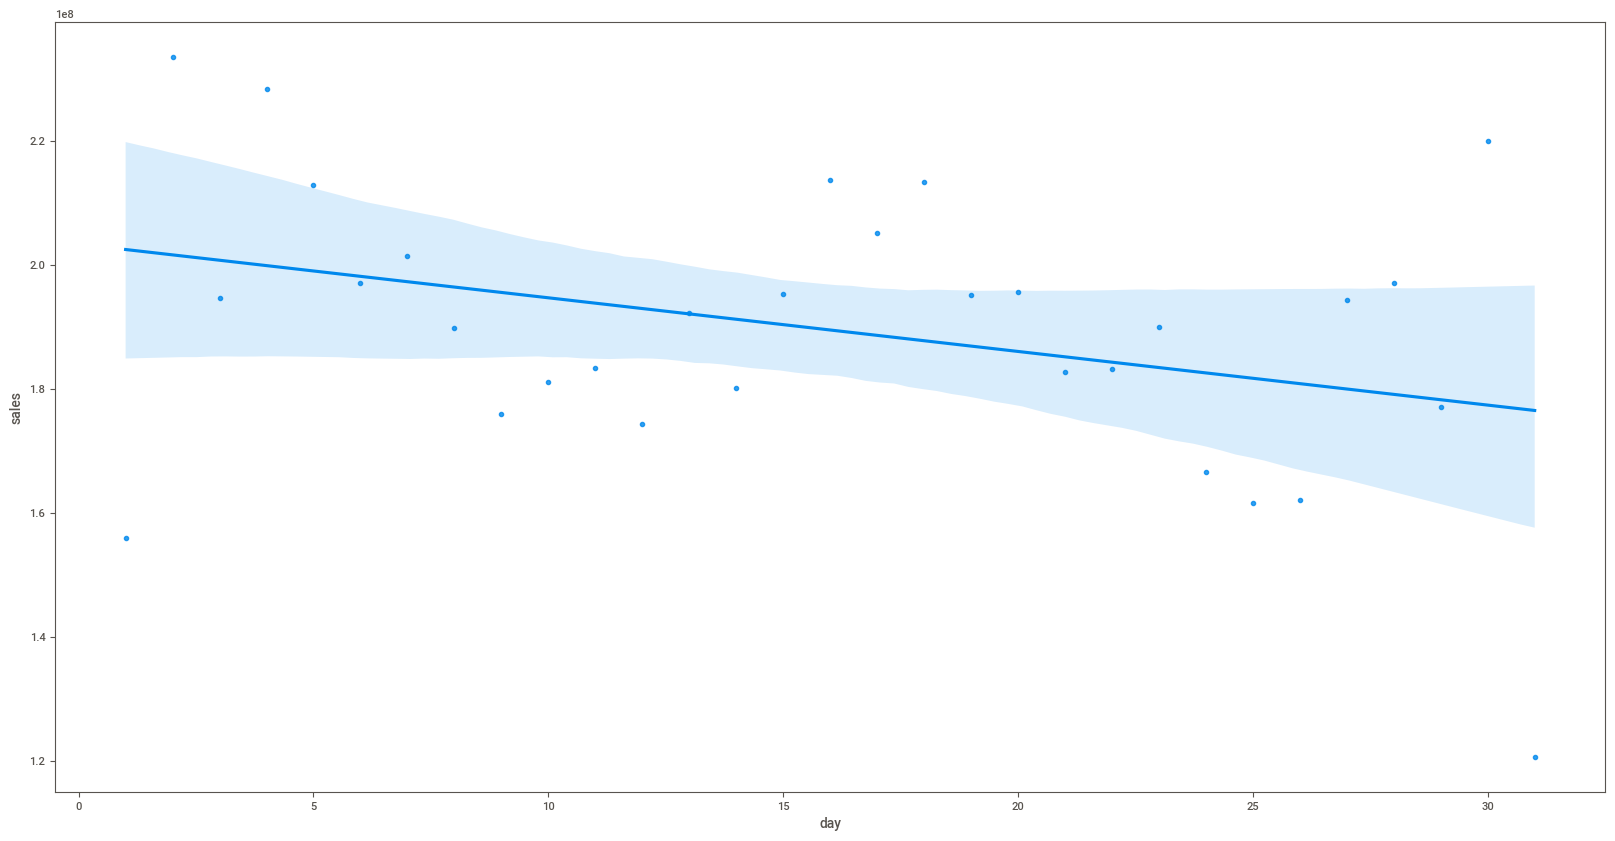

In [72]:
sns.regplot( h10, x='day', y='sales');

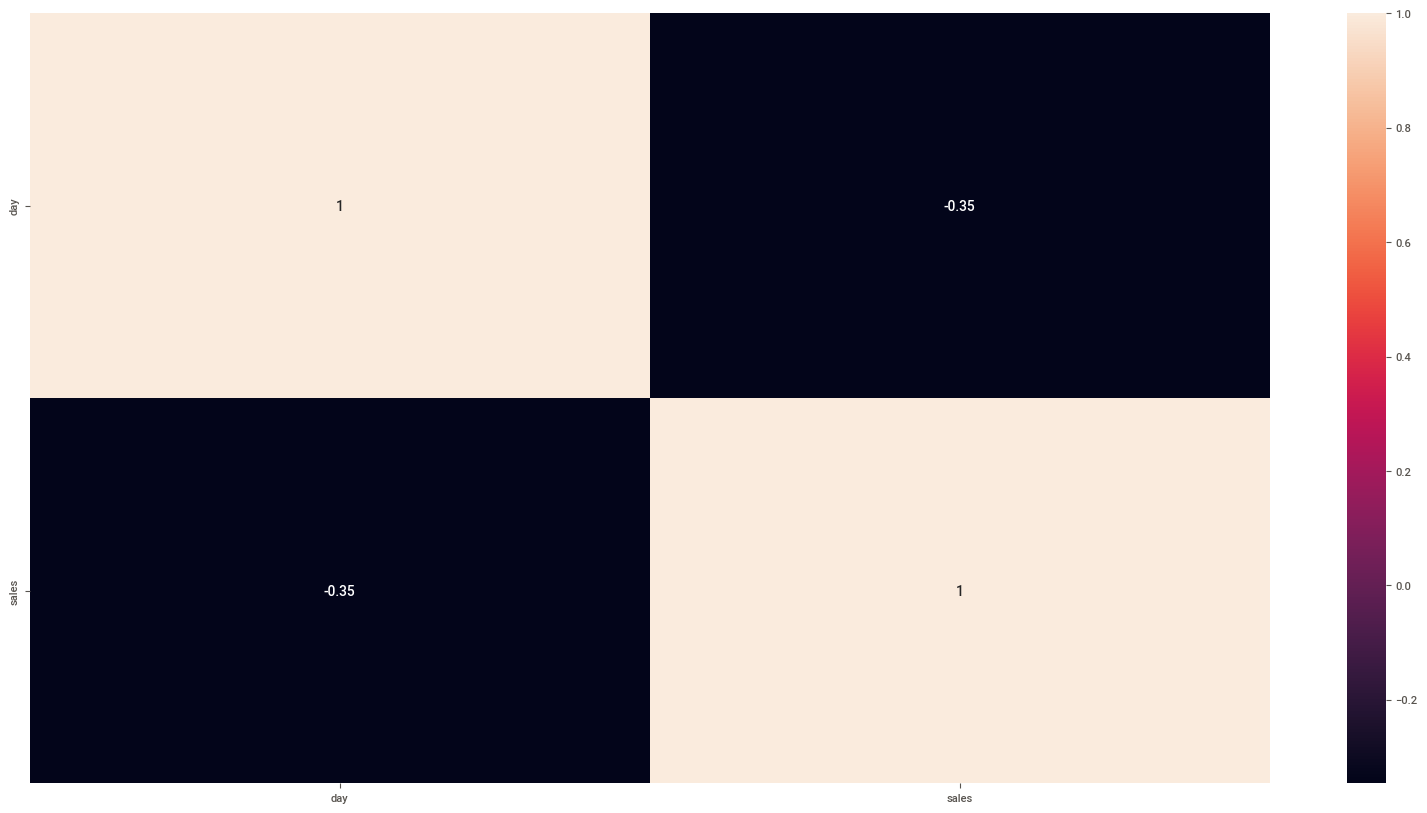

In [73]:
sns.heatmap( h10.corr( method='pearson' ), annot=True );

11. Lojas deveriam vender menos aos finais de semana.

*VERDADEIRA* - Situação parecida como acima, visto que fim de semana são apenas dois dias da semana.

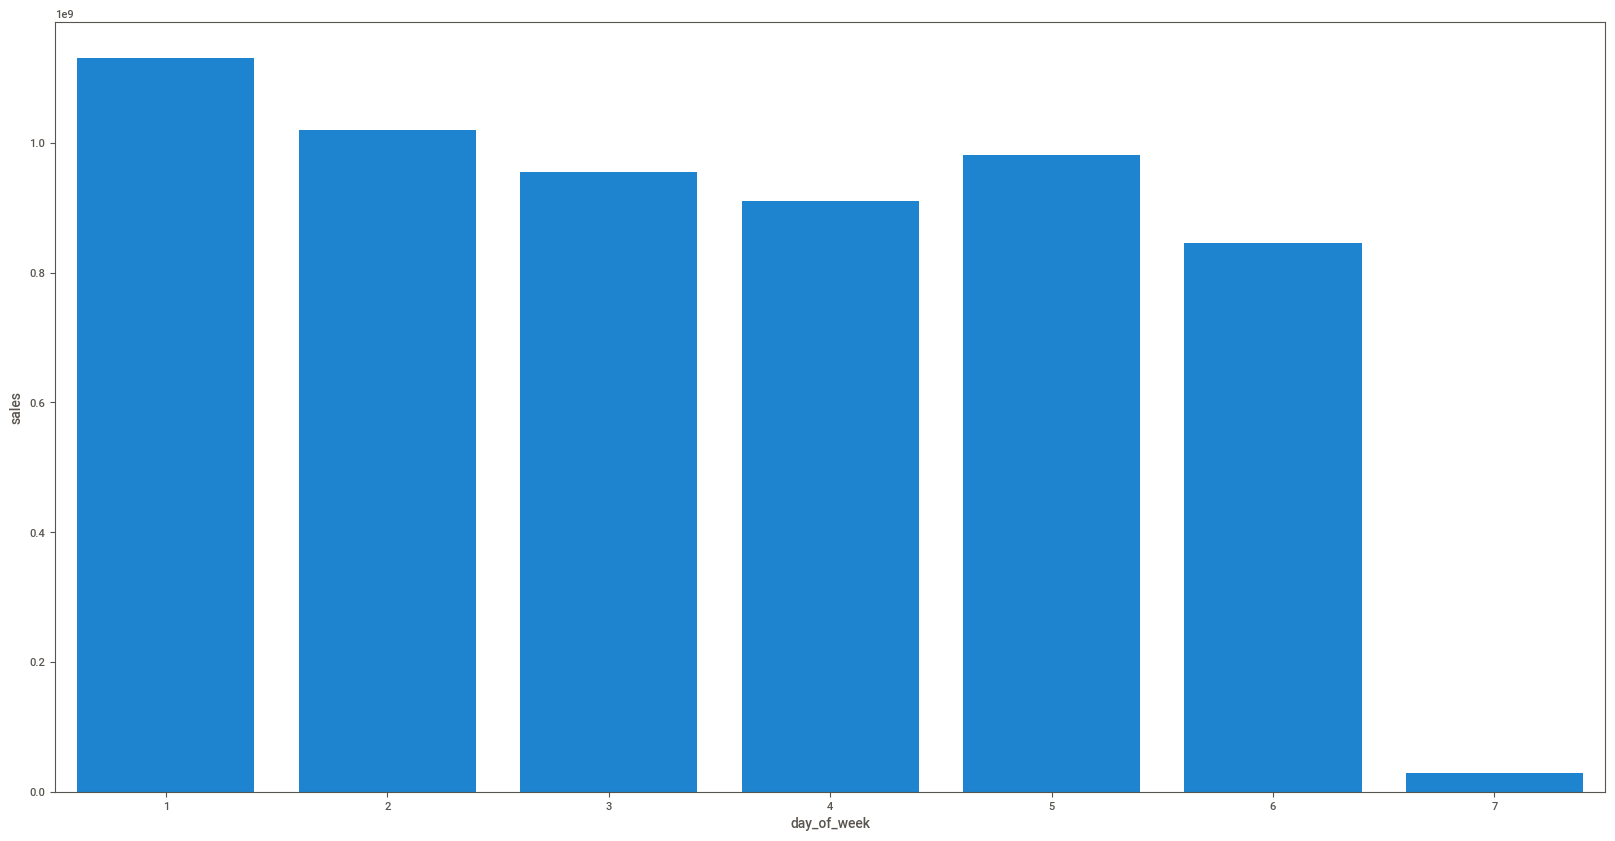

In [79]:
h11 = df4[['day_of_week', 'sales']].groupby( ['day_of_week']).sum().reset_index()
sns.barplot( h11, x='day_of_week', y='sales');

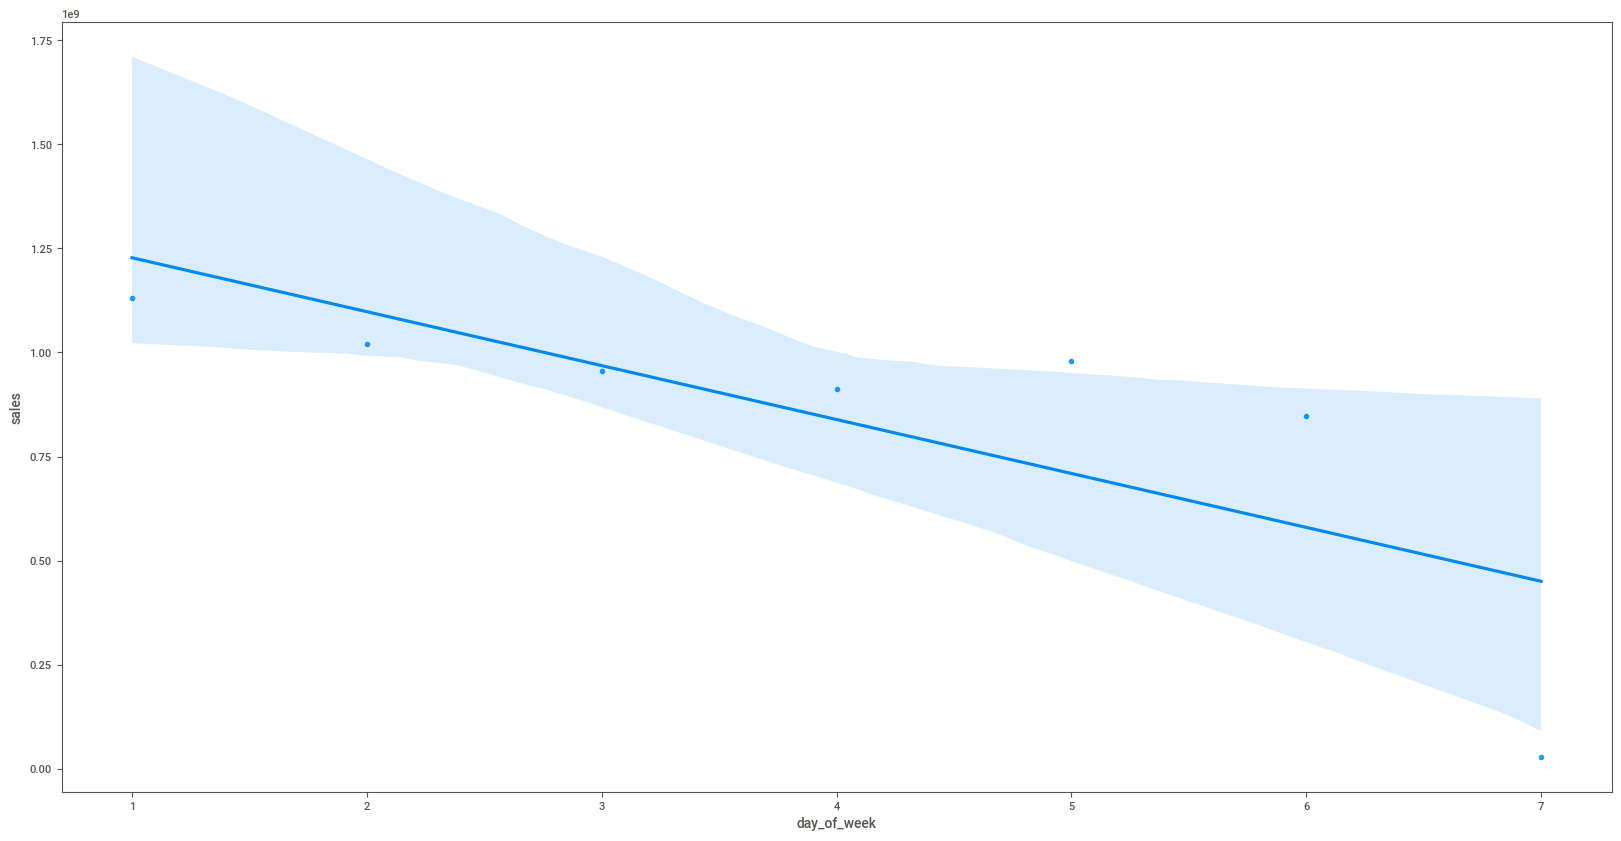

In [80]:
sns.regplot( h11, x='day_of_week', y='sales');

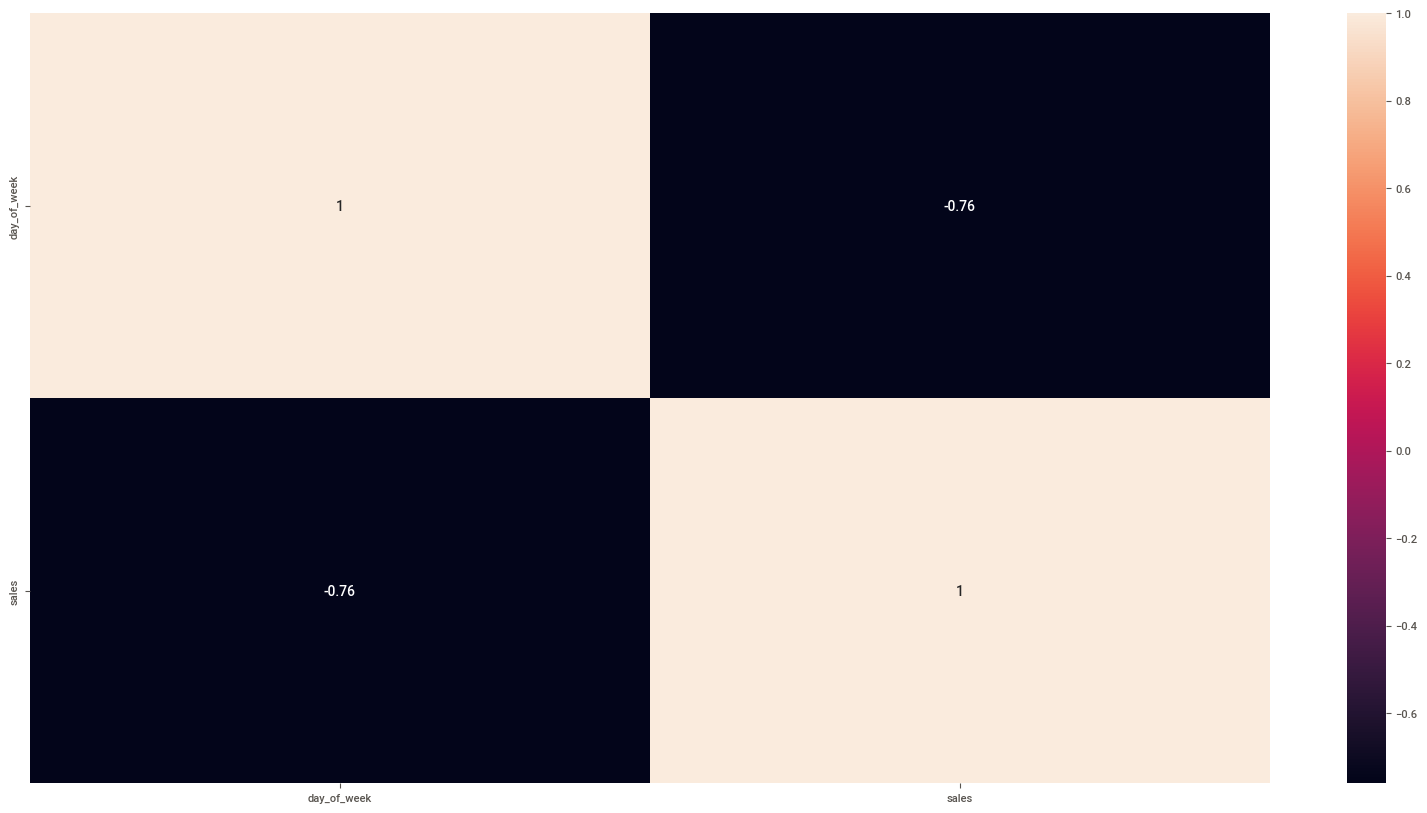

In [81]:
sns.heatmap( h11.corr( method='pearson' ), annot=True );

12. Lojas deveriam vender menos durante os feriados escolares.

*VERDADEIRA* - Pois existem muito mais dias regulares do que dias com feriados escolares.

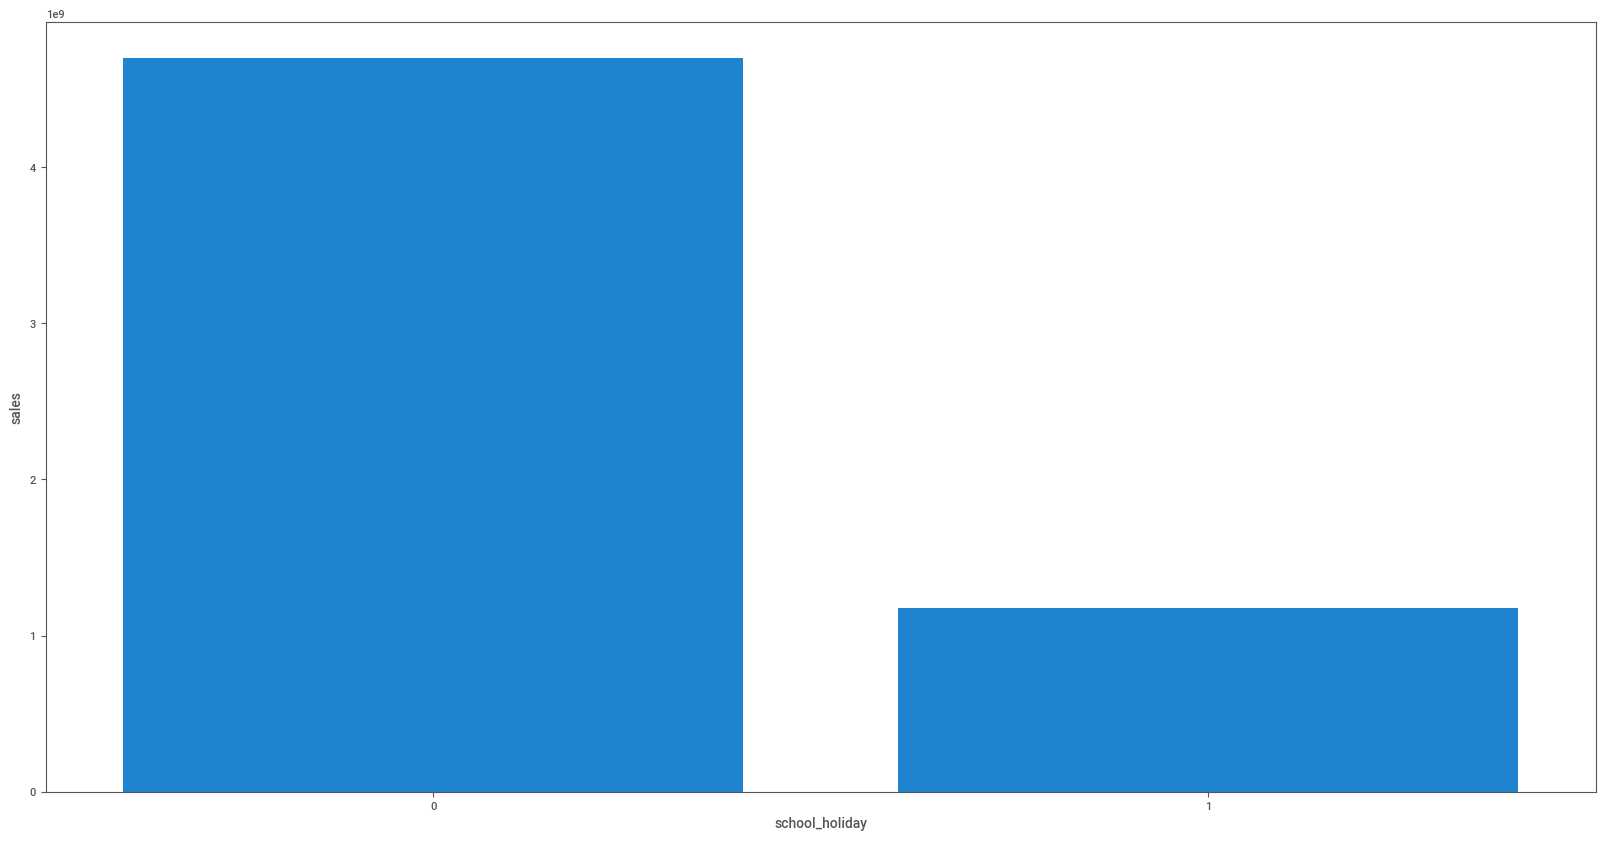

In [83]:
h12 = df4[['school_holiday', 'sales']].groupby( ['school_holiday']).sum().reset_index()
sns.barplot( h12, x='school_holiday', y='sales');

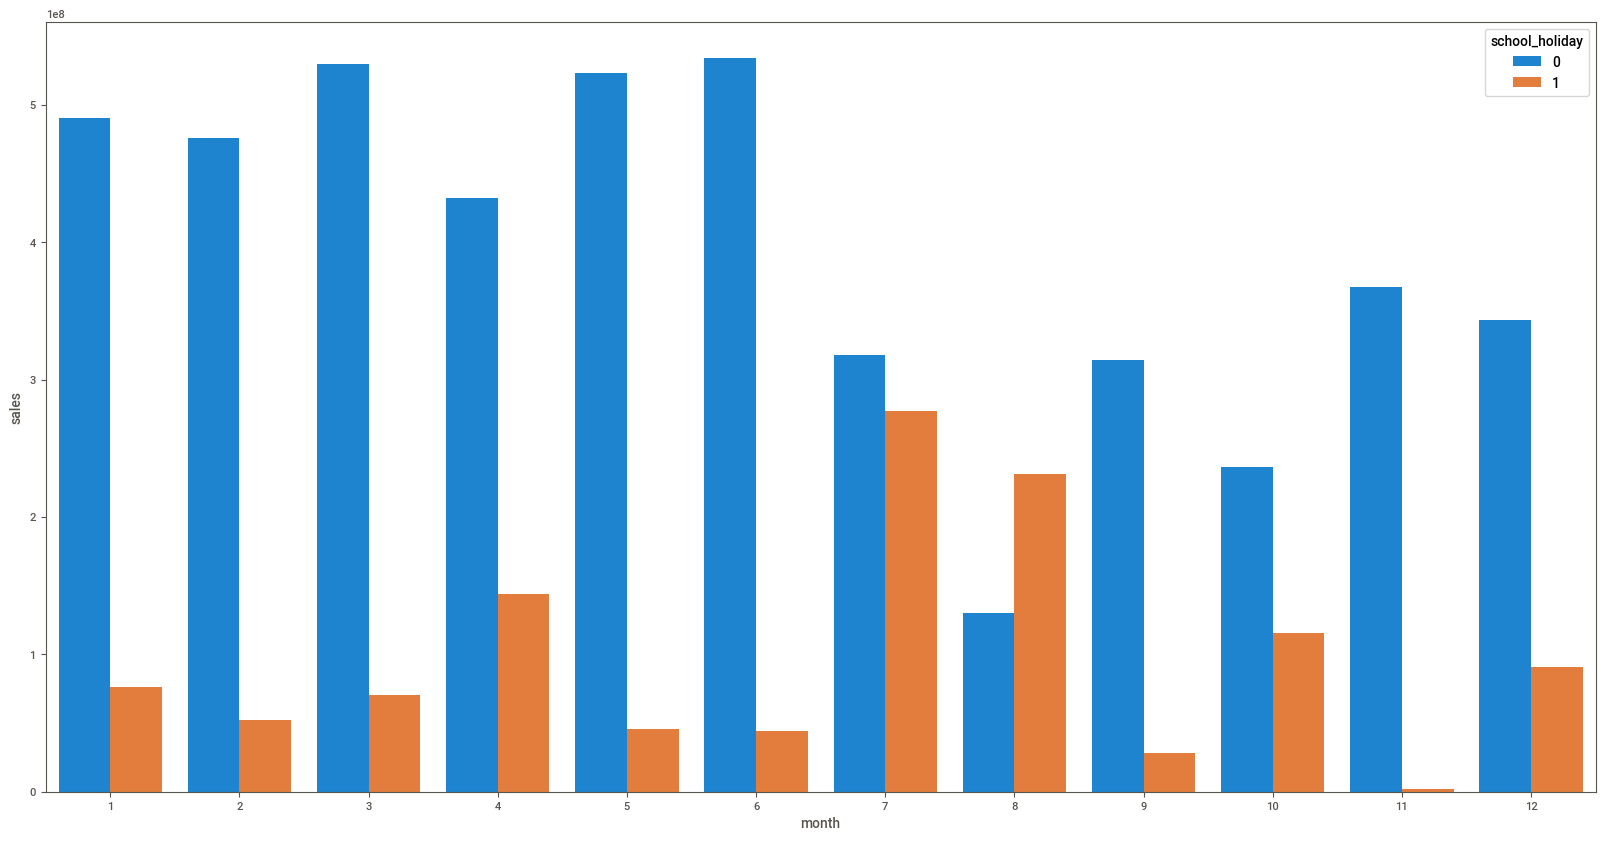

In [87]:
# Vendas por mês
h121 =df4[['school_holiday', 'month', 'sales']].groupby( ['month','school_holiday']).sum().reset_index()
sns.barplot( h131, x='month', y='sales', hue='school_holiday');

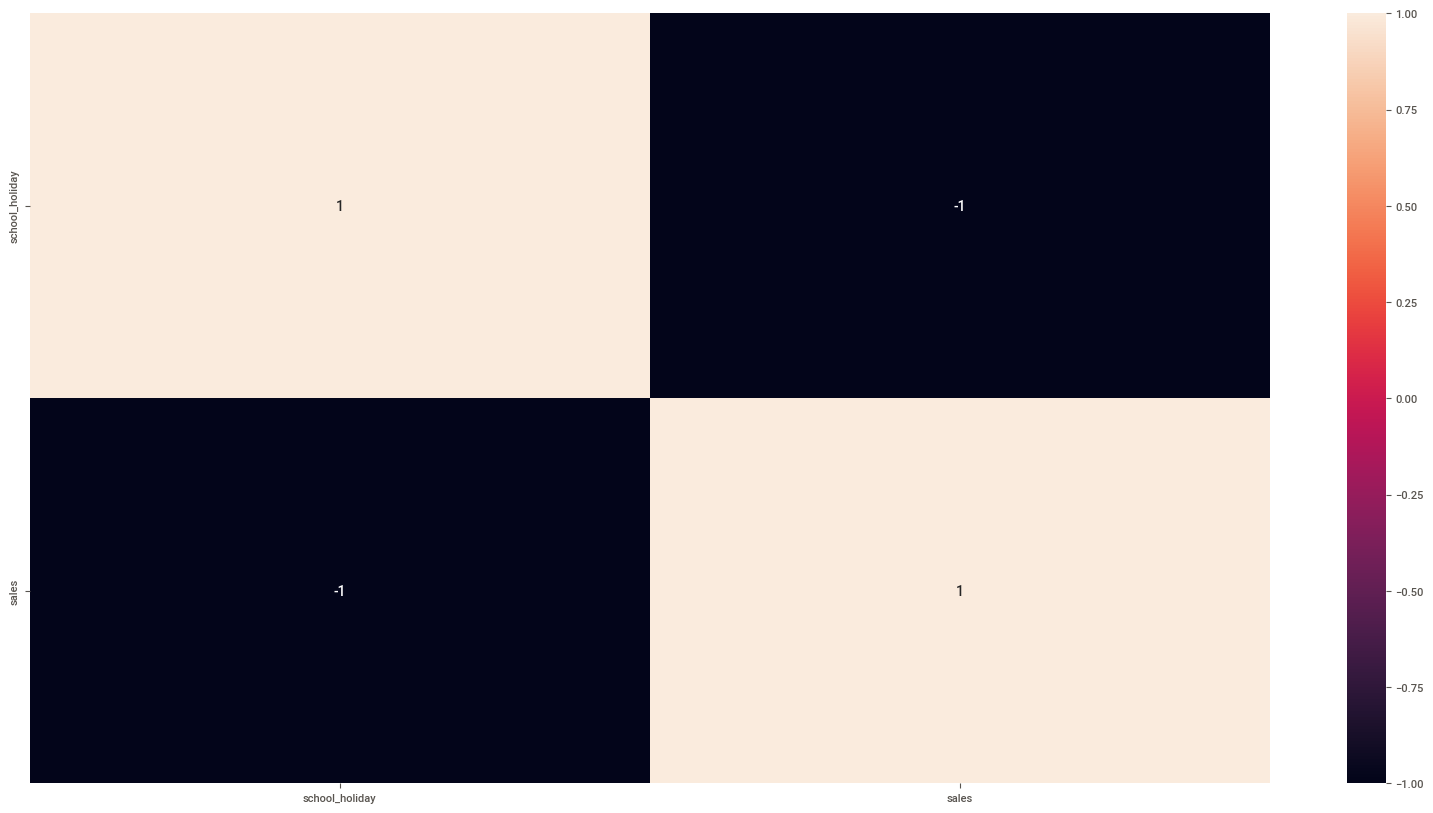

In [86]:
sns.heatmap( h12.corr( method='pearson' ), annot=True );

### 4.2.1 Resumo das hipóteses

In [89]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Media'],
        ['H3', 'Falsa', 'Media'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H6', 'Falsa', 'Baixa'],
        ['H7', 'Falsa', 'Media'],
        ['H8', 'Falsa', 'Alta'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Verdadeira', 'Alta'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### 4.3.1 Atributos Numéricos

<Axes: >

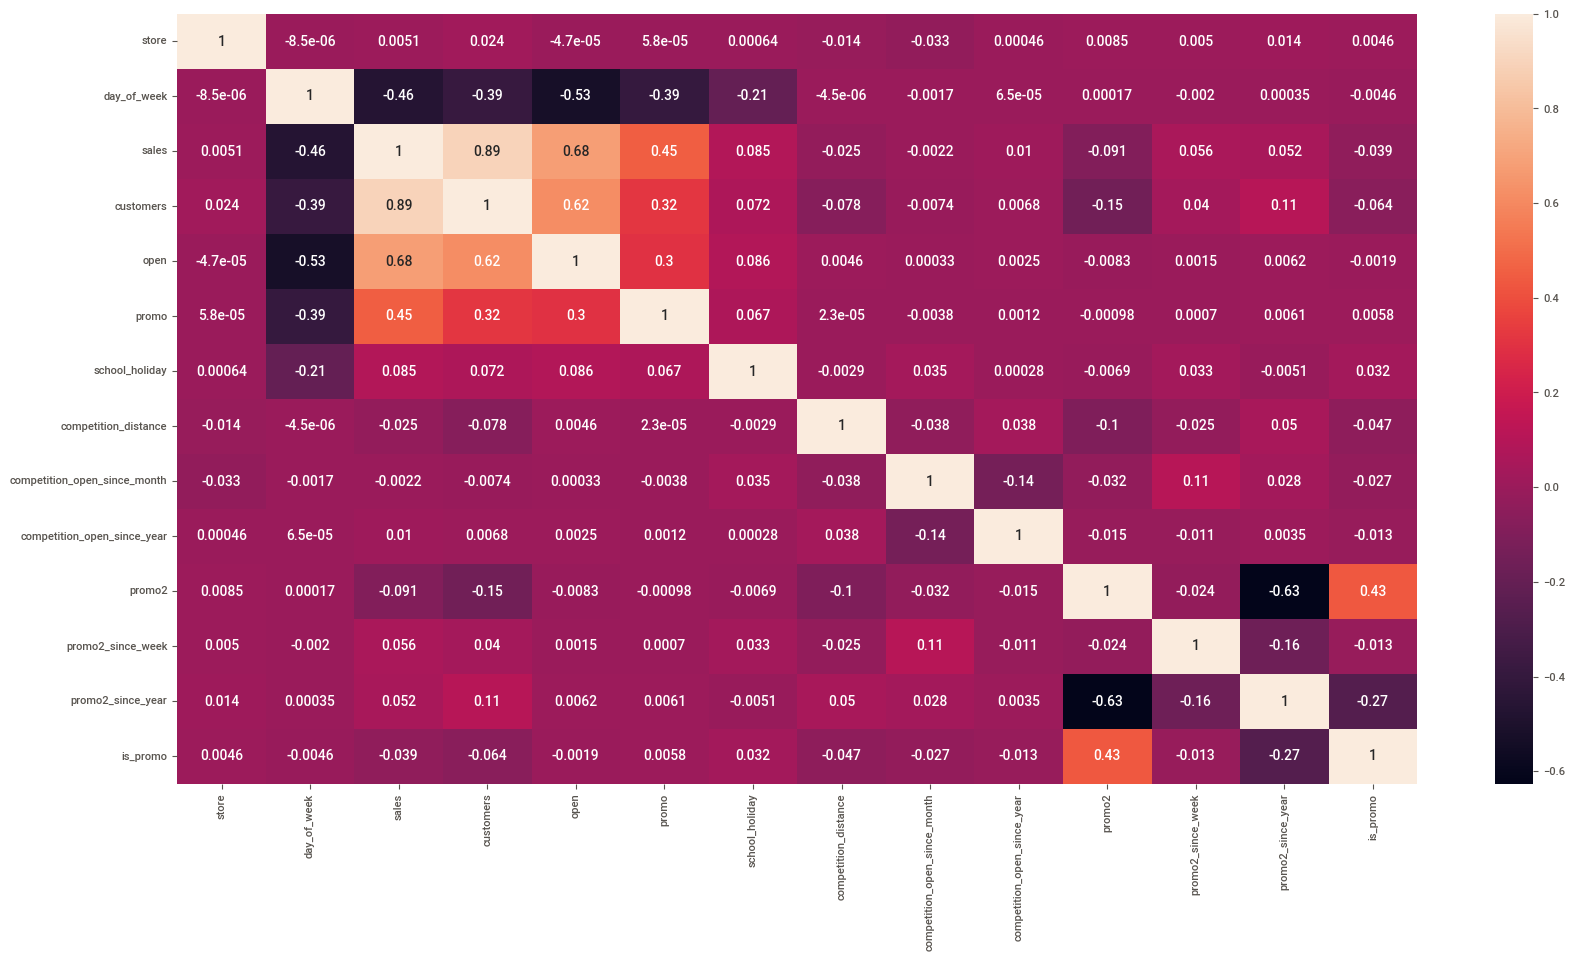

In [91]:
correlacao = numericos.corr(method='pearson')
sns.heatmap(correlacao, annot=True)

# quanto mais escuro, maior a correlação negativa.
# quanto mais claro, maior a correlação positiva.

### 4.3.2 Atributos Categóricos

In [92]:
a = df4.select_dtypes(include='object')

In [106]:
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

<Axes: >

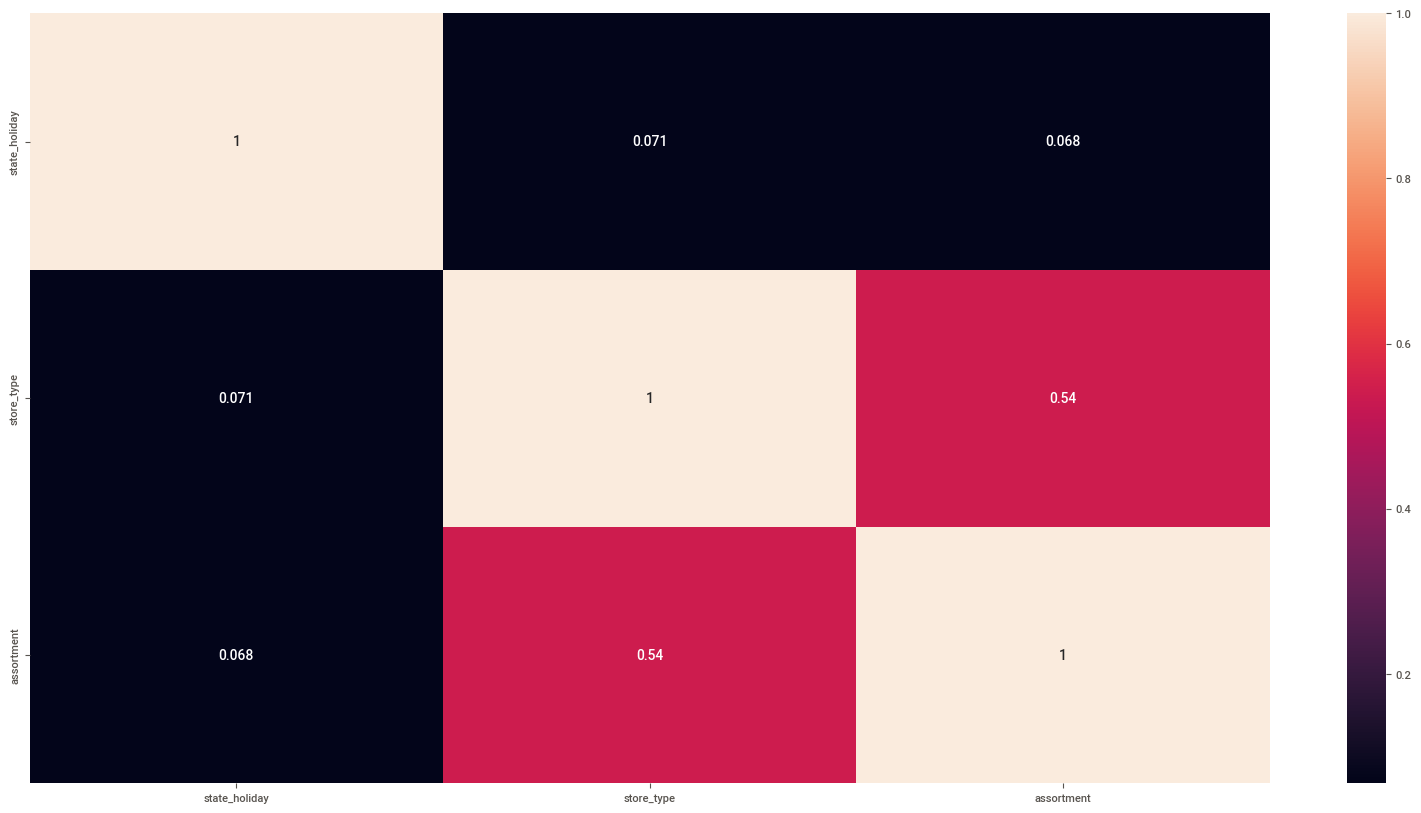

In [107]:
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 'store_type': [a4, a5, a6], 'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )